In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data (2015, 2016, and 2017 currently)

In [5]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2015jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2015jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2015-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
        HTGclmDSpatch_all2015 = HTGclmDS_patch
        HMGclmDSpatch_all2015 = HMGclmDS_patch
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015 = xr.concat([HTGclmDSpatch_all2015,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015 = xr.concat([HMGclmDSpatch_all2015,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [6]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja'
caseName_HTG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2016jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2016jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2016-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
        HTGclmDSpatch_all2016 = HTGclmDS_patch
        HMGclmDSpatch_all2016 = HMGclmDS_patch
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016 = xr.concat([HTGclmDSpatch_all2016,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016 = xr.concat([HMGclmDSpatch_all2016,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [7]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2017jja'
caseName_HTG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2017jja'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2017jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2017jja'



# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2017-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2017-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2017-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2017-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2017-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2017 = HTGcamDS 
        HMGcamDS_all2017 = HMGcamDS
        HTGclmDS_all2017 = HTGclmDS
        HMGclmDS_all2017 = HMGclmDS 
        HTGclmDSpatch_all2017 = HTGclmDS_patch
        HMGclmDSpatch_all2017 = HMGclmDS_patch
    else: 
        HTGcamDS_all2017 = xr.concat([HTGcamDS_all2017, HTGcamDS], dim='time')
        HMGcamDS_all2017 = xr.concat([HMGcamDS_all2017, HMGcamDS], dim='time')
        HTGclmDS_all2017 = xr.concat([HTGclmDS_all2017,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2017 = xr.concat([HMGclmDS_all2017,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2017 = xr.concat([HTGclmDSpatch_all2017,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2017 = xr.concat([HMGclmDSpatch_all2017,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [8]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2018jja'
caseName_HTG ='FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2018jja'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2017jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2017jja'



# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2018-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2018-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2018-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2018-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2018-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2018-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2018 = HTGcamDS 
        HMGcamDS_all2018 = HMGcamDS
        HTGclmDS_all2018 = HTGclmDS
        HMGclmDS_all2018 = HMGclmDS 
        HTGclmDSpatch_all2018 = HTGclmDS_patch
        HMGclmDSpatch_all2018 = HMGclmDS_patch
    else: 
        HTGcamDS_all2018 = xr.concat([HTGcamDS_all2018, HTGcamDS], dim='time')
        HMGcamDS_all2018 = xr.concat([HMGcamDS_all2018, HMGcamDS], dim='time')
        HTGclmDS_all2018 = xr.concat([HTGclmDS_all2018,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2018 = xr.concat([HMGclmDS_all2018,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2018 = xr.concat([HTGclmDSpatch_all2018,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2018 = xr.concat([HMGclmDSpatch_all2018,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [10]:
#selYear = 2017
selYear = 'all'

if selYear==2015: 
    HTGcamDS_all = HTGcamDS_all2015
    HMGcamDS_all = HMGcamDS_all2015
    HTGclmDS_all = HTGclmDS_all2015
    HMGclmDS_all = HMGclmDS_all2015
elif selYear==2016:
    HTGcamDS_all = HTGcamDS_all2016
    HMGcamDS_all = HMGcamDS_all2016
    HTGclmDS_all = HTGclmDS_all2016
    HMGclmDS_all = HMGclmDS_all2016    
elif selYear==2017:
    HTGcamDS_all = HTGcamDS_all2017
    HMGcamDS_all = HMGcamDS_all2017
    HTGclmDS_all = HTGclmDS_all2017
    HMGclmDS_all = HMGclmDS_all2017 
elif selYear==2018:
    HTGcamDS_all = HTGcamDS_all2018
    HMGcamDS_all = HMGcamDS_all2018
    HTGclmDS_all = HTGclmDS_all2018
    HMGclmDS_all = HMGclmDS_all2018 
elif selYear=='all': 
    ## Discard spin up days 
    iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

    HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
    HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
    HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
    HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)
    HTGclmDSpatch_all2015 = HTGclmDSpatch_all2015.isel(time=timeArr)
    HMGclmDSpatch_all2015 = HMGclmDSpatch_all2015.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

    HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
    HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
    HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
    HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)
    HTGclmDSpatch_all2016 = HTGclmDSpatch_all2016.isel(time=timeArr)
    HMGclmDSpatch_all2016 = HMGclmDSpatch_all2016.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2017.time.values >= (HTGcamDS_all2017.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2017.time.values))

    HTGcamDS_all2017 = HTGcamDS_all2017.isel(time=timeArr)
    HTGclmDS_all2017 = HTGclmDS_all2017.isel(time=timeArr)
    HMGcamDS_all2017 = HMGcamDS_all2017.isel(time=timeArr)
    HMGclmDS_all2017 = HMGclmDS_all2017.isel(time=timeArr)
    HTGclmDSpatch_all2017 = HTGclmDSpatch_all2017.isel(time=timeArr)
    HMGclmDSpatch_all2017 = HMGclmDSpatch_all2017.isel(time=timeArr)

    iTimeStart   = np.where(HTGcamDS_all2018.time.values >= (HTGcamDS_all2018.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2018.time.values))

    HTGcamDS_all2018 = HTGcamDS_all2018.isel(time=timeArr)
    HTGclmDS_all2018 = HTGclmDS_all2018.isel(time=timeArr)
    HMGcamDS_all2018 = HMGcamDS_all2018.isel(time=timeArr)
    HMGclmDS_all2018 = HMGclmDS_all2018.isel(time=timeArr)
    HTGclmDSpatch_all2018 = HTGclmDSpatch_all2018.isel(time=timeArr)
    HMGclmDSpatch_all2018 = HMGclmDSpatch_all2018.isel(time=timeArr)
    
    ## Concat into one giant DS
    HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016, HTGcamDS_all2017, HTGcamDS_all2018], dim='time')
    HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016, HMGcamDS_all2017, HMGcamDS_all2018], dim='time')
    HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016, HTGclmDS_all2017, HTGclmDS_all2018], dim='time')
    HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016, HMGclmDS_all2017, HMGclmDS_all2018], dim='time')
    
#     HTGclmDS_allPatch = xr.concat([HTGclmDSpatch_all2015, HTGclmDSpatch_all2016, HTGclmDSpatch_all2017, HTGclmDSpatch_all2018], dim='time', data_vars='minimal')
#     HMGclmDS_allPatch = xr.concat([HMGclmDSpatch_all2015, HMGclmDSpatch_all2016, HMGclmDSpatch_all2017, HMGclmDSpatch_all2018], dim='time', data_vars='minimal')
    

#### Just a quick check of T/Q 

(1000.0, 100.0)

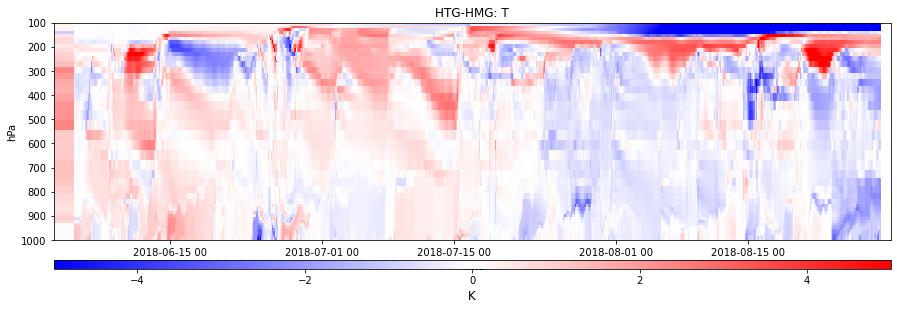

In [13]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_all.T.values - HMGcamDS_all.T.values)),
                               vmin=-5, vmax=5,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all.T.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG: T', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,100])


(1000.0, 100.0)

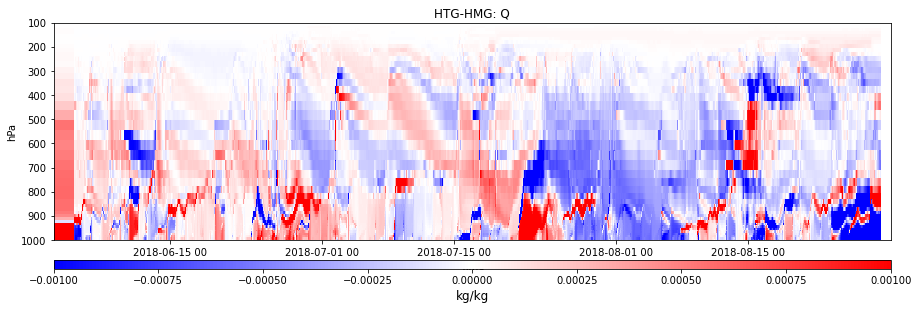

In [14]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_all.Q.values - HMGcamDS_all.Q.values)),
                               vmin=-0.001, vmax=0.001,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all.Q.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG: Q', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,100])



## Start processing the data

#### Define evaporative fraction (LH / (LH+SH)) for each dataset

In [15]:
HTG_EF = HTGcamDS_all.LHFLX.values / (HTGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)
HMG_EF = HMGcamDS_all.LHFLX.values / (HMGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)

HTGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HMG_EF))


#### Get standard deviation of ET as measure of sfc heterogeneity?

Patch types have values:  <br>
  !   0  => not_vegetated <br>
  !   1  => needleleaf_evergreen_temperate_tree <br>
  !   2  => needleleaf_evergreen_boreal_tree <br>
  !   3  => needleleaf_deciduous_boreal_tree <br>
  !   4  => broadleaf_evergreen_tropical_tree <br>
  !   5  => broadleaf_evergreen_temperate_tree <br>
  !   6  => broadleaf_deciduous_tropical_tree <br>
  !   7  => broadleaf_deciduous_temperate_tree <br>
  !   8  => broadleaf_deciduous_boreal_tree <br>
  !   9  => broadleaf_evergreen_shrub <br>
  !   10 => broadleaf_deciduous_temperate_shrub <br>
  !   11 => broadleaf_deciduous_boreal_shrub <br>
  !   12 => c3_arctic_grass <br>
  !   13 => c3_non-arctic_grass <br>
  !   14 => c4_grass <br>
  !   15 => c3_crop <br>
  !   16 => c3_irrigated <br>
<br><br>
Column types have values: <br> 
  !   1  => (istsoil)          soil (vegetated or bare soil)<br> 
  !   2  => (istcrop)          crop (only for crop configuration)<br> 
  !   3  => (UNUSED)           (formerly non-multiple elevation class land ice; currently unused)<br> 
  !   4  => (istice_mec)       land ice (multiple elevation classes)   <br> 
  !   5  => (istdlak)          deep lake<br> 
  !   6  => (istwet)           wetland<br> 
  !   71 => (icol_roof)        urban roof<br> 
  !   72 => (icol_sunwall)     urban sunwall<br> 
  !   73 => (icol_shadewall)   urban shadewall<br> 
  !   74 => (icol_road_imperv) urban impervious road<br> 
  !   75 => (icol_road_perv)   urban pervious road<br> 

In [16]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_allPatch.pfts1d_wtgcell.values[0,:]

# PFT types 
PFTtype = HTGclmDS_allPatch.pfts1d_itype_veg.values[0,:]

# Column types 
colType = HTGclmDS_allPatch.pfts1d_itype_col.values[0,:]

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

NameError: name 'HTGclmDS_allPatch' is not defined

In [35]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('  PFT type          Col type')
for iPatch in range(len(PFTwgt)):
    print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))

patchLabels = np.asarray(['BareGround', 
                          'NeedleleafEvergreen',
                          'BroadleafDeciduous',
                          'C3 grass (non-arctic)', 
                          'C4 grass',
                          'C3 crop',
                          'C3 crop (irrigated)',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74', 
                          'Urban75', 
                          'Urban71', 
                          'Urban72',
                          'Urban73',
                          'Urban74', 
                          'Urban75'])

Unsorted.... 
  PFT type          Col type
  0                1 
  1                1 
  7                1 
 13                1 
 14                1 
 15              215 
 16              216 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 


In [36]:
# First define ET (LHFLX)
ET_patch_HTG = HTGclmDS_allPatch.QSOIL.values + HTGclmDS_allPatch.QVEGE.values + HTGclmDS_allPatch.QVEGT.values
ET_patch_HMG = HMGclmDS_allPatch.QSOIL.values + HMGclmDS_allPatch.QVEGE.values + HMGclmDS_allPatch.QVEGT.values

HTGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HTG)
HMGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HMG)


In [37]:
## Now get variance over the gridcell, but needs to be weighted... so use same scheme we did in CLM module 

# Need gridcell mean 
wgtGridMean_ET_HTG = (np.sum(ET_patch_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtGridMean_ET_HMG = (np.sum(ET_patch_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))

# Now get each patch's difference from that gridcell mean 
varUnweighted_ET_HTG = np.full([len(HTGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)
varUnweighted_ET_HMG = np.full([len(HMGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)

for iPatch in range(len(PFTwgt)):
    varUnweighted_ET_HTG[:,iPatch] = (ET_patch_HTG[:,iPatch] - wgtGridMean_ET_HTG)**2
    varUnweighted_ET_HMG[:,iPatch] = (ET_patch_HMG[:,iPatch] - wgtGridMean_ET_HMG)**2

# Now get the weighted mean of that across the gridcell
wgtVarianceET_HTG = (np.sum(varUnweighted_ET_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtVarianceET_HMG = (np.sum(varUnweighted_ET_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))



In [38]:
## Save standard deviation to larger datasets

HTGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HTG))
HMGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HMG))


#### Get PBLH as defined by max d(theta)/dz 

In [17]:
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

In [18]:
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [19]:
## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0 = HTGcamDS_all['P0'].values[0]
plevmHTG = HTGcamDS_all['hyam']*p0 + HTGcamDS_all['hybm']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0 = HMGcamDS_all['P0'].values[0]
plevmHMG = HMGcamDS_all['hyam']*p0 + HMGcamDS_all['hybm']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

# Now get theta: 
HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_all['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_all['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_all['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_all['theta'] = (('time','lev','lat','lon'), HMG_theta)

In [20]:
# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals


HTGcamDS_all['zlevm'] = (('time','lev'), zlevmHTG)
HMGcamDS_all['zlevm'] = (('time','lev'), zlevmHMG)


In [43]:
# So near the surface, the height above ground can vary over time by about 25 m.
np.std(zlevmHTG, axis=0)

<xarray.DataArray (lev: 64)>
array([6.07542461e-10, 4.32919478e-09, 5.56246960e-09, 3.49973561e-09,
       7.23593985e-09, 8.22547008e-09, 3.02679837e-09, 2.54294719e-09,
       5.19867172e-09, 4.91127139e-09, 5.85714588e-09, 2.35741027e-09,
       3.76530807e-09, 2.54658516e-09, 4.10364009e-09, 1.20053301e-10,
       2.54658516e-09, 2.37923814e-09, 3.83079168e-09, 4.64206096e-09,
       4.14001988e-09, 5.52972779e-09, 4.57657734e-09, 3.87626642e-09,
       2.79942469e-09, 2.78487278e-09, 5.05133357e-09, 1.09503162e-09,
       9.88201809e-01, 2.78107373e+00, 4.50006018e+00, 6.13869902e+00,
       7.71246183e+00, 9.21541563e+00, 1.06617149e+01, 1.20458548e+01,
       1.33808040e+01, 1.46614020e+01, 1.58995570e+01, 1.70903833e+01,
       1.82448466e+01, 1.93582781e+01, 2.03576319e+01, 2.12627609e+01,
       2.20562361e+01, 2.27574458e+01, 2.33600691e+01, 2.38790972e+01,
       2.43086690e+01, 2.46596261e+01, 2.49274287e+01, 2.51189058e+01,
       2.53006778e+01, 2.54732363e+01, 2.56363497e+01, 2.57904616e+01,
       2.59353560e+01, 2.60714287e+01, 2.61984775e+01, 2.63168511e+01,
       2.64263700e+01, 2.65273360e+01, 2.65964716e+01, 2.66344492e+01])
Coordinates:
  * lev      (lev) float64 2.949 4.338 6.313 8.876 ... 971.9 980.7 988.8 996.3
    lat      float64 36.61
    lon      float64 262.5

In [21]:
# Now compute the BL depth
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'theta')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'theta')


In [22]:
# Add above to each dataset
HMGcamDS_all['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth'] = (('time'), PBLdepth_htg)
                              

####  Convert datasets to local time

In [23]:
## Convert to local times...
HMGcamDS_local = HMGcamDS_all.copy(deep=True)
HTGcamDS_local = HTGcamDS_all.copy(deep=True)
HMGclmDS_local = HMGclmDS_all.copy(deep=True)
HTGclmDS_local = HTGclmDS_all.copy(deep=True)
# HMGclmDS_patch_local = HMGclmDS_allPatch.copy(deep=True)
# HTGclmDS_patch_local = HTGclmDS_allPatch.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})
# HMGclmDS_patch_local = HMGclmDS_patch_local.assign_coords({"time": localTimes})
# HTGclmDS_patch_local = HTGclmDS_patch_local.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGcamDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_local.time.values[0:5])


First four times in UTC:
 ['2015-06-04T23:39:45.000000000' '2015-06-04T23:59:45.000000000'
 '2015-06-05T00:19:45.000000000' '2015-06-05T00:39:45.000000000'
 '2015-06-05T00:59:45.000000000']
Now in local time (CDT):
 ['2015-06-04T18:39:45.000000000' '2015-06-04T18:59:45.000000000'
 '2015-06-04T19:19:45.000000000' '2015-06-04T19:39:45.000000000'
 '2015-06-04T19:59:45.000000000']


**Add month-day index**

In [24]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
# HMGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
# HTGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)


#### Can we get height above ground rather than using lev/ilev hybrid coordinates?


### Now explore plotting and further analysis options

#### Mean diurnal cycles

In [25]:
hourlyVar_HMG = HMGcamDS_local.groupby("time.hour").var()
hourlyVar_HTG = HTGcamDS_local.groupby("time.hour").var()

In [26]:
# Get means a function of hour of day
hourlyMean_HMG = HMGcamDS_local.groupby("time.hour").mean()
hourlyMean_HTG = HTGcamDS_local.groupby("time.hour").mean()

hourlyMeanCLM_HMG = HMGclmDS_local.groupby("time.hour").mean()
hourlyMeanCLM_HTG = HTGclmDS_local.groupby("time.hour").mean()

# hourlyMeanCLMpatch_HMG = HMGclmDS_patch_local.groupby("time.hour").mean()
# hourlyMeanCLMpatch_HTG = HTGclmDS_patch_local.groupby("time.hour").mean()


In [29]:
## Test out getting standard deviation for each hour, not just mean too...
hourlyStd_HMG = HMGcamDS_local.groupby("time.hour").std(dim='time')
hourlyStd_HTG = HTGcamDS_local.groupby("time.hour").std(dim='time')

# Want to use standar *error*, which is the std divided by the sqrt of the number of samples
#   So first, let s get the number of samples per hour 
nTimes = np.full([24], np.nan)

for iHr in range(len(nTimes)): 
    nTimes[iHr] = len(np.where(HMGcamDS_local["time.hour"]==iHr)[0])

hourlyMean_HMG['SampleCount']         = (('hour'), nTimes)
hourlyMean_HTG['SampleCount']         = (('hour'), nTimes)
hourlyMeanCLM_HMG['SampleCount']      = (('hour'), nTimes)
hourlyMeanCLM_HTG['SampleCount']      = (('hour'), nTimes)


# ## Sanity check that xarray .std does what I think it does: (checks out)
# iHour = np.where(HMGcamDS_local["time.hour"].values==8)[0]
# meanPBLH = np.nanmean(HMGcamDS_local.PBLdepth.values[(iHour)],axis=0)

# sumStd = 0.0
# countLen = 0.0
# for iTime in range(len(iHour)):
#     sumStd = sumStd + ((HMGcamDS_local.PBLdepth.values[iHour[iTime]] - meanPBLH)**2.0)
#     countLen = countLen+1

# stdPBLH = np.sqrt(sumStd/countLen)

# print('Mean by hand = %.3f' % meanPBLH)
# print('Mean by xr   = %.3f' % hourlyMean_HMG.PBLdepth.values[8])
# print('\nStd by hand = %.3f' % stdPBLH)
# print('Std by xr   = %.3f' % hourlyStd_HMG.PBLdepth.values[8])



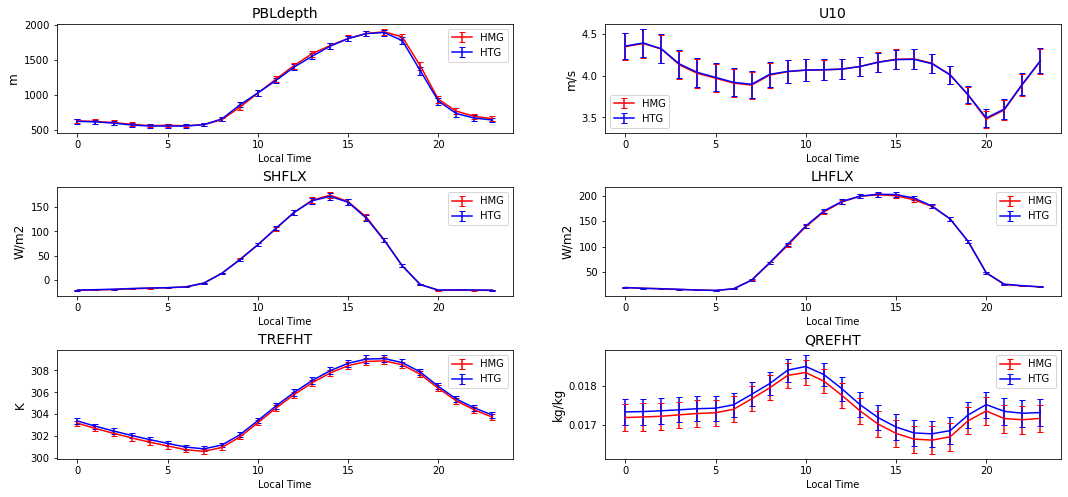

In [30]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
# ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                      fmt='r-',capsize=3,label='HMG')
    axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                      fmt='b-',capsize=3,label='HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        

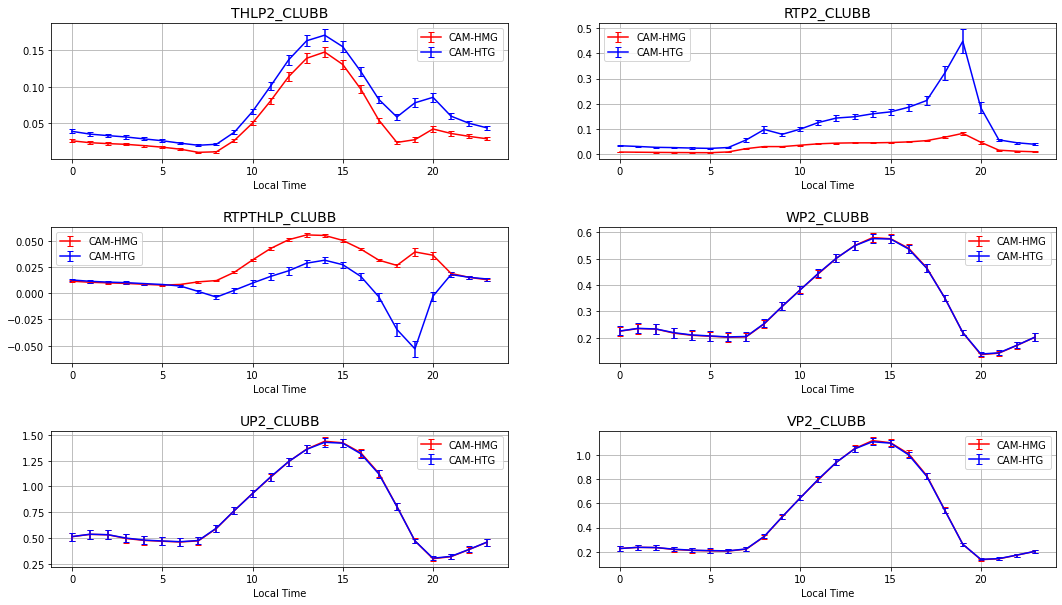

In [31]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
    
        

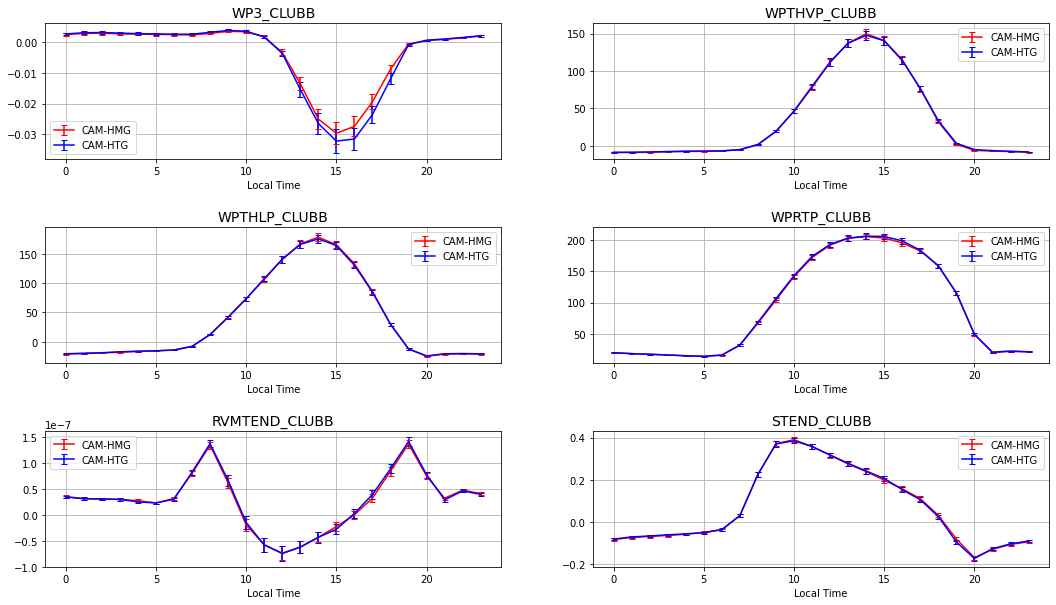

In [32]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
        

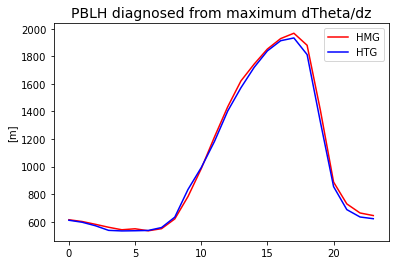

In [29]:
# plt.plot(hourlyMean_HMG.hour.values, hourlyMean_HMG.PBLdepth.values, 'r', label='HMG')
# plt.plot(hourlyMean_HTG.hour.values, hourlyMean_HTG.PBLdepth.values, 'b', label='HTG')
# # plt.title('PBLH diagnosed from maximum dQ/dz',fontsize=14)
# plt.title('PBLH diagnosed from maximum dTheta/dz',fontsize=14)
# plt.ylabel('[m]')
# plt.legend()


Text(0.5, 1.0, 'std(ET) from patch level')

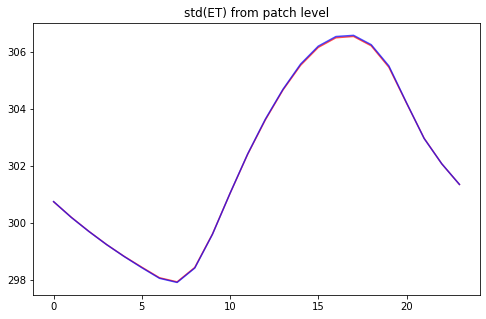

In [54]:
## Are there patches that have peaks in ET that might match above 

fig,axs = plt.subplots(1,1, figsize=(8,5))

axs.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMeanCLM_HMG['TSA'].values),
          'r-', alpha=0.7, label='CAM-HMG')
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['TSA'].values),
          'b-', alpha=0.7, label='CAM-HTG')

axs.set_title('std(ET) from patch level')


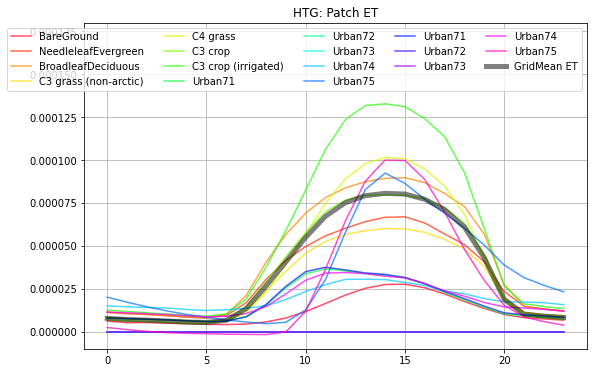

In [35]:
fig,axs = plt.subplots(1,1, figsize=(9,6))

# Control color of lines
num_plots = len(hourlyMeanCLMpatch_HTG.pft.values)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['ETtotal'].values[:, iPatch]),
            alpha=0.7, label=patchLabels[iPatch])
    
axs.plot(hourlyMean_HTG.hour.values, hourlyMeanCLM_HTG.QFLX_EVAP_TOT.values,'k-',linewidth=5,alpha=0.5, label='GridMean ET')

axs.set_title('HTG: Patch ET')
axs.legend(ncol=5)
axs.set_ylim([-0.00001, 0.00018])
axs.grid()



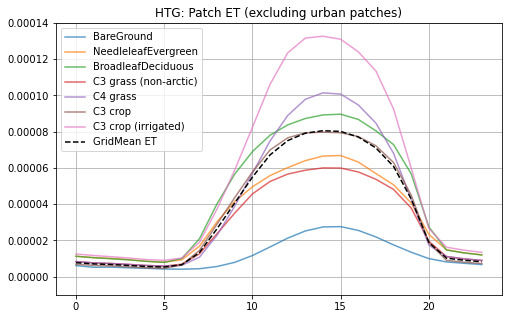

In [205]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)-10):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['ETtotal'].values[:, iPatch]),
            alpha=0.7, label=patchLabels[iPatch])
    
axs.plot(hourlyMean_HTG.hour.values, hourlyMeanCLM_HTG.QFLX_EVAP_TOT.values,'k--', label='GridMean ET')

axs.set_title('HTG: Patch ET (excluding urban patches)')
axs.legend()
axs.set_ylim([-0.00001, 0.00014])
axs.grid()


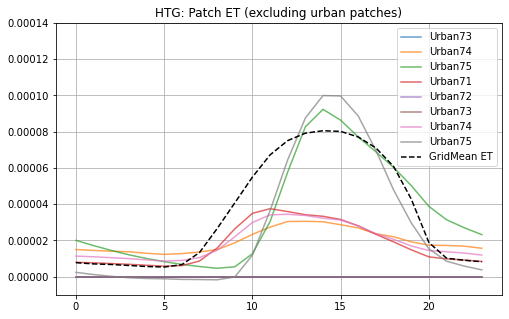

In [206]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch2 in range(len(hourlyMeanCLMpatch_HTG.pft.values)-9):
    iPatch = iPatch2+9
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['ETtotal'].values[:, iPatch]),
            alpha=0.7, label=patchLabels[iPatch])
axs.plot(hourlyMean_HTG.hour.values, hourlyMeanCLM_HTG.QFLX_EVAP_TOT.values,'k--', label='GridMean ET')

axs.set_title('HTG: Patch ET (excluding urban patches)')
axs.legend()
axs.set_ylim([-0.00001, 0.00014])
axs.grid()

# Urban71 = urban roof 
# Urban72 = urban sunwall
# Urban73 = urban shadewall
# Urban74 = impervious road
# Urban75 = pervious road

# NOTE: per CLM5 tech note section on urban model (2.15): 
#    "The canyon floor is divided into pervious (e.g., to represent residential lawns, parks) 
#     and impervious (e.g., to represent roads, parking lots, sidewalks) fractions.
#     Vegetation is not explicitly modeled for the pervious fraction; instead evaporation 
#     is parameterized by a simplified bulk scheme."


Text(0, 0.5, 'hPa')

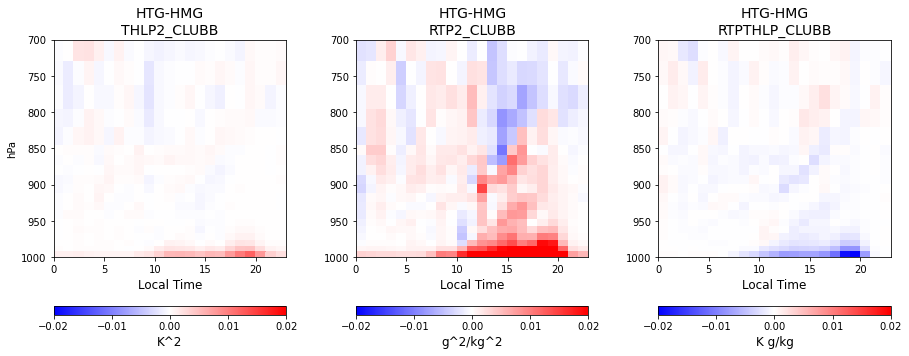

In [33]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze(diffVar.transpose()),
                             vmin=-0.02, vmax=0.02, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[ATM_varNames[iVar]].units,fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')


Text(0, 0.5, 'hPa')

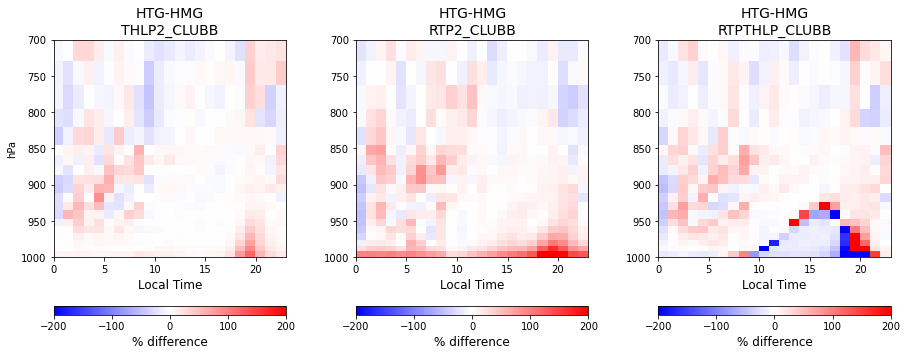

In [34]:
## Plot as percent difference rather than raw difference as above

fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-200, vmax=200, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

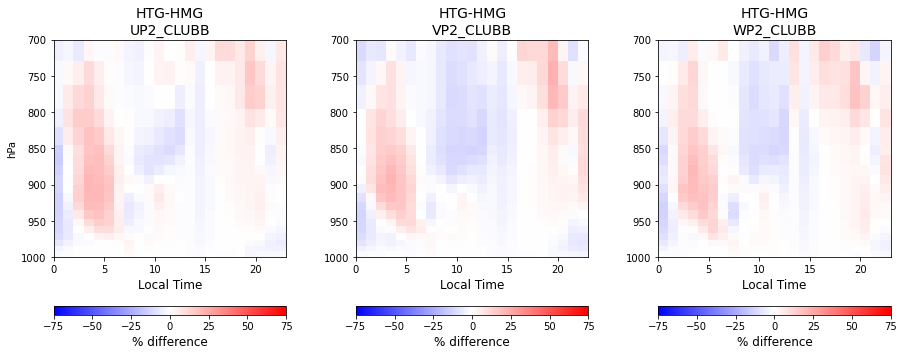

In [35]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-75, vmax=75, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

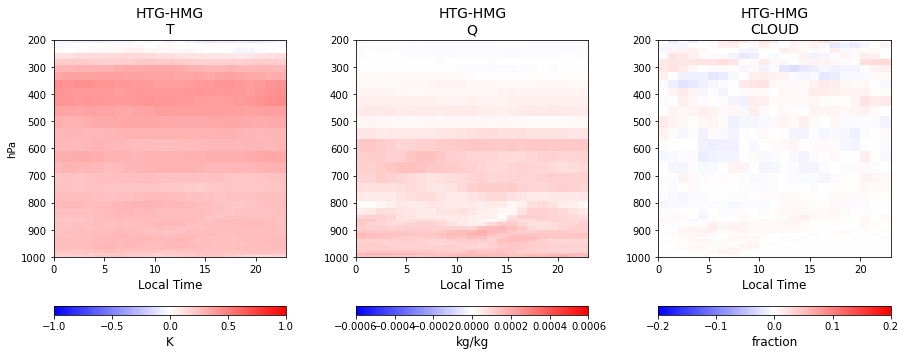

In [36]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['T','Q','CLOUD'])

cMin = np.asarray([-1, -0.0006, -0.2])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze(diffVar.transpose()),
                             vmin=cMin[iVar], vmax=-cMin[iVar], cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[ATM_varNames[iVar]].units,fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,200])

axs[0].set_ylabel('hPa')



#### Bin by some controlling variable (i.e., precip or soil moisture along x axis), then plot profiles of different things that way

In [130]:
def binByVar_plotProfiles(bins, controlVar, respondVar, startHr, endHr, cmin):
    
    # Select which levels array to use
    if np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.ilev.values): 
        nLevs  = len(HTGcamDS_local.ilev.values)
        levSel = 'ilev'
    elif np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.lev.values):
        nLevs  = len(HTGcamDS_local.lev.values)
        levSel = 'lev'

    binnedRespondVar_HTG = np.full([len(bins)+1,24,nLevs], np.nan)
    binnedRespondVar_HMG = np.full([len(bins)+1,24,nLevs], np.nan)

    ## Get binned data
    for iBin in range(len(bins)+1):
        if iBin==0:
            selBinHTG = np.where(HTGclmDS_local[controlVar].values<bins[0])[0]
            selBinHMG = np.where(HMGclmDS_local[controlVar].values<bins[0])[0]
        elif iBin==len(SMbins):
            selBinHTG = np.where(HTGclmDS_local[controlVar].values>=bins[-1])[0]
            selBinHMG = np.where(HMGclmDS_local[controlVar].values>=bins[-1])[0]
        else: 
            selBinHTG = np.where( (HTGclmDS_local[controlVar].values>=bins[iBin-1]) &
                                  (HTGclmDS_local[controlVar].values<bins[iBin]) )[0]
            selBinHMG = np.where( (HMGclmDS_local[controlVar].values>=bins[iBin-1]) &
                                  (HMGclmDS_local[controlVar].values<bins[iBin]) )[0]

        # Now select the DS for that SM bin: 
        HTGcamDS_local_SMbin = HTGcamDS_local.isel(time=selBinHTG)
        HTGclmDS_local_SMbin = HTGclmDS_local.isel(time=selBinHTG)

        HMGcamDS_local_SMbin = HMGcamDS_local.isel(time=selBinHMG)
        HMGclmDS_local_SMbin = HMGclmDS_local.isel(time=selBinHMG)

        # Get mean values as function of hour of day
        hourlyMean_selBin_HTG = HTGcamDS_local_SMbin.groupby("time.hour").mean()
        hourlyMean_selBin_HMG = HMGcamDS_local_SMbin.groupby("time.hour").mean()

        binnedRespondVar_HTG[iBin,hourlyMean_selBin_HTG.hour.values,:] = np.squeeze(hourlyMean_selBin_HTG[respondVar])
        binnedRespondVar_HMG[iBin,hourlyMean_selBin_HMG.hour.values,:] = np.squeeze(hourlyMean_selBin_HMG[respondVar])

    ## Plot binned data as mean over some period of day    
    binnedRespondVar_HTG_timeSel = np.nanmean(binnedRespondVar_HTG[:,startHr:endHr+1,:], axis=1)
    binnedRespondVar_HMG_timeSel = np.nanmean(binnedRespondVar_HMG[:,startHr:endHr+1,:], axis=1)

    ## Now do the plotting
    binRes = bins[2]-bins[1]
    binEdges = np.insert(bins, 0, bins[0]-binRes)
    binEdges = np.append(binEdges, bins[-1]+binRes)
    
    diffVar = binnedRespondVar_HTG_timeSel - binnedRespondVar_HMG_timeSel
    
    fig,axs = plt.subplots(1,1, figsize=(16,8))
    contour_plot = axs.pcolormesh(binEdges, HTGcamDS_local[levSel].values, diffVar.transpose(),
                                 vmin=cmin, vmax=-cmin, cmap='bwr')
    # Add colorbar 
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[respondVar].units,fontsize=12)

    # Control x ticks
    tick_labels = np.round(binEdges,2).astype(str)
    tick_labels[0]  = '<'+str(bins[0])
    tick_labels[-1] = '>'+str(bins[-1])
    axs.set_xticks(binEdges)
    axs.set_xticklabels(tick_labels)
    
    axs.invert_yaxis()
    axs.set_xlabel(controlVar+' bin ['+HMGclmDS_local[controlVar].units+']')
    axs.set_ylabel('hPa')
    axs.set_title('HTG-HMG\n'+respondVar+' (Mean over hours '+str(startHr)+'-'+str(endHr)+')')

    plt.show()
    
    return(levSel)

In [131]:
def binByVarDiff_plotProfiles(bins, controlVar, respondVar, startHr, endHr, cmin):
    
    # Select which levels array to use
    if np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.ilev.values): 
        nLevs  = len(HTGcamDS_local.ilev.values)
        levSel = 'ilev'
    elif np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.lev.values):
        nLevs  = len(HTGcamDS_local.lev.values)
        levSel = 'lev'

    # Get difference between controlVar in HTG and HMG (does sign matter?)
    diffCtrlVar = np.abs(HTGclmDS_local[controlVar].values - HMGclmDS_local[controlVar].values)

    # Now bin those differences 
    binnedRespondVar_HTG = np.full([len(bins)+1,24,nLevs], np.nan)
    binnedRespondVar_HMG = np.full([len(bins)+1,24,nLevs], np.nan)

    ## Get binned data
    for iBin in range(len(bins)+1):
        if iBin==0:
            selBinHTG = np.where(diffCtrlVar<bins[0])[0]
        elif iBin==len(SMbins):
            selBinHTG = np.where(diffCtrlVar>=bins[-1])[0]
        else: 
            selBinHTG = np.where( (diffCtrlVar>=bins[iBin-1]) &
                                  (diffCtrlVar<bins[iBin]) )[0]

        if len(selBinHTG>0):
            # Now select the DS for that SM bin: 
            HTGcamDS_local_SMbin = HTGcamDS_local.isel(time=selBinHTG)
            HTGclmDS_local_SMbin = HTGclmDS_local.isel(time=selBinHTG)

            HMGcamDS_local_SMbin = HMGcamDS_local.isel(time=selBinHTG)
            HMGclmDS_local_SMbin = HMGclmDS_local.isel(time=selBinHTG)

            # Get mean values as function of hour of day
            hourlyMean_selBin_HTG = HTGcamDS_local_SMbin.groupby("time.hour").mean()
            hourlyMean_selBin_HMG = HMGcamDS_local_SMbin.groupby("time.hour").mean()

            binnedRespondVar_HTG[iBin,hourlyMean_selBin_HTG.hour.values,:] = np.squeeze(hourlyMean_selBin_HTG[respondVar])
            binnedRespondVar_HMG[iBin,hourlyMean_selBin_HMG.hour.values,:] = np.squeeze(hourlyMean_selBin_HMG[respondVar])
        else: 
            binnedRespondVar_HTG[iBin,:,:] = np.nan
            binnedRespondVar_HMG[iBin,:,:] = np.nan



    ## Plot binned data as mean over some period of day    
    binnedRespondVar_HTG_timeSel = np.nanmean(binnedRespondVar_HTG[:,startHr:endHr+1,:], axis=1)
    binnedRespondVar_HMG_timeSel = np.nanmean(binnedRespondVar_HMG[:,startHr:endHr+1,:], axis=1)

    ## Now do the plotting
    binRes = bins[2]-bins[1]
    binEdges = np.insert(bins, 0, bins[0]-binRes)
    binEdges = np.append(binEdges, bins[-1]+binRes)
    
    diffVar = binnedRespondVar_HTG_timeSel - binnedRespondVar_HMG_timeSel
    
    fig,axs = plt.subplots(1,1, figsize=(16,8))
    contour_plot = axs.pcolormesh(binEdges, HTGcamDS_local[levSel].values, diffVar.transpose(),
                                 vmin=cmin, vmax=-cmin, cmap='bwr')
    # Add colorbar 
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[respondVar].units,fontsize=12)

    # Control x ticks
    tick_labels = np.round(binEdges,2).astype(str)
    tick_labels[0]  = '<'+str(bins[0])
    tick_labels[-1] = '>'+str(bins[-1])
    axs.set_xticks(binEdges)
    axs.set_xticklabels(tick_labels)
    
    axs.invert_yaxis()
    axs.set_xlabel(controlVar+' (|HTG-HMG|) ['+HMGclmDS_local[controlVar].units+']')
    axs.set_ylabel('hPa')
    axs.set_title('HTG-HMG\n'+respondVar+' (Mean over hours '+str(startHr)+'-'+str(endHr)+')')

    plt.show()
    
    return(levSel)

(array([1521., 1079.,  764., 1066.,  955., 1346., 1075., 1294., 1055.,
         830., 1006., 1151., 1023.,  765.,  755.,  694.,  533.,  472.,
         418.,  322.,  276.,  160.,   89.,   77.]),
 array([15.        , 16.04166667, 17.08333333, 18.125     , 19.16666667,
        20.20833333, 21.25      , 22.29166667, 23.33333333, 24.375     ,
        25.41666667, 26.45833333, 27.5       , 28.54166667, 29.58333333,
        30.625     , 31.66666667, 32.70833333, 33.75      , 34.79166667,
        35.83333333, 36.875     , 37.91666667, 38.95833333, 40.        ]),
 <BarContainer object of 24 artists>)

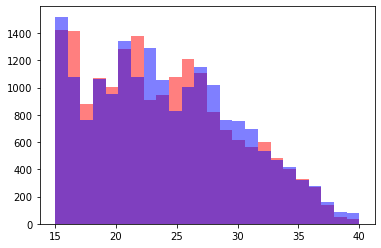

In [71]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
plt.hist(HMGclmDS_local[controlVar], bins=SMbins, facecolor='r',alpha=0.5,label='HMG')
plt.hist(HTGclmDS_local[controlVar], bins=SMbins, facecolor='b',alpha=0.5,label='HTG')


(array([4.371e+03, 2.750e+03, 2.528e+03, 1.850e+03, 1.580e+03, 7.660e+02,
        7.510e+02, 9.610e+02, 8.860e+02, 8.090e+02, 5.490e+02, 3.940e+02,
        1.810e+02, 1.510e+02, 1.190e+02, 5.300e+01, 3.800e+01, 2.000e+01,
        5.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 0.000e+00]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
        1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
        2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
        3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ]),
 <BarContainer object of 24 artists>)

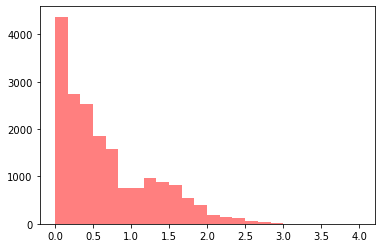

In [81]:
SMbins     = np.linspace(0, 4, 25)
controlVar = 'SOILWATER_10CM'
plt.hist(np.abs(HTGclmDS_local[controlVar]-HMGclmDS_local[controlVar]), bins=SMbins, facecolor='r',alpha=0.5,label='HMG')


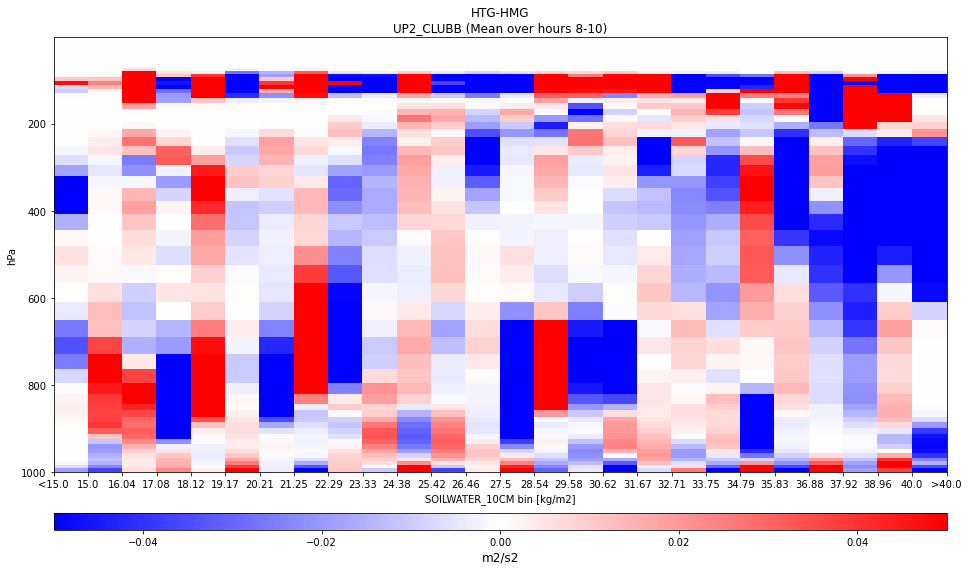

'ilev'

In [560]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'UP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


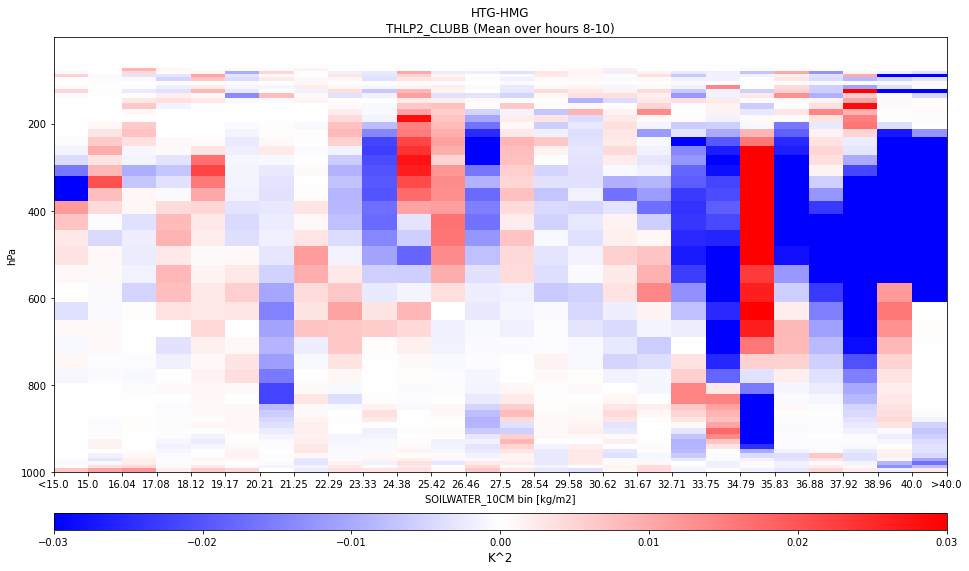

'ilev'

In [566]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'THLP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.03

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)



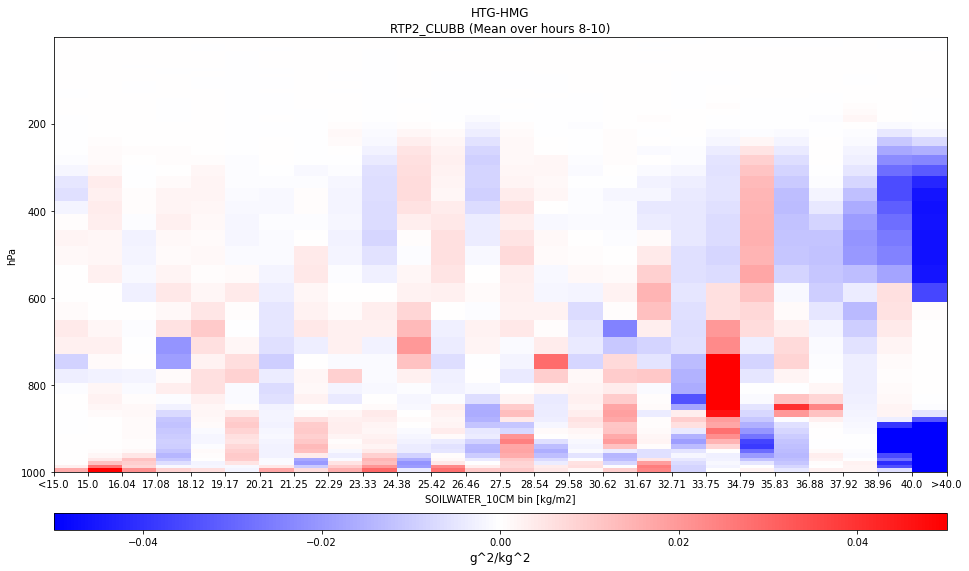

'ilev'

In [567]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'RTP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


**But maybe the bigger interest is where the HTG and HMG control values really diverge...**

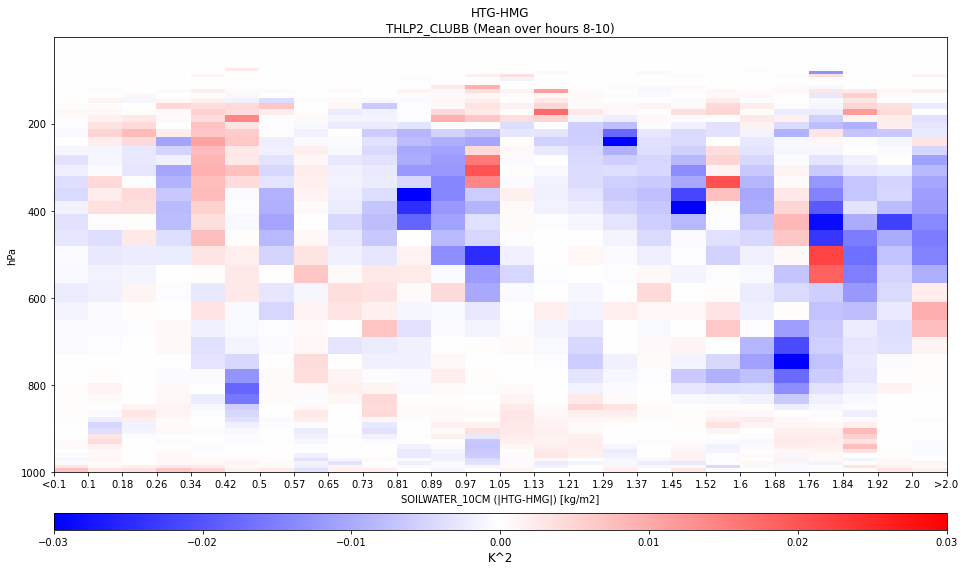

'ilev'

In [100]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'THLP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.03

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


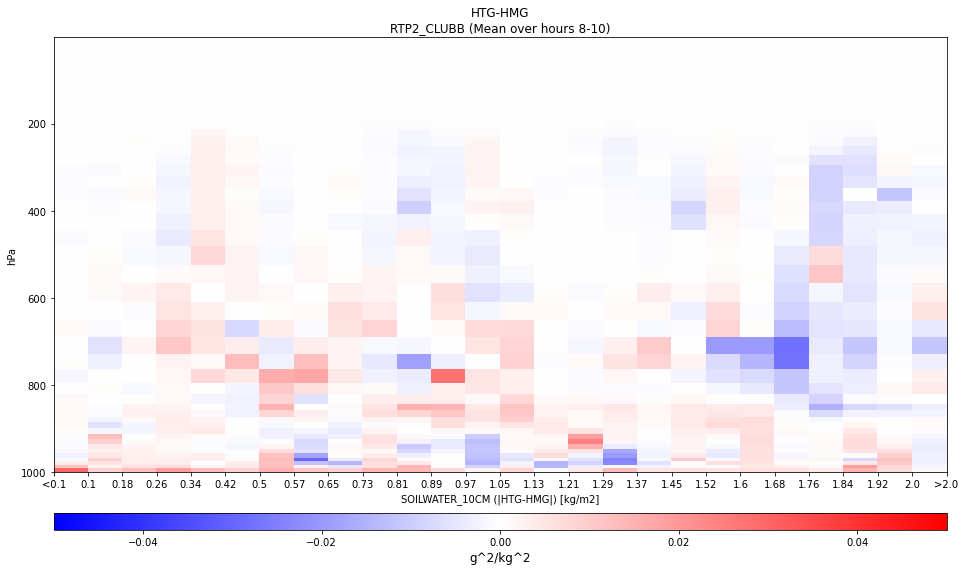

'ilev'

In [101]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'RTP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)

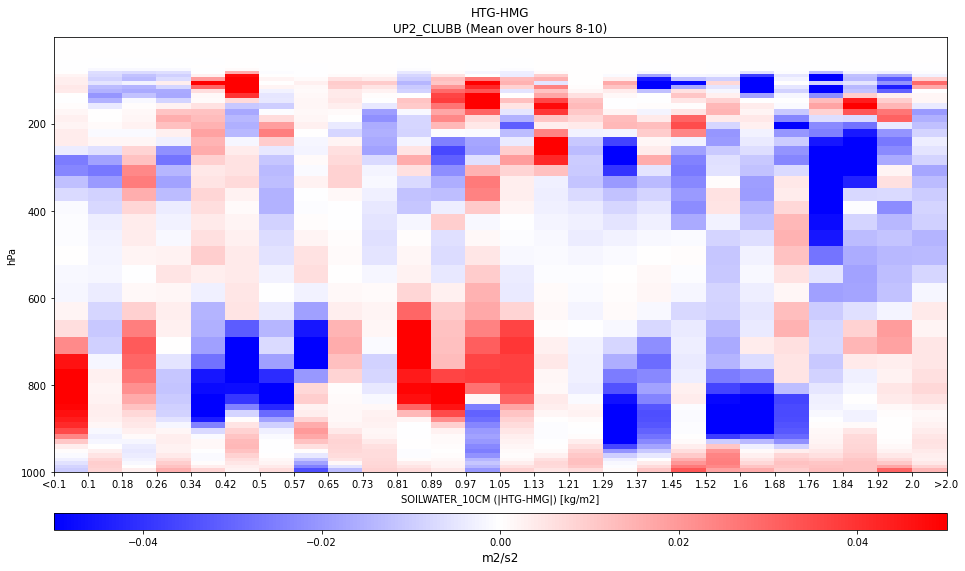

'ilev'

In [102]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'UP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)

**Would this all view better with actual profiles??** <br>
*Use DAILY MEANS*

In [60]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


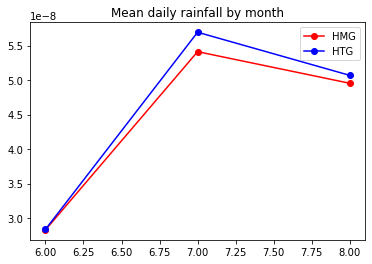

In [87]:
# June mean rain: 
iJune = np.where((HMGcamDS_local["time.year"].values>=2015) & 
                 (HMGcamDS_local["time.year"].values<=2016) & 
                 (HMGcamDS_local["time.month"].values==6))[0]
iJuly = np.where((HMGcamDS_local["time.year"].values>=2015) & 
                 (HMGcamDS_local["time.year"].values<=2016) & 
                 (HMGcamDS_local["time.month"].values==7))[0]
iAug  = np.where((HMGcamDS_local["time.year"].values>=2015) & 
                 (HMGcamDS_local["time.year"].values<=2016) & 
                 (HMGcamDS_local["time.month"].values==8))[0]

HMGrain_june = np.nanmean(HMGcamDS_local.PRECT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_local.PRECT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_local.PRECT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_local.PRECT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_local.PRECT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_local.PRECT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.legend(['HMG','HTG'])

(1.0, 6.0)

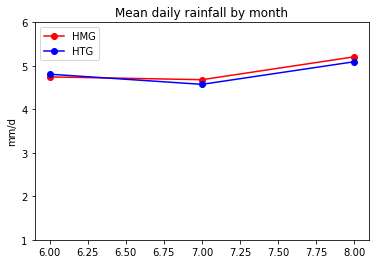

In [103]:
# June mean rain: 
iJune = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2018) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==6))[0]
iJuly = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2018) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==7))[0]
iAug  = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2018) & 
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==8))[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.ylabel('mm/d')
plt.legend(['HMG','HTG'])

plt.ylim([1, 6])

In [104]:
# So what if we take, say, percentiles of a controlVar 
controlVar = 'SOILWATER_10CM'
# controlVar = 'stdET'
pctSel     = np.arange(10,100,10) 

HTG_pctCtrlValues = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSel)
HMG_pctCtrlValues = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSel)

pctSelThirds     = np.asarray([33.33, 66.66]) 
HTG_pctCtrlValuesThirds = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSelThirds)
HMG_pctCtrlValuesThirds = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSelThirds)

# ## controlVar in CAM
# controlVar = 'PRECTdailySum'
# pctSel     = np.arange(10,100,10) 

# HTG_pctCtrlValues = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSel)
# HMG_pctCtrlValues = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSel)

# pctSelThirds     = np.asarray([33.33, 66.66]) 
# HTG_pctCtrlValuesThirds = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSelThirds)
# HMG_pctCtrlValuesThirds = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSelThirds)


In [105]:
## Maybe we do want consistent bin definitions, at least? 
binSelSame = np.full([len(pctSel)], np.nan)
for iBin in range(len(pctSel)):
    binSelSame[iBin] = np.nanmean([HTG_pctCtrlValues[iBin], HMG_pctCtrlValues[iBin]])
    
## Maybe we do want consistent bin definitions, at least? 
# for Thirds...
binSelSameThirds = np.full([len(pctSelThirds)], np.nan)
for iBin in range(len(pctSelThirds)):
    binSelSameThirds[iBin] = np.nanmean([HTG_pctCtrlValuesThirds[iBin], HMG_pctCtrlValuesThirds[iBin]])

print('Bottom third cutoff: %.2f' % (binSelSameThirds[0]))
print('Top third cutoff: %.2f' % (binSelSameThirds[1]))  

Bottom third cutoff: 20.00
Top third cutoff: 26.17


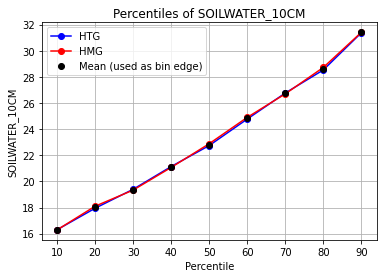

In [106]:
plt.plot(pctSel, HTG_pctCtrlValues, 'b-o', label='HTG')
plt.plot(pctSel, HMG_pctCtrlValues, 'r-o', label='HMG')
plt.plot(pctSel, binSelSame, 'ko', label='Mean (used as bin edge)')
plt.xlabel('Percentile')
plt.ylabel(controlVar)
plt.title('Percentiles of '+controlVar)
plt.legend()
plt.grid()

Now isolate arrays that correspond to those percentiles...

In [107]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnPercentile(fullDS, pctDS):
    iTimes = []
    
    for iTime in range(len(pctDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==pctDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==pctDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==pctDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayPct = fullDS.isel(time=iTimes)
    
    return(DS_dayPct)


In [108]:
# Now get all the times where daily mean controlVar falls into each bin

binSel = binSelSame
# binSel = HTG_pctCtrlValues
HTGbin0 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin1 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[0]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[1]))[0]
HTGbin2 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[1]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[2]))[0]
HTGbin3 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[2]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[3]))[0]
HTGbin4 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[3]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[4]))[0]
HTGbin5 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[4]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[5]))[0]
HTGbin6 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[5]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[6]))[0]
HTGbin7 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[6]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[7]))[0]
HTGbin8 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[7]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[8]))[0]
HTGbin9 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[8]))[0]


binSel = binSelSame
# binSel = HMG_pctCtrlValues
HMGbin0 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]  # bin 0=10th pct
HMGbin1 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[0]) &    # bin 10-20th pct
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[1]))[0]
HMGbin2 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[1]) &    #20-30
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[2]))[0]
HMGbin3 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[2]) &    #30-40
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[3]))[0]
HMGbin4 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[3]) &    #40-50
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[4]))[0]
HMGbin5 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[4]) &    #50-60
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[5]))[0] 
HMGbin6 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[5]) &    #60-70
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[6]))[0]
HMGbin7 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[6]) &    #70-80
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[7]))[0]
HMGbin8 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[7]) &    #80-90
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[8]))[0]
HMGbin9 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[8]))[0]  #90-100


binSel = binSelSameThirds
HMGbin_bot30 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HMGbin_top30 = np.where((HMGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]

HTGbin_bot30 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin_top30 = np.where((HTGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]


In [462]:
# ## ControlVar in CAM 

# binSel = binSelSame
# # binSel = HTG_pctCtrlValues
# HTGbin0 = np.where((HTGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HTGbin1 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[0]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[1]))[0]
# HTGbin2 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[1]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[2]))[0]
# HTGbin3 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[2]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[3]))[0]
# HTGbin4 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[3]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[4]))[0]
# HTGbin5 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[4]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[5]))[0]
# HTGbin6 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[5]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[6]))[0]
# HTGbin7 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[6]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[7]))[0]
# HTGbin8 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[7]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[8]))[0]
# HTGbin9 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[8]))[0]


# binSel = binSelSame
# # binSel = HMG_pctCtrlValues
# HMGbin0 = np.where((HMGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HMGbin1 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[0]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[1]))[0]
# HMGbin2 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[1]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[2]))[0]
# HMGbin3 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[2]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[3]))[0]
# HMGbin4 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[3]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[4]))[0]
# HMGbin5 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[4]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[5]))[0]
# HMGbin6 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[5]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[6]))[0]
# HMGbin7 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[6]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[7]))[0]
# HMGbin8 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[7]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[8]))[0]
# HMGbin9 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[8]))[0]

# binSel = binSelSameThirds
# HMGbin_bot30 = np.where((HMGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HMGbin_top30 = np.where((HMGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]

# HTGbin_bot30 = np.where((HTGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HTGbin_top30 = np.where((HTGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]


In [326]:
## Check how well days agree between HMG/HTG bins


A = HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0).year_month_day.values
B = HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0).year_month_day.values

print('HTG day            HMG day')
for iDay in range(len(HTGbin0)):
    print(A[iDay],'     ',B[iDay])


HTG day            HMG day
(2015, 6, 16)       (2015, 6, 15)
(2015, 7, 7)       (2015, 6, 16)
(2015, 7, 9)       (2015, 7, 8)
(2015, 7, 21)       (2015, 7, 9)
(2015, 7, 30)       (2015, 7, 21)
(2015, 8, 5)       (2015, 7, 30)
(2015, 8, 18)       (2015, 8, 5)
(2015, 8, 22)       (2015, 8, 18)
(2015, 8, 23)       (2015, 8, 22)
(2015, 8, 24)       (2015, 8, 23)
(2016, 6, 2)       (2015, 8, 24)
(2016, 6, 13)       (2016, 6, 2)
(2016, 6, 14)       (2016, 6, 13)
(2016, 6, 16)       (2016, 6, 14)
(2016, 7, 9)       (2016, 7, 2)
(2016, 7, 15)       (2016, 7, 9)
(2016, 7, 30)       (2016, 7, 15)
(2016, 7, 31)       (2016, 7, 28)
(2016, 8, 6)       (2016, 7, 31)
(2016, 8, 9)       (2016, 8, 7)
(2016, 8, 13)       (2016, 8, 9)
(2016, 8, 27)       (2016, 8, 26)
(2017, 6, 2)       (2016, 8, 27)
(2017, 6, 4)       (2017, 6, 2)
(2017, 7, 4)       (2017, 7, 4)
(2017, 8, 10)       (2017, 8, 26)
(2017, 8, 28)       (2017, 8, 28)


In [109]:
## Now get those days out of full arrays
HTGclm_10pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGclm_20pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGclm_30pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGclm_40pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGclm_50pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGclm_60pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGclm_70pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGclm_80pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGclm_90pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGclm_100pct = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGclm_10pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGclm_20pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGclm_30pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGclm_40pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGclm_50pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGclm_60pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGclm_70pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGclm_80pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGclm_90pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGclm_100pct = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin9))



HTGcam_10pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGcam_20pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGcam_30pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGcam_40pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGcam_50pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGcam_60pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGcam_70pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGcam_80pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGcam_90pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGcam_100pct = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGcam_10pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGcam_20pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGcam_30pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGcam_40pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGcam_50pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGcam_60pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGcam_70pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGcam_80pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGcam_90pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGcam_100pct = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9))


In [110]:
HMGcam_bot30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_bot30))
HMGclm_bot30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin_bot30))

HTGcam_bot30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_bot30))
HTGclm_bot30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin_bot30))


HMGcam_top30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_top30))
HMGclm_top30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin_top30))

HTGcam_top30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_top30))
HTGclm_top30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin_top30))


**What if we look at a few bins for their average daily response**

In [111]:
hourlyMean10_HTG  = HTGcam_10pct.groupby("time.hour").mean()
hourlyMean20_HTG  = HTGcam_20pct.groupby("time.hour").mean()
hourlyMean30_HTG  = HTGcam_30pct.groupby("time.hour").mean()
hourlyMean40_HTG  = HTGcam_40pct.groupby("time.hour").mean()
hourlyMean50_HTG  = HTGcam_50pct.groupby("time.hour").mean()
hourlyMean60_HTG  = HTGcam_60pct.groupby("time.hour").mean()
hourlyMean70_HTG  = HTGcam_70pct.groupby("time.hour").mean()
hourlyMean80_HTG  = HTGcam_80pct.groupby("time.hour").mean()
hourlyMean90_HTG  = HTGcam_90pct.groupby("time.hour").mean()
hourlyMean100_HTG = HTGcam_100pct.groupby("time.hour").mean()

hourlyMean10_HMG  = HMGcam_10pct.groupby("time.hour").mean()
hourlyMean20_HMG  = HMGcam_20pct.groupby("time.hour").mean()
hourlyMean30_HMG  = HMGcam_30pct.groupby("time.hour").mean()
hourlyMean40_HMG  = HMGcam_40pct.groupby("time.hour").mean()
hourlyMean50_HMG  = HMGcam_50pct.groupby("time.hour").mean()
hourlyMean60_HMG  = HMGcam_60pct.groupby("time.hour").mean()
hourlyMean70_HMG  = HMGcam_70pct.groupby("time.hour").mean()
hourlyMean80_HMG  = HMGcam_80pct.groupby("time.hour").mean()
hourlyMean90_HMG  = HMGcam_90pct.groupby("time.hour").mean()
hourlyMean100_HMG = HMGcam_100pct.groupby("time.hour").mean()



In [112]:
hourlyMeanBot30_HTG = HTGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HTG = HTGcam_top30.groupby("time.hour").mean()

hourlyMeanBot30_HMG = HMGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HMG = HMGcam_top30.groupby("time.hour").mean()


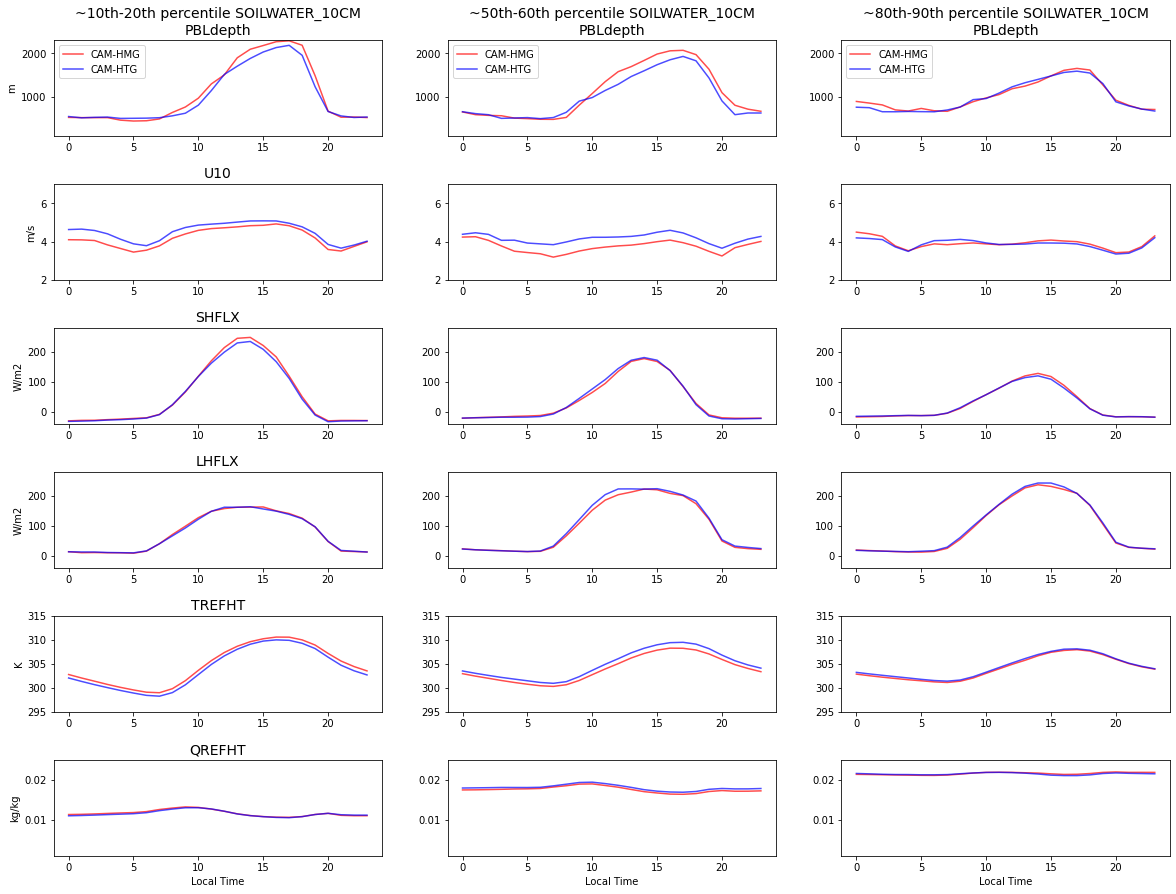

In [39]:
fig,axs = plt.subplots(6,3, figsize=(20,15))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

yMax = np.asarray([2300, 7, 280, 280, 315, 0.025])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.001])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMean20_HMG.hour.values, np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMean20_HTG.hour.values, np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMean60_HMG.hour.values, np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMean60_HTG.hour.values, np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 80th-90th percentile bin 
    axs[iPlot+2].plot(hourlyMean90_HMG.hour.values, np.squeeze(hourlyMean90_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+2].plot(hourlyMean90_HTG.hour.values, np.squeeze(hourlyMean90_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+2].set_ylim([yMin[iVar], yMax[iVar]])
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
        axs[iPlot+2].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
        

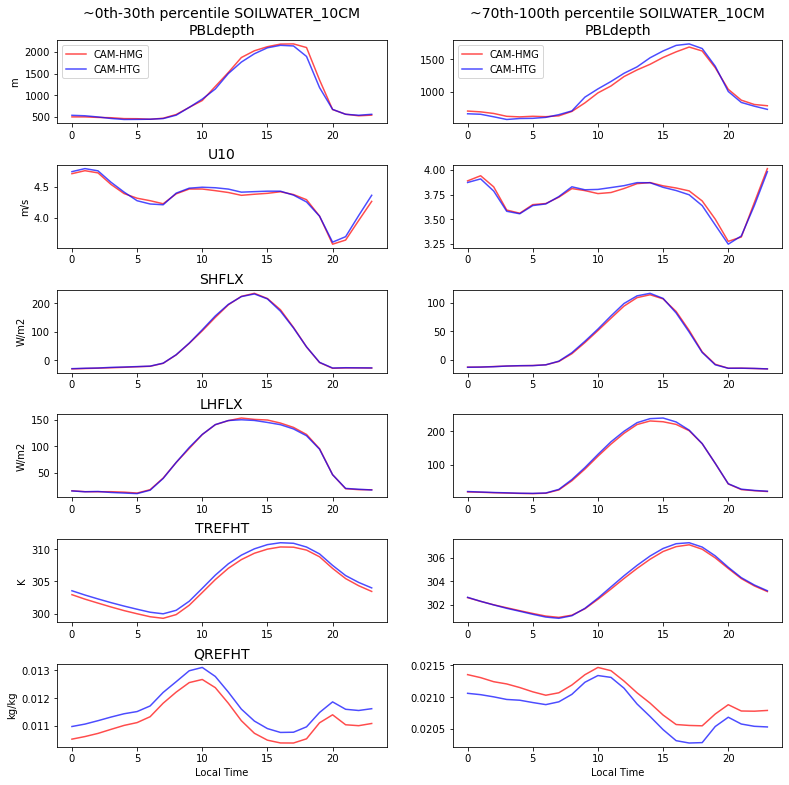

In [49]:
fig,axs = plt.subplots(6,2, figsize=(13,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

yMax = np.asarray([2400, 7, 300, 300, 315, 0.022])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.012])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

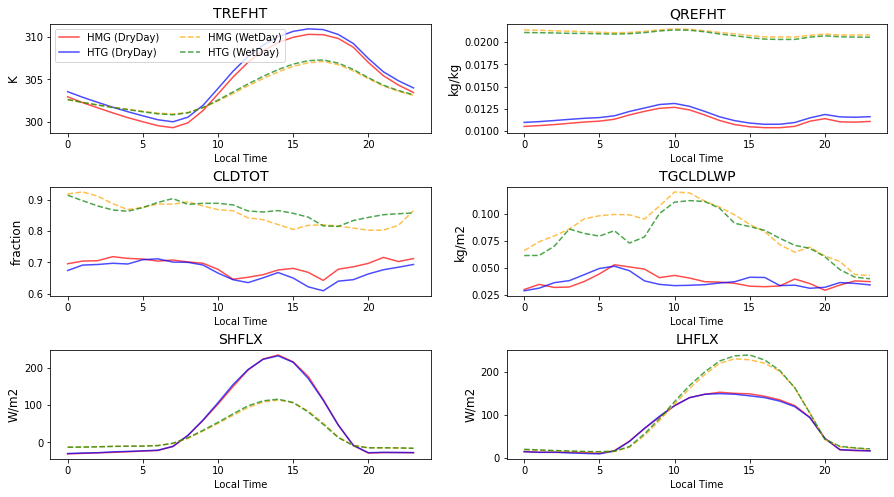

In [40]:
fig,axs = plt.subplots(3,2, figsize=(15,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
ATM_varNames = np.asarray(['TREFHT','QREFHT','CLDTOT','TGCLDLWP','SHFLX','LHFLX'])

for iVar in range(6):       
    axs[iVar].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='HMG (DryDay)')
    axs[iVar].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='HTG (DryDay)')
    
    axs[iVar].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  '--',color='orange', alpha=0.7, label='HMG (WetDay)')
    axs[iVar].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  '--',color='g', alpha=0.7, label='HTG (WetDay)')
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        
axs[0].legend(ncol=2)


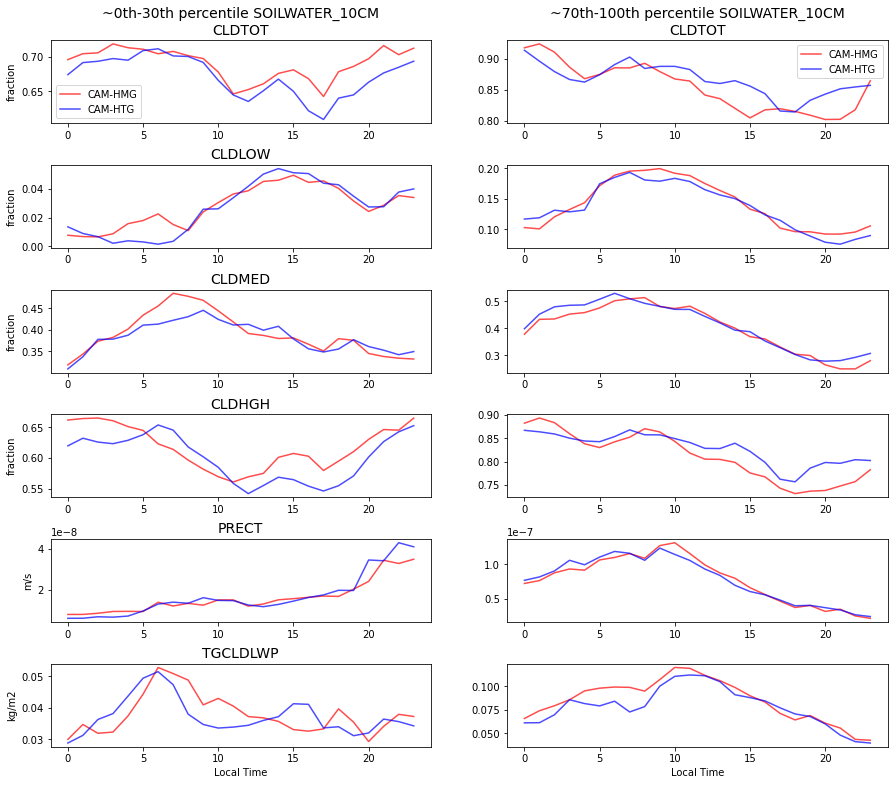

In [51]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['CLDTOT','CLDLOW','CLDMED','CLDHGH','PRECT','TGCLDLWP'])

yMax = np.asarray([2300, 7, 300, 300, 315, 0.025])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.001])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

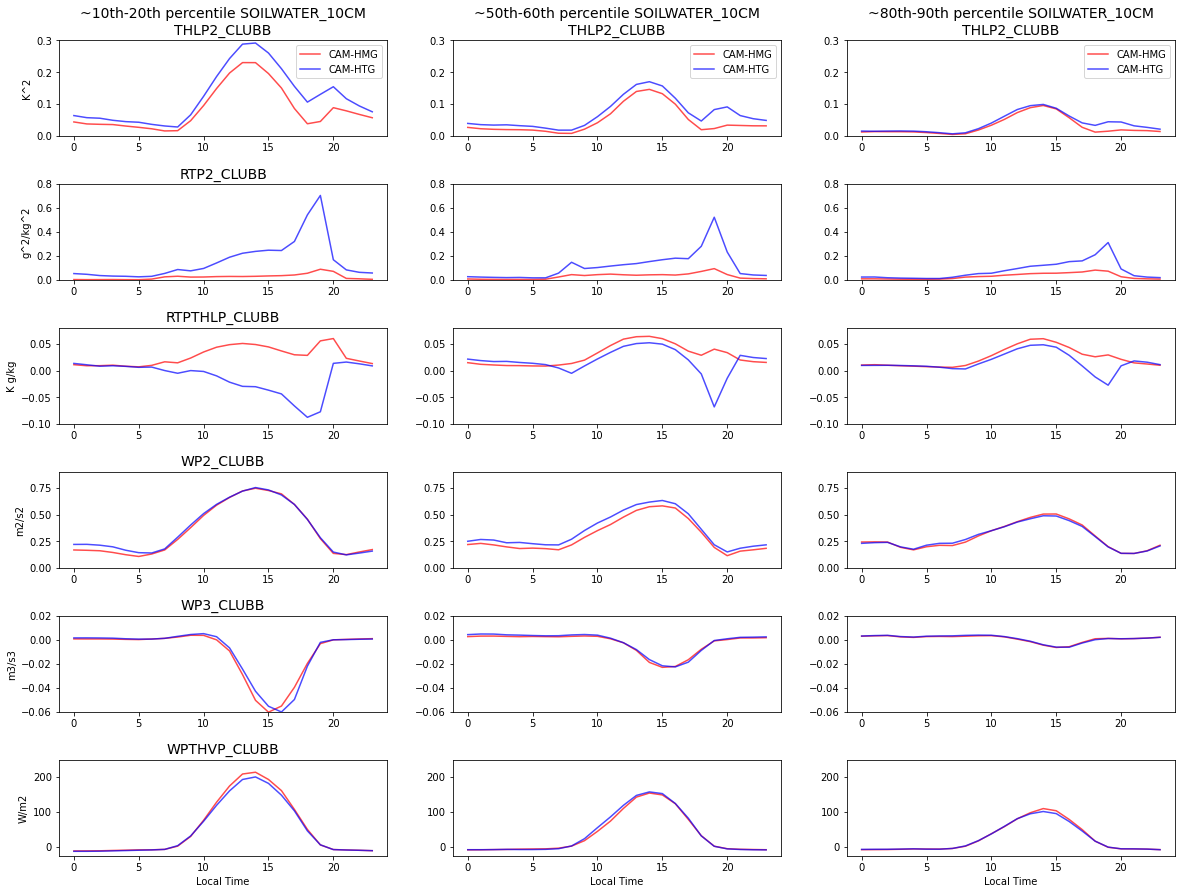

In [401]:
fig,axs = plt.subplots(6,3, figsize=(20,15))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
ylimMax = np.asarray([0.3, 0.8,  0.08, 0.9,  0.02, 250])
ylimMin = np.asarray([0.0, 0.0, -0.10, 0.0, -0.06, -25])

iPlot = 0
for iVar in range(6): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMean20_HMG.hour.values, np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMean20_HTG.hour.values, np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMean60_HMG.hour.values, np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMean60_HTG.hour.values, np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+1].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 80th-90th percentile bin 
    axs[iPlot+2].plot(hourlyMean90_HMG.hour.values, np.squeeze(hourlyMean90_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+2].plot(hourlyMean90_HTG.hour.values, np.squeeze(hourlyMean90_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+2].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
        axs[iPlot+2].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
    

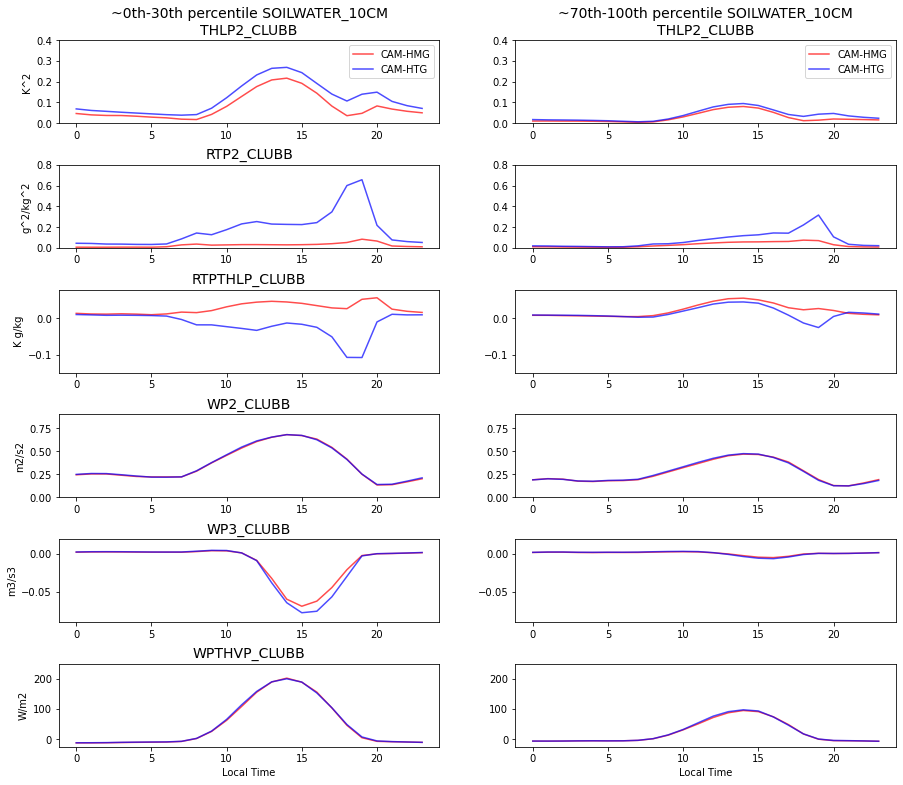

In [52]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
ylimMax = np.asarray([0.4, 0.8,  0.08, 0.9,  0.02, 250])
ylimMin = np.asarray([0.0, 0.0, -0.15, 0.0, -0.09, -25])

iPlot = 0
for iVar in range(6): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+1].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')

    
    iPlot = iPlot+2
    

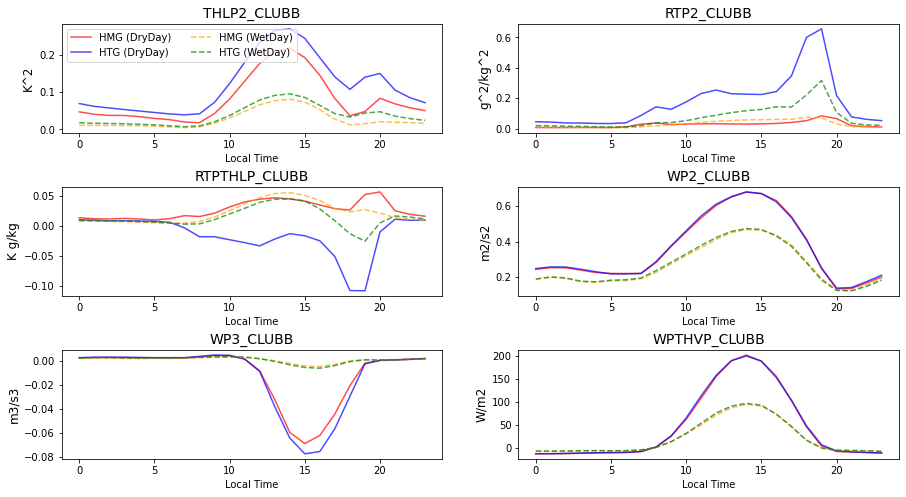

In [53]:
fig,axs = plt.subplots(3,2, figsize=(15,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])


for iVar in range(6):     
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    
    axs[iVar].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='HMG (DryDay)')
    axs[iVar].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='HTG (DryDay)')
    
    axs[iVar].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  '--',color='orange', alpha=0.7, label='HMG (WetDay)')
    axs[iVar].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  '--',color='g', alpha=0.7, label='HTG (WetDay)')
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        
axs[0].legend(ncol=2)



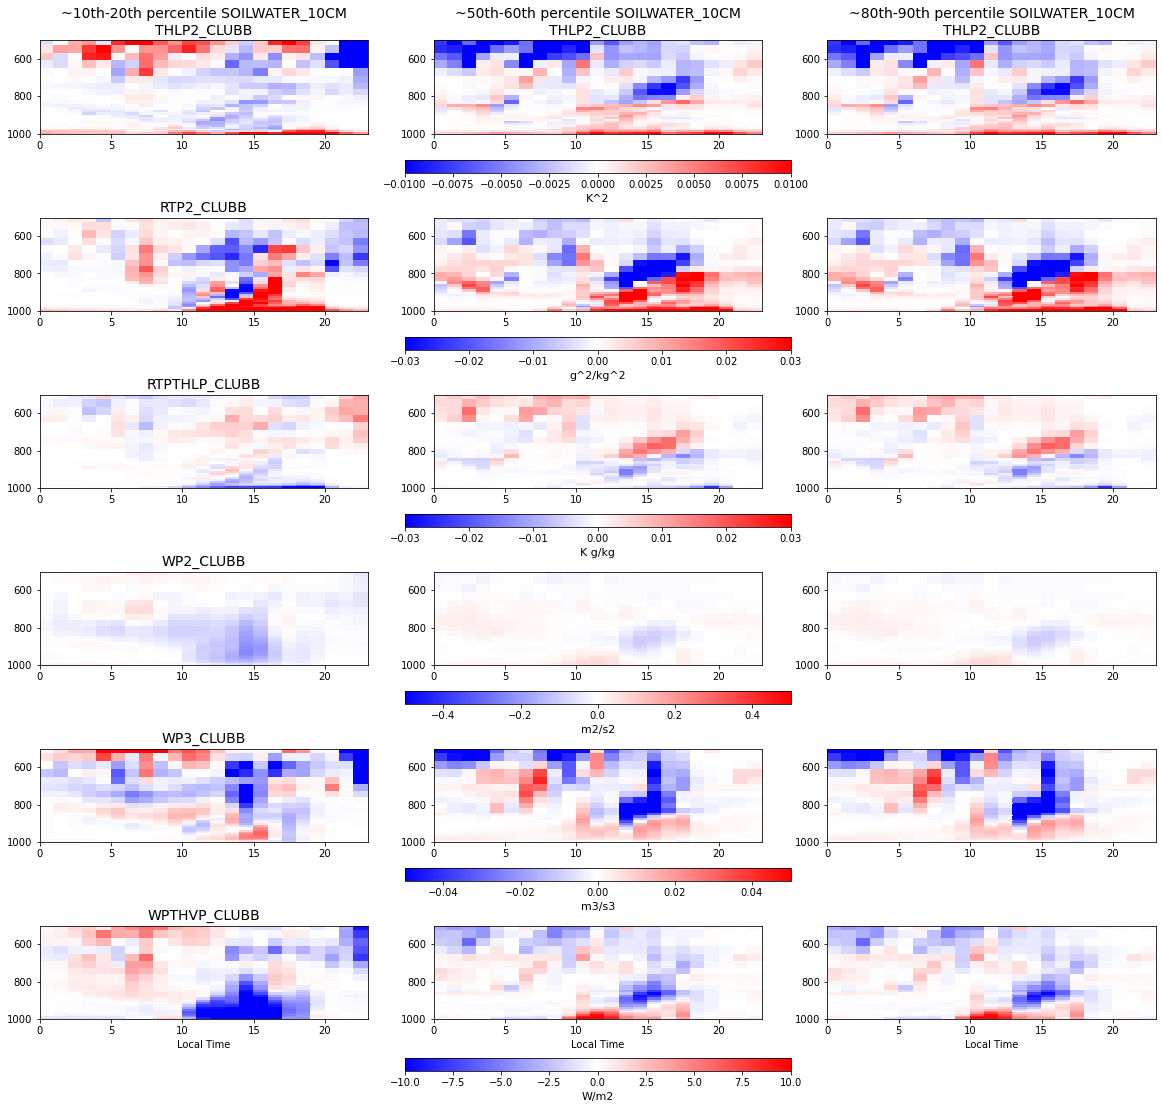

In [402]:
fig,axs = plt.subplots(6,3, figsize=(20,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.5, 0.05, 10])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.02, ax_position.y0-0.04, ax_position.width+0.04, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.02, ax_position.y0-0.03, ax_position.width+0.04, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## Plot 80th-90th percentile bin 
    diffVar = np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
    

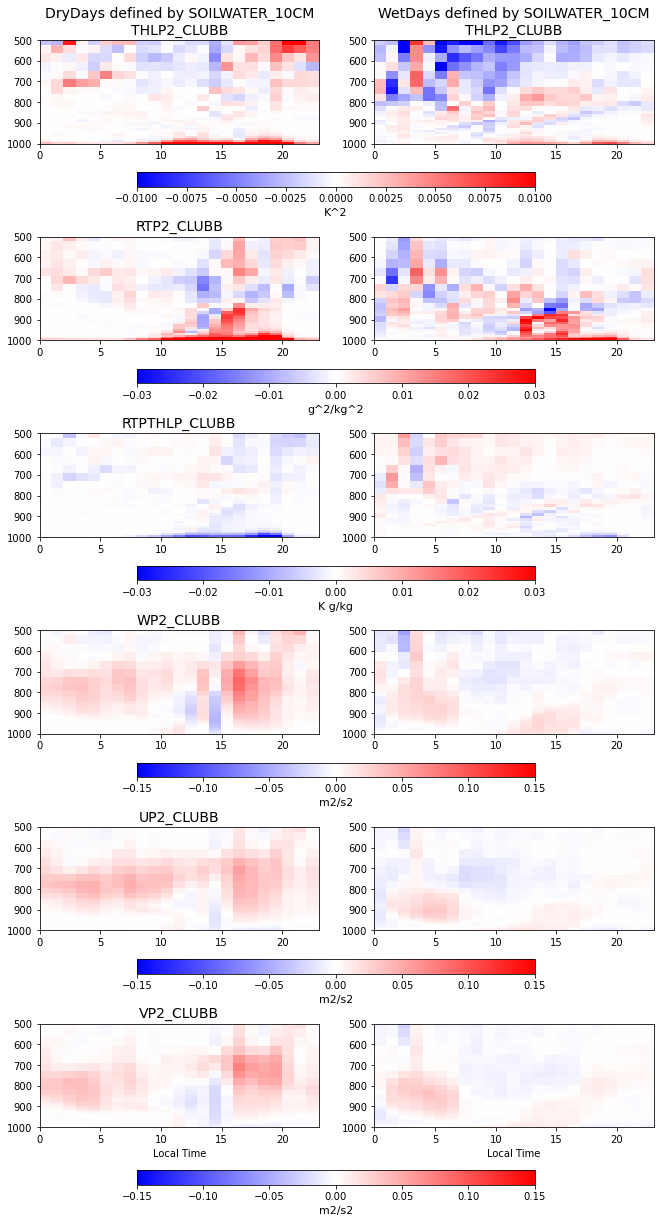

In [54]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.15, 0.15, 0.15])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

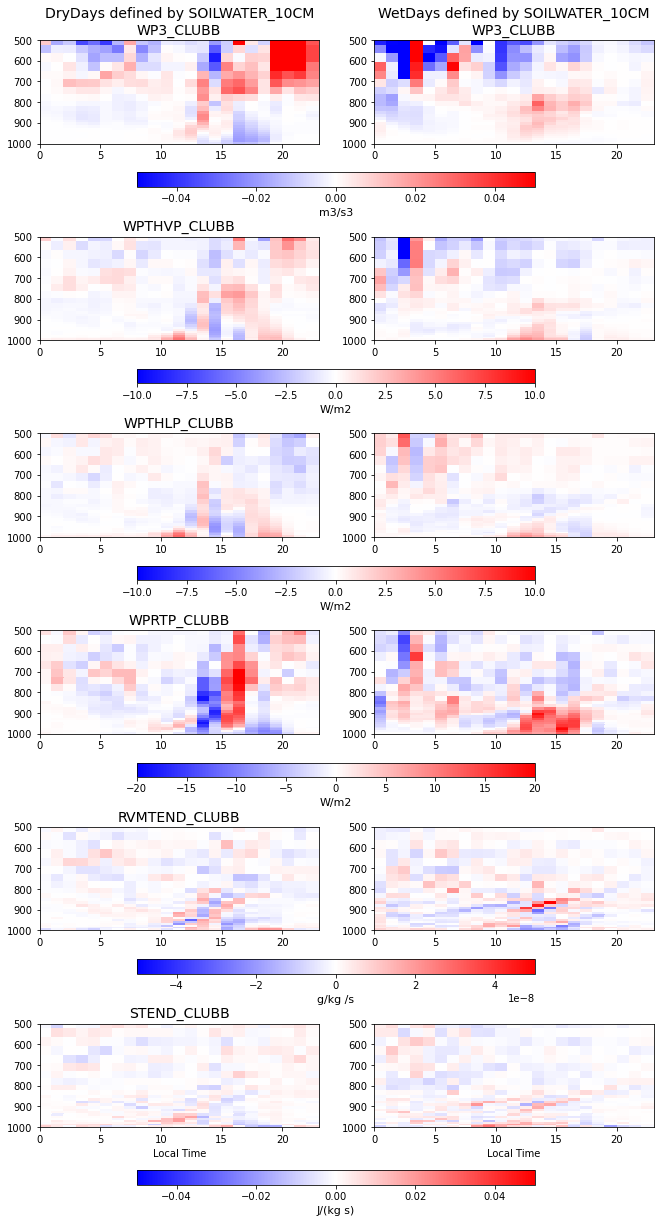

In [55]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

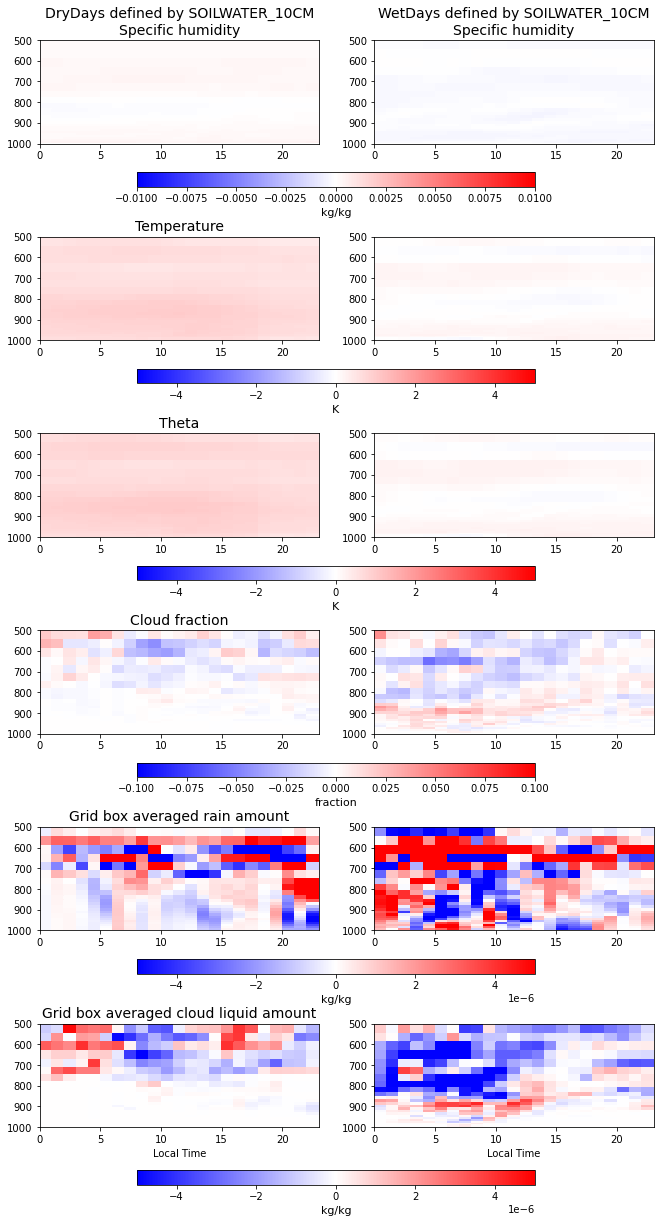

In [41]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['Q','T','theta','CLOUD','RAINQM','CLDLIQ'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 5, 5, 0.1, 0.000005, 0.000005])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    if ATM_varNames[iVar]=='theta':
        axs[iPlot].set_title('Theta',fontsize=14)
    else: 
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

#### Of those days falling into terciles assessed above, was the previous day wet or dry?

In [56]:
## Denote wet/dry days in full daily mean array 
wetDryMarker_HMG = np.full([len(HMGcamDS_localDailyMean.year_month_day.values)], 'none').astype('str')
wetDryMarker_HMG[HMGbin_bot30] = 'Dry'
wetDryMarker_HMG[HMGbin_top30] = 'Wet'

wetDryMarker_HTG = np.full([len(HTGcamDS_localDailyMean.year_month_day.values)], 'none').astype('str')
wetDryMarker_HTG[HTGbin_bot30] = 'Dry'
wetDryMarker_HTG[HTGbin_top30] = 'Wet'


HMGcamDS_localDailyMean['wetDryMarker'] = (('year_month_day'), wetDryMarker_HMG)
HTGcamDS_localDailyMean['wetDryMarker'] = (('year_month_day'), wetDryMarker_HTG)

# dryDays_HMG = HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_bot30)
# wetDays_HMG = HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_top30)

# dryDays_HTG = HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_bot30)
# wetDays_HTG = HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_top30)

## What should define the cutoff of wet/dry days preceding?
dryCutoff_HMG = np.percentile(HMGcamDS_localDailyMean.PRECTdailySum.values, 50)
dryCutoff_HTG = np.percentile(HTGcamDS_localDailyMean.PRECTdailySum.values, 50)

## Define dDry/wDry and dWet/wWet days 
wwDDdays_HMG = np.full([len(HMGcamDS_localDailyMean.year_month_day.values)], 'none').astype('str')
wwDDdays_HTG = np.full([len(HTGcamDS_localDailyMean.year_month_day.values)], 'none').astype('str')

for iDay in range(len(HMGcamDS_localDailyMean.year_month_day.values)-1):
    
    prevDayRainHMG = HMGcamDS_localDailyMean.PRECTdailySum.values[iDay]
    if wetDryMarker_HMG[iDay+1]=='Dry': 
        if prevDayRainHMG >= dryCutoff_HMG:
            wwDDdays_HMG[iDay+1] = 'wDry'
        elif prevDayRainHMG < dryCutoff_HMG: 
            wwDDdays_HMG[iDay+1] = 'dDry'
            
    elif wetDryMarker_HMG[iDay+1]=='Wet':
        if prevDayRainHMG >= dryCutoff_HMG:
            wwDDdays_HMG[iDay+1] = 'wWet'
        elif prevDayRainHMG < dryCutoff_HMG: 
            wwDDdays_HMG[iDay+1] = 'dWet'   
            
    prevDayRainHTG = HTGcamDS_localDailyMean.PRECTdailySum.values[iDay]
    if wetDryMarker_HTG[iDay+1]=='Dry': 
        if prevDayRainHTG >= dryCutoff_HTG:
            wwDDdays_HTG[iDay+1] = 'wDry'
        elif prevDayRainHTG < dryCutoff_HTG: 
            wwDDdays_HTG[iDay+1] = 'dDry'
            
    elif wetDryMarker_HTG[iDay+1]=='Wet':
        if prevDayRainHTG >= dryCutoff_HTG:
            wwDDdays_HTG[iDay+1] = 'wWet'
        elif prevDayRainHTG < dryCutoff_HTG: 
            wwDDdays_HTG[iDay+1] = 'dWet'  
            
HMGcamDS_localDailyMean['wwDDdays'] = (('year_month_day'), wwDDdays_HMG)
HTGcamDS_localDailyMean['wwDDdays'] = (('year_month_day'), wwDDdays_HTG)


In [57]:

iDD_HMG = np.where(wwDDdays_HMG=='dDry')[0]
iWD_HMG = np.where(wwDDdays_HMG=='wDry')[0]
iDW_HMG = np.where(wwDDdays_HMG=='dWet')[0]
iWW_HMG = np.where(wwDDdays_HMG=='wWet')[0]

HMGcam_dD = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iDD_HMG))
HMGcam_wD = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iWD_HMG))
HMGcam_dW = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iDW_HMG))
HMGcam_wW = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iWW_HMG))

HMGclm_dD = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iDD_HMG))
HMGclm_wD = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iWD_HMG))
HMGclm_dW = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iDW_HMG))
HMGclm_wW = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iWW_HMG))



iDD_HTG = np.where(wwDDdays_HTG=='dDry')[0]
iWD_HTG = np.where(wwDDdays_HTG=='wDry')[0]
iDW_HTG = np.where(wwDDdays_HTG=='dWet')[0]
iWW_HTG = np.where(wwDDdays_HTG=='wWet')[0]
HTGcam_dD = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iDD_HMG))
HTGcam_wD = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iWD_HMG))
HTGcam_dW = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iDW_HMG))
HTGcam_wW = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iWW_HMG))

HTGclm_dD = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iDD_HMG))
HTGclm_wD = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iWD_HMG))
HTGclm_dW = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iDW_HMG))
HTGclm_wW = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iWW_HMG))


print('    HMG        HTG')
print('dD: %i %10i' % (len(iDD_HMG), len(iDD_HTG)))
print('wD: %i %10i' % (len(iWD_HMG), len(iWD_HTG)))
print('dW: %i %10i' % (len(iDW_HMG), len(iDW_HTG)))
print('wW: %i %10i' % (len(iWW_HMG), len(iWW_HTG)))



    HMG        HTG
dD: 70         70
wD: 19         16
dW: 12         15
wW: 73         76


In [58]:
print('Number of dry days in HMG: ', len(wetDryMarker_HMG[wetDryMarker_HMG=='Dry']))  # Day one was "dry" but can't be in classification
print('Number of wet days in HMG: ', len(wetDryMarker_HMG[wetDryMarker_HMG=='Wet']))
print()
print('Number of dry days in HTG: ', len(wetDryMarker_HMG[wetDryMarker_HTG=='Dry'])) # Day one was "dry" but can't be in classification
print('Number of wet days in HTG: ', len(wetDryMarker_HMG[wetDryMarker_HTG=='Wet']))

Number of dry days in HMG:  90
Number of wet days in HMG:  85

Number of dry days in HTG:  87
Number of wet days in HTG:  91


In [59]:
hourlyMean_dD_HTG = HTGcam_dD.groupby("time.hour").mean()
hourlyMean_wD_HTG = HTGcam_wD.groupby("time.hour").mean()
hourlyMean_dW_HTG = HTGcam_dW.groupby("time.hour").mean()
hourlyMean_wW_HTG = HTGcam_wW.groupby("time.hour").mean()

hourlyMean_dD_HMG = HMGcam_dD.groupby("time.hour").mean()
hourlyMean_wD_HMG = HMGcam_wD.groupby("time.hour").mean()
hourlyMean_dW_HMG = HMGcam_dW.groupby("time.hour").mean()
hourlyMean_wW_HMG = HMGcam_wW.groupby("time.hour").mean()


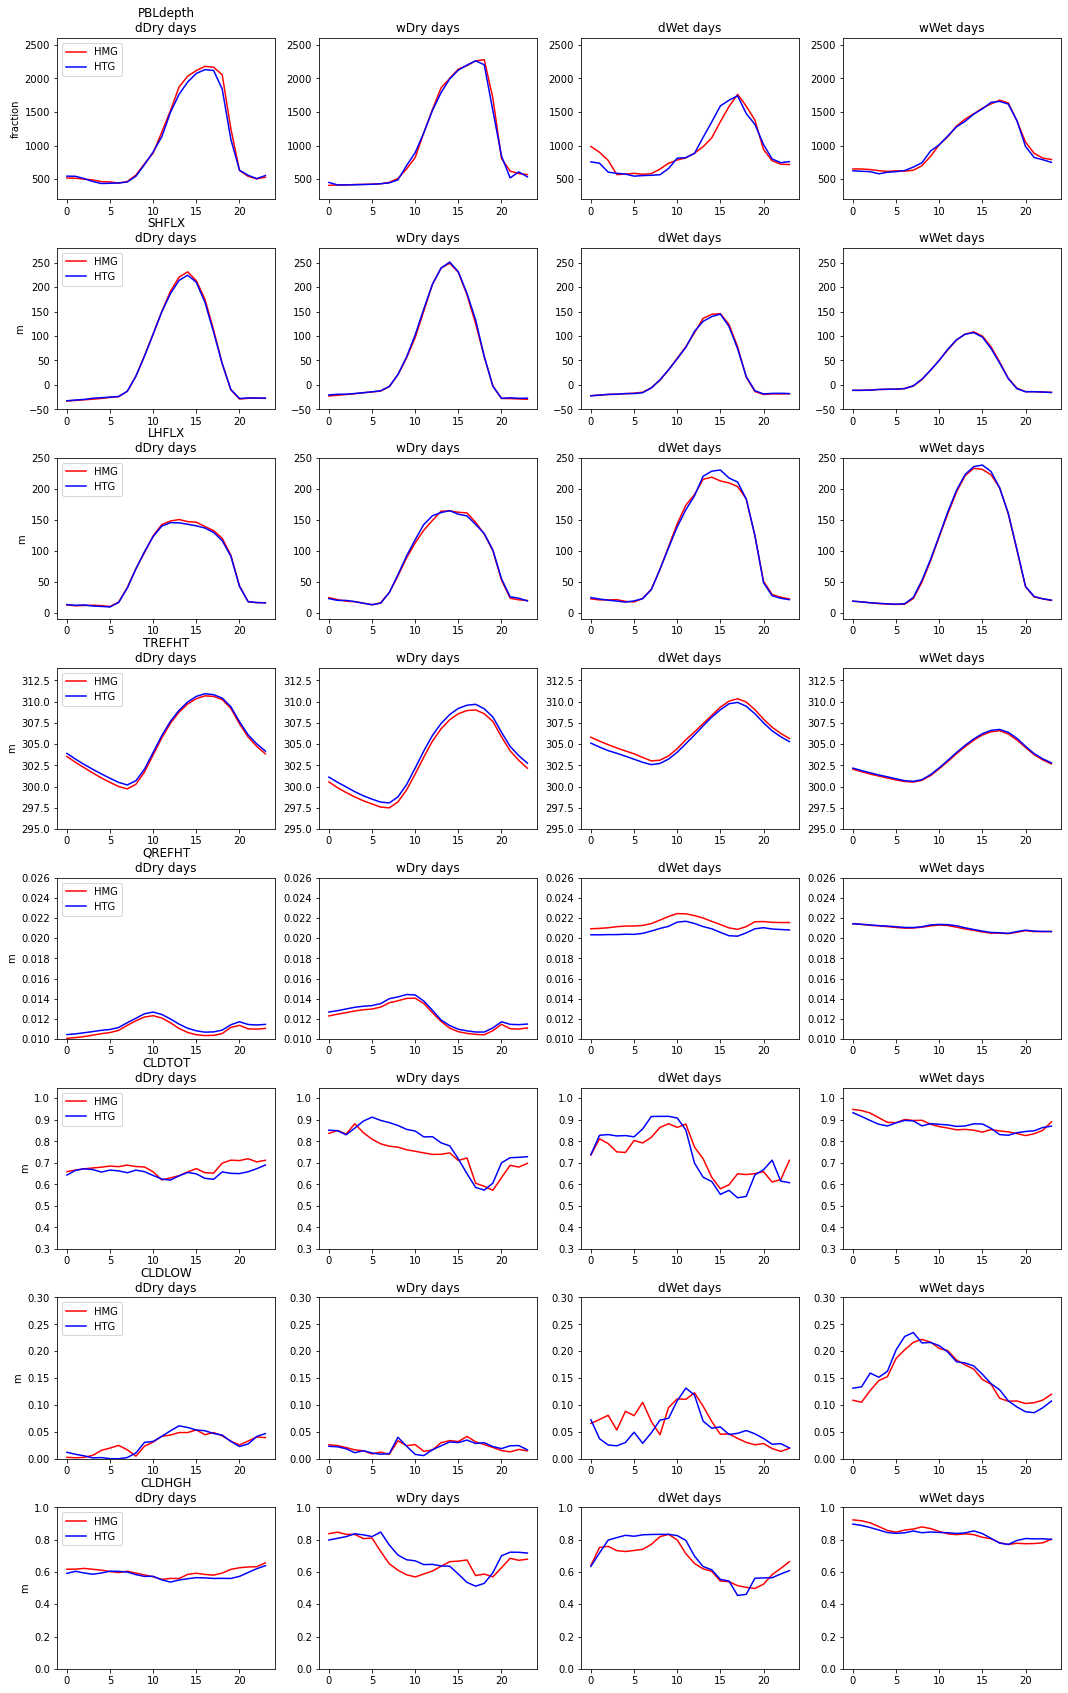

In [61]:
varSel = np.asarray(['PBLdepth','SHFLX','LHFLX','TREFHT','QREFHT','CLDTOT','CLDLOW','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,30))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2600, 280, 250, 314, 0.0260, 1.05, 0.3, 1.0])
yMin = np.asarray([ 200, -50, -10, 295, 0.0100, 0.3, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dD_HMG.hour.values, np.squeeze(hourlyMean_dD_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dD_HTG.hour.values, np.squeeze(hourlyMean_dD_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wD_HMG.hour.values, np.squeeze(hourlyMean_wD_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wD_HTG.hour.values, np.squeeze(hourlyMean_wD_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dW_HMG.hour.values, np.squeeze(hourlyMean_dW_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dW_HTG.hour.values, np.squeeze(hourlyMean_dW_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wW_HMG.hour.values, np.squeeze(hourlyMean_wW_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wW_HTG.hour.values, np.squeeze(hourlyMean_wW_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4


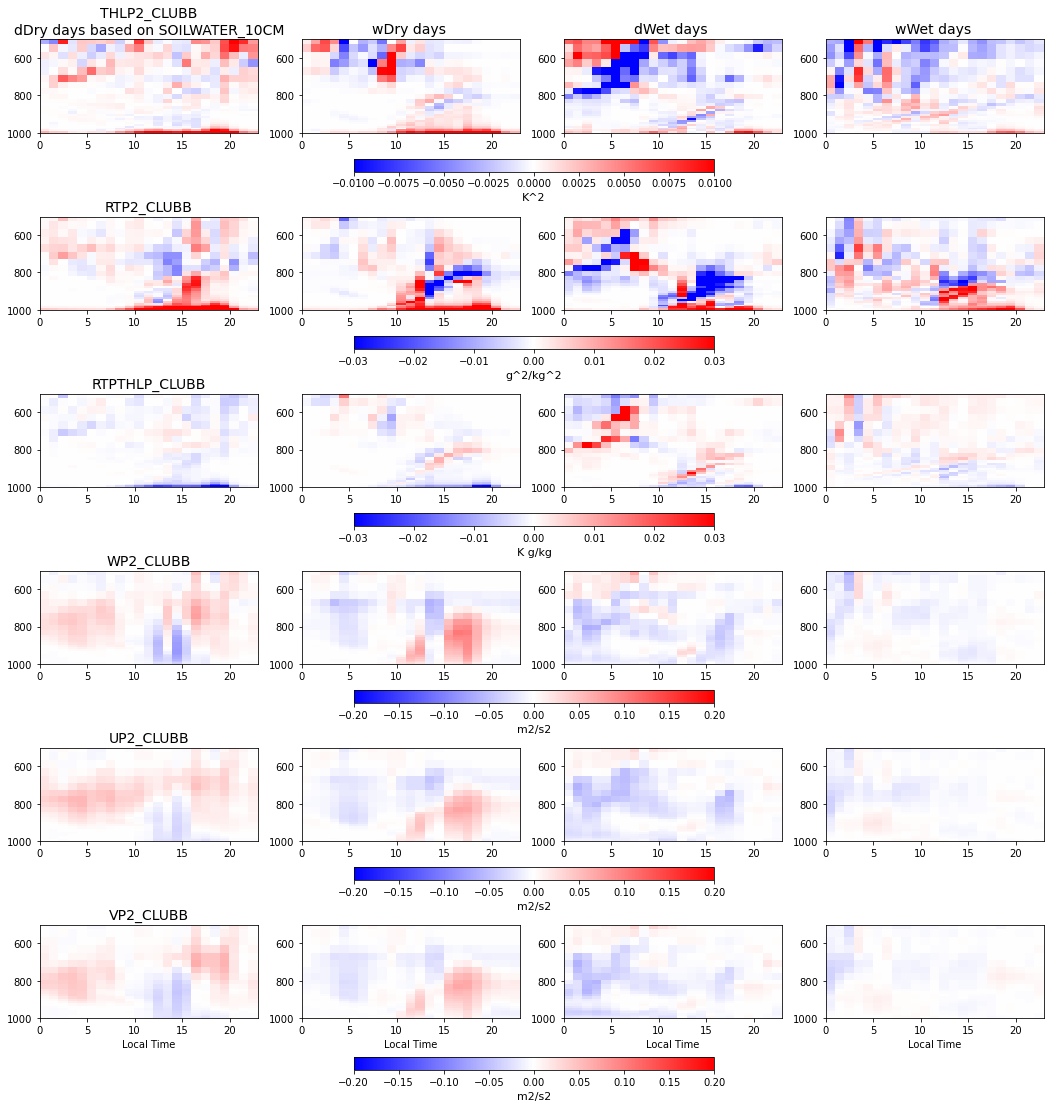

In [62]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.2, 0.2, 0.2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dD_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dD_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dD_HMG.hour.values, hourlyMean_dD_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wD_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wD_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wD_HMG.hour.values, hourlyMean_wD_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dW_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dW_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dW_HMG.hour.values, hourlyMean_dW_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wW_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wW_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wW_HMG.hour.values, hourlyMean_wW_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days based on '+controlVar,fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

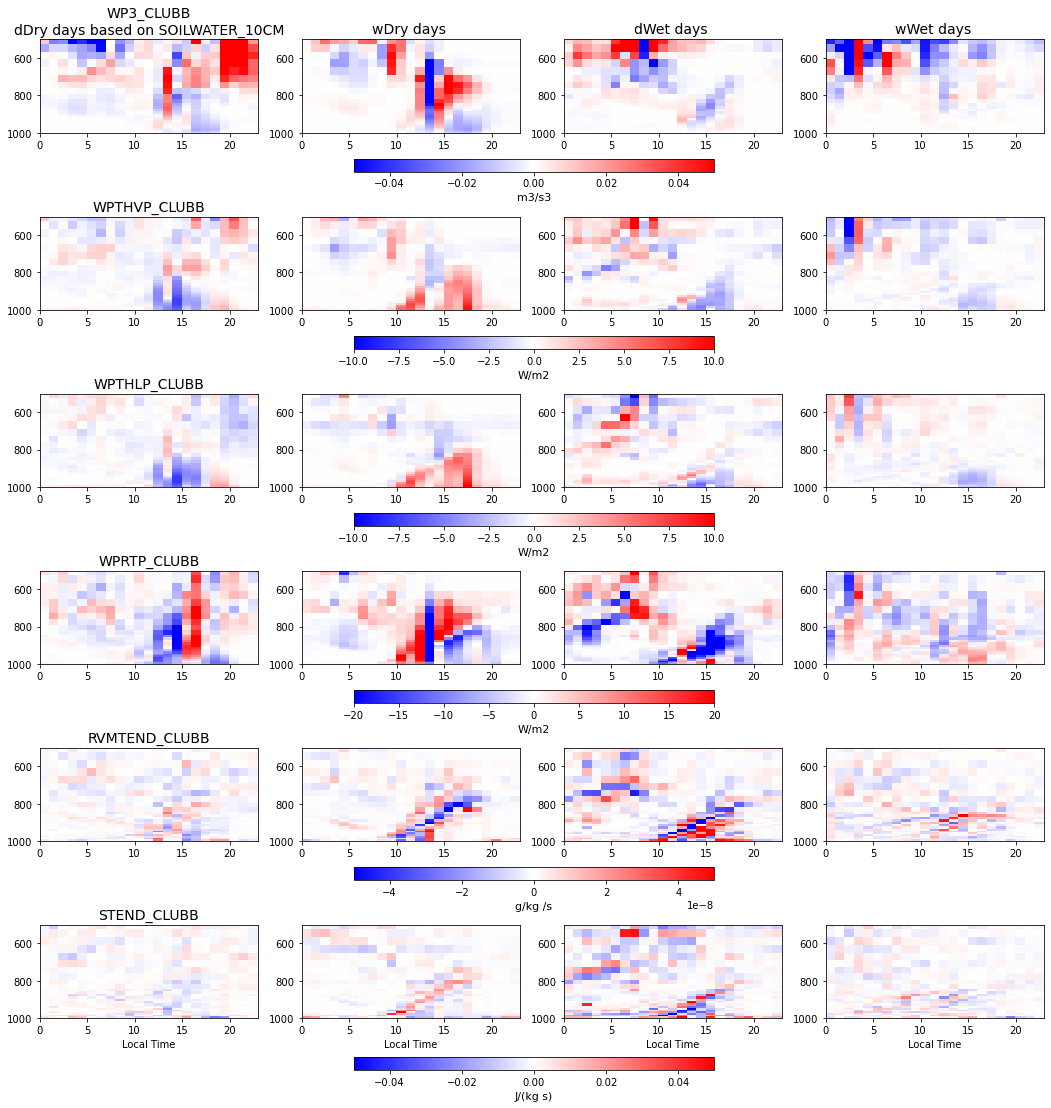

In [63]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dD_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dD_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dD_HMG.hour.values, hourlyMean_dD_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wD_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wD_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wD_HMG.hour.values, hourlyMean_wD_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dW_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dW_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dW_HMG.hour.values, hourlyMean_dW_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wW_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wW_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wW_HMG.hour.values, hourlyMean_wW_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days based on '+controlVar,fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

**Now look at the percentiles' mean profiles averaged over a certain time of day**

In [170]:
def getMeanOverHours(DS, startHr, endHr):
    hourlyMean = DS.groupby("time.hour").mean()
    
    # Get mean over some hours 
    iHours    = np.where((hourlyMean.hour>=startHr) & (hourlyMean.hour<=endHr))[0]
    DShrSel   = hourlyMean.isel(hour=iHours)
    
    return(DShrSel.mean(dim='hour'))

In [171]:
# Get means over hours selected (on 0-23h scale)
startHr    = 8
endHr      = 10
# startHr    = 13
# endHr      = 15


hrMeansHTG_10pct  = getMeanOverHours(HTGcam_10pct, startHr, endHr)
hrMeansHTG_20pct  = getMeanOverHours(HTGcam_20pct, startHr, endHr)
hrMeansHTG_30pct  = getMeanOverHours(HTGcam_30pct, startHr, endHr)
hrMeansHTG_40pct  = getMeanOverHours(HTGcam_40pct, startHr, endHr)
hrMeansHTG_50pct  = getMeanOverHours(HTGcam_50pct, startHr, endHr)
hrMeansHTG_60pct  = getMeanOverHours(HTGcam_60pct, startHr, endHr)
hrMeansHTG_70pct  = getMeanOverHours(HTGcam_70pct, startHr, endHr)
hrMeansHTG_80pct  = getMeanOverHours(HTGcam_80pct, startHr, endHr)
hrMeansHTG_90pct  = getMeanOverHours(HTGcam_90pct, startHr, endHr)
hrMeansHTG_100pct = getMeanOverHours(HTGcam_100pct, startHr, endHr)

hrMeansHMG_10pct  = getMeanOverHours(HMGcam_10pct, startHr, endHr)
hrMeansHMG_20pct  = getMeanOverHours(HMGcam_20pct, startHr, endHr)
hrMeansHMG_30pct  = getMeanOverHours(HMGcam_30pct, startHr, endHr)
hrMeansHMG_40pct  = getMeanOverHours(HMGcam_40pct, startHr, endHr)
hrMeansHMG_50pct  = getMeanOverHours(HMGcam_50pct, startHr, endHr)
hrMeansHMG_60pct  = getMeanOverHours(HMGcam_60pct, startHr, endHr)
hrMeansHMG_70pct  = getMeanOverHours(HMGcam_70pct, startHr, endHr)
hrMeansHMG_80pct  = getMeanOverHours(HMGcam_80pct, startHr, endHr)
hrMeansHMG_90pct  = getMeanOverHours(HMGcam_90pct, startHr, endHr)
hrMeansHMG_100pct = getMeanOverHours(HMGcam_100pct, startHr, endHr)



In [285]:
def plotPctBasedProfiles(respondVar, xMin, xMax, levMax):
    fig,axs = plt.subplots(1,10, figsize=(18,5))
    axs     = axs.ravel()
    
    if np.shape(np.squeeze(hrMeansHMG_10pct[respondVar].values))[0]==len(HTGcamDS_all.ilev.values):
        levSel='ilev'
    elif np.shape(np.squeeze(hrMeansHMG_10pct[respondVar].values))[0]==len(HTGcamDS_all.lev.values):
        levSel='lev'

    ## Plot percentiles 
    axs[0].plot(np.squeeze(hrMeansHMG_10pct[respondVar].values), HMGcam_10pct[levSel].values, 'r-o', label='HMG')
    axs[0].plot(np.squeeze(hrMeansHTG_10pct[respondVar].values), HTGcam_10pct[levSel].values, 'b-o', label='HTG')
    axs[0].legend()
#     axs[0].set_title(respondVar+'\n0-10th Pct '+controlVar)
    axs[0].set_title(respondVar+'\n0-10th Pct '+controlVar)

    axs[1].plot(np.squeeze(hrMeansHMG_20pct[respondVar].values), HMGcam_20pct[levSel].values, 'r-o', label='HMG')
    axs[1].plot(np.squeeze(hrMeansHTG_20pct[respondVar].values), HTGcam_20pct[levSel].values, 'b-o', label='HTG')
    axs[1].set_title('\n10-20th Pct')

    axs[2].plot(np.squeeze(hrMeansHMG_30pct[respondVar].values), HMGcam_30pct[levSel].values, 'r-o', label='HMG')
    axs[2].plot(np.squeeze(hrMeansHTG_30pct[respondVar].values), HTGcam_30pct[levSel].values, 'b-o', label='HMG')
    axs[2].set_title('\n20-30th Pct')

    axs[3].plot(np.squeeze(hrMeansHMG_40pct[respondVar].values), HMGcam_40pct[levSel].values, 'r-o', label='HMG')
    axs[3].plot(np.squeeze(hrMeansHTG_40pct[respondVar].values), HTGcam_40pct[levSel].values, 'b-o', label='HMG')
    axs[3].set_title('\n30-40th Pct')

    axs[4].plot(np.squeeze(hrMeansHMG_50pct[respondVar].values), HMGcam_50pct[levSel].values, 'r-o', label='HMG')
    axs[4].plot(np.squeeze(hrMeansHTG_50pct[respondVar].values), HTGcam_50pct[levSel].values, 'b-o', label='HMG')
    axs[4].set_title('\n40-50th Pct')

    axs[5].plot(np.squeeze(hrMeansHMG_60pct[respondVar].values), HMGcam_60pct[levSel].values, 'r-o', label='HMG')
    axs[5].plot(np.squeeze(hrMeansHTG_60pct[respondVar].values), HTGcam_60pct[levSel].values, 'b-o', label='HMG')
    axs[5].set_title('\n50-60th Pct')

    axs[6].plot(np.squeeze(hrMeansHMG_70pct[respondVar].values), HMGcam_70pct[levSel].values, 'r-o', label='HMG')
    axs[6].plot(np.squeeze(hrMeansHTG_70pct[respondVar].values), HTGcam_70pct[levSel].values, 'b-o', label='HMG')
    axs[6].set_title('\n60-70th Pct')

    axs[7].plot(np.squeeze(hrMeansHMG_80pct[respondVar].values), HMGcam_80pct[levSel].values, 'r-o', label='HMG')
    axs[7].plot(np.squeeze(hrMeansHTG_80pct[respondVar].values), HTGcam_80pct[levSel].values, 'b-o', label='HMG')
    axs[7].set_title('\n70-80th Pct')

    axs[8].plot(np.squeeze(hrMeansHMG_90pct[respondVar].values), HMGcam_90pct[levSel].values, 'r-o', label='HMG')
    axs[8].plot(np.squeeze(hrMeansHTG_90pct[respondVar].values), HTGcam_90pct[levSel].values, 'b-o', label='HMG')
    axs[8].set_title('\n80-90th Pct')

    axs[9].plot(np.squeeze(hrMeansHMG_100pct[respondVar].values), HMGcam_100pct[levSel].values, 'r-o', label='HMG')
    axs[9].plot(np.squeeze(hrMeansHTG_100pct[respondVar].values), HTGcam_100pct[levSel].values, 'b-o', label='HMG')
    axs[9].set_title('\n90-100th Pct')


    ## Remove y-tick labels on other plots
    axs[1].get_yaxis().set_ticklabels([])
    axs[2].get_yaxis().set_ticklabels([])
    axs[3].get_yaxis().set_ticklabels([])
    axs[4].get_yaxis().set_ticklabels([])
    axs[5].get_yaxis().set_ticklabels([])
    axs[6].get_yaxis().set_ticklabels([])
    axs[7].get_yaxis().set_ticklabels([])
    axs[8].get_yaxis().set_ticklabels([])
    axs[9].get_yaxis().set_ticklabels([])

    ## Flip y axis 
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()
    axs[9].invert_yaxis()
    
    ## Set y-axis limits
    axs[0].set_ylim([1000, levMax])
    axs[1].set_ylim([1000, levMax])
    axs[2].set_ylim([1000, levMax])
    axs[3].set_ylim([1000, levMax])
    axs[4].set_ylim([1000, levMax])
    axs[5].set_ylim([1000, levMax])
    axs[6].set_ylim([1000, levMax])
    axs[7].set_ylim([1000, levMax])
    axs[8].set_ylim([1000, levMax])
    axs[9].set_ylim([1000, levMax])

    ## Set x-axis limits
    axs[0].set_xlim([xMin, xMax])
    axs[1].set_xlim([xMin, xMax])
    axs[2].set_xlim([xMin, xMax])
    axs[3].set_xlim([xMin, xMax])
    axs[4].set_xlim([xMin, xMax])
    axs[5].set_xlim([xMin, xMax])
    axs[6].set_xlim([xMin, xMax])
    axs[7].set_xlim([xMin, xMax])
    axs[8].set_xlim([xMin, xMax])
    axs[9].set_xlim([xMin, xMax])

    ## Set axis labels
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[1].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[2].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[3].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[4].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[5].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[6].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[7].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[8].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[9].set_xlabel(HTGcamDS_local[respondVar].units)
        
    plt.show()
    
    

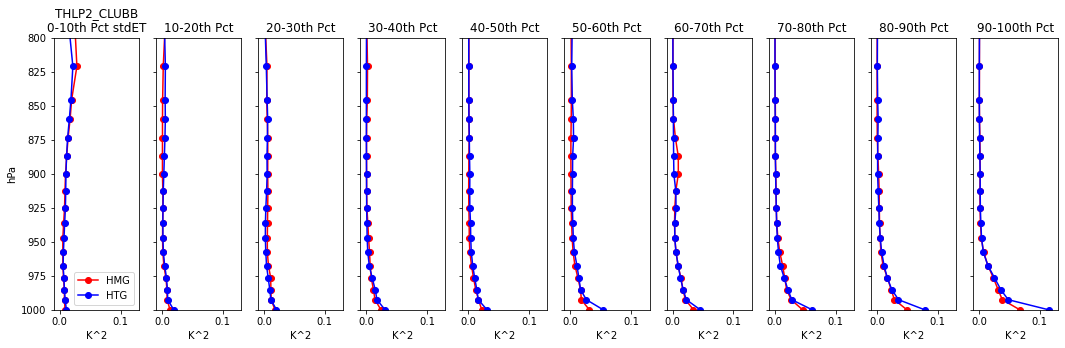

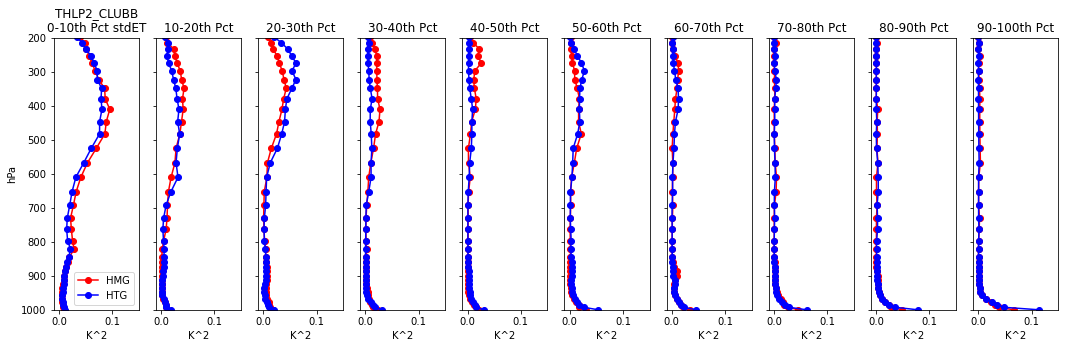

In [173]:
plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.13, 800) ## Used for Soil Moisture percentiles
# plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.6, 800)  ## Used for std(ET) percentiles

plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.15, 200)  ## Used for std(ET) percentiles


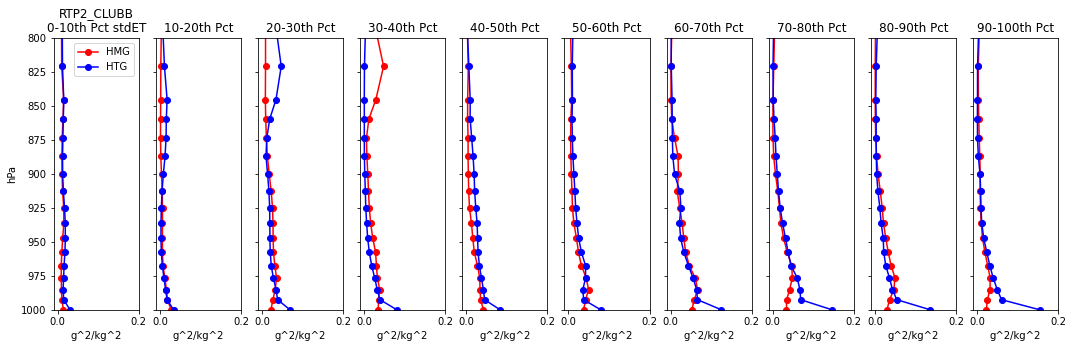

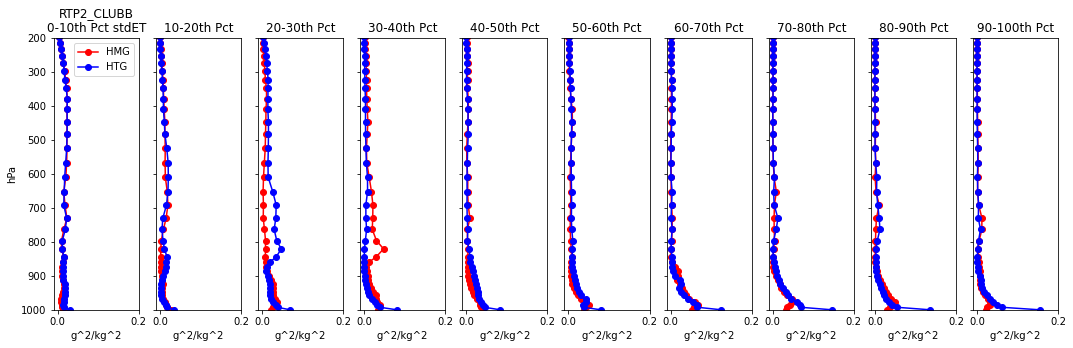

In [176]:
# plotPctBasedProfiles('RTP2_CLUBB', -0.01, 0.35, 800) ## Used for percentiles of soil moisture 
plotPctBasedProfiles('RTP2_CLUBB', -0.01, 0.2, 800) ## Used for percentiles of std(ET)
plotPctBasedProfiles('RTP2_CLUBB', -0.01, 0.2, 200) ## Used for percentiles of std(ET)


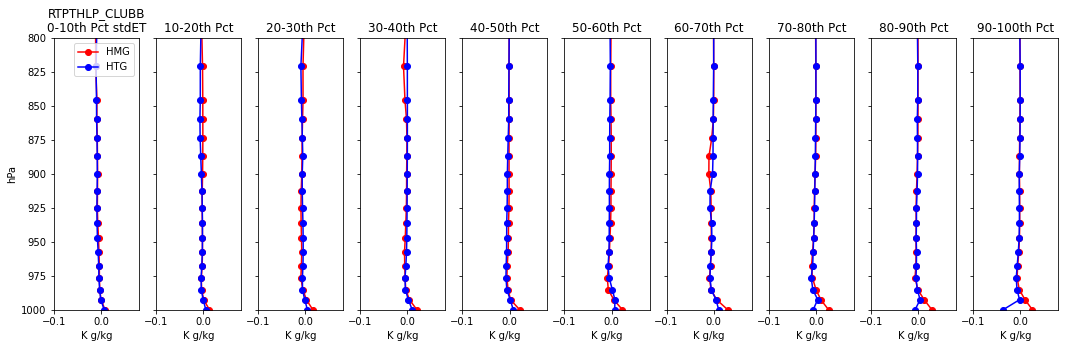

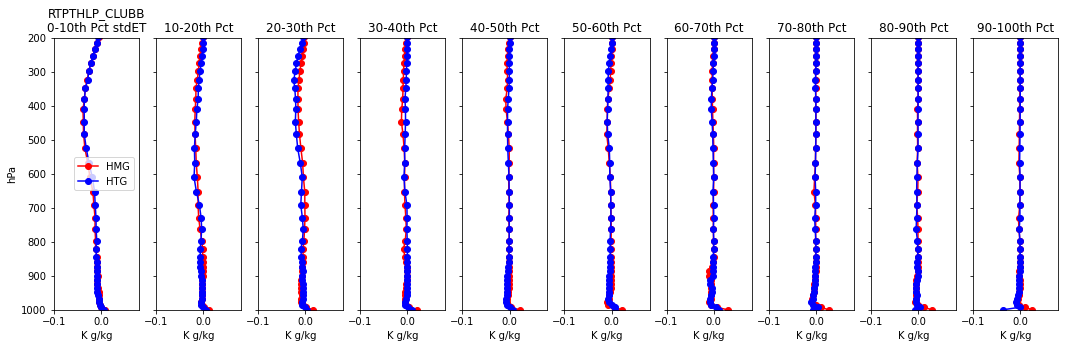

In [177]:
# plotPctBasedProfiles('RTPTHLP_CLUBB', -0.1, 0.08, 800) ## Used for percentiles of soil moisture 
plotPctBasedProfiles('RTPTHLP_CLUBB', -0.1, 0.08, 800) ## Used for percentiles of std(ET)
plotPctBasedProfiles('RTPTHLP_CLUBB', -0.1, 0.08, 200) ## Used for percentiles of std(ET)


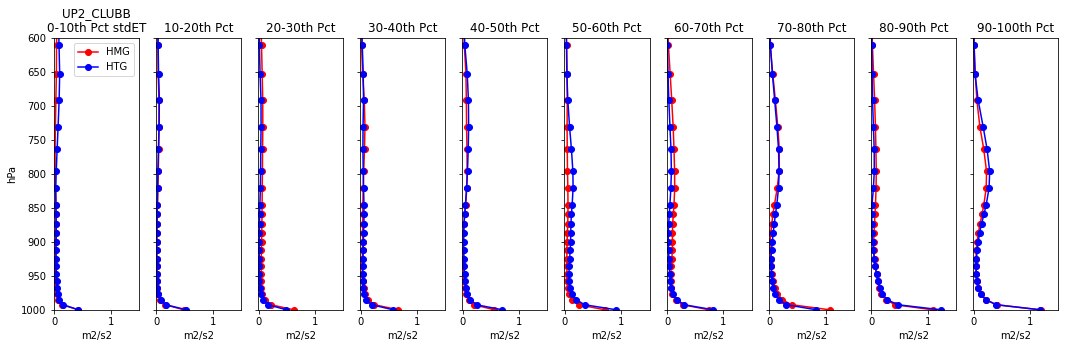

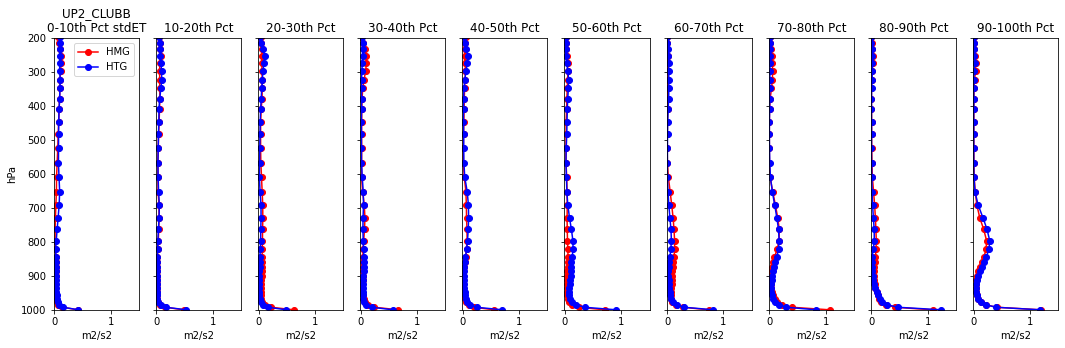

In [179]:
plotPctBasedProfiles('UP2_CLUBB', -0.01, 1.5, 600) ## Used for percentiles of soil moisture and std(ET)
plotPctBasedProfiles('UP2_CLUBB', -0.01, 1.5, 200) ## Used for percentiles of soil moisture and std(ET)

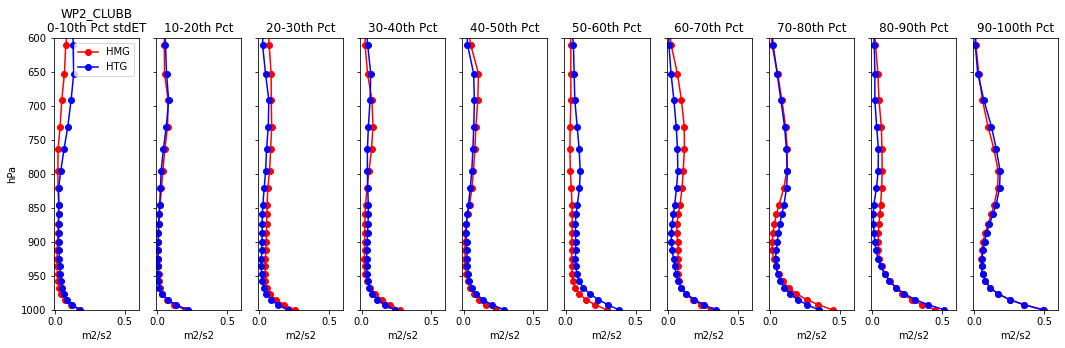

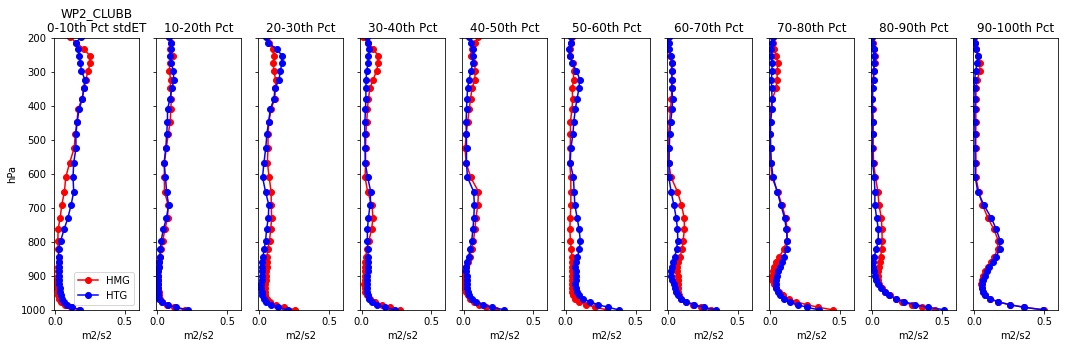

In [180]:
plotPctBasedProfiles('WP2_CLUBB', -0.01, 0.6, 600)
plotPctBasedProfiles('WP2_CLUBB', -0.01, 0.6, 200)


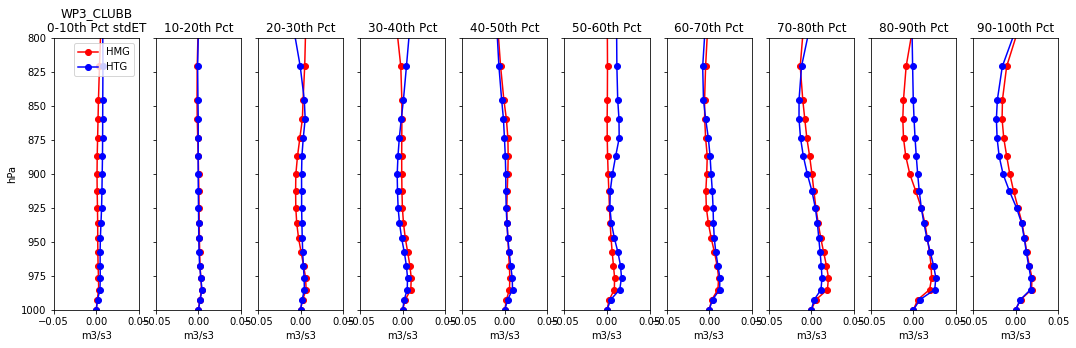

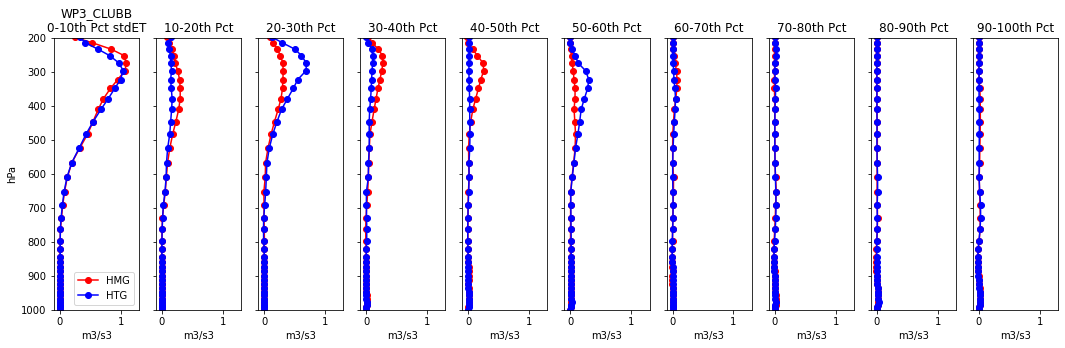

In [181]:
plotPctBasedProfiles('WP3_CLUBB', -0.05, 0.05, 800) ## Used for soil moisture percentiles and std(ET)
plotPctBasedProfiles('WP3_CLUBB', -0.1, 1.3, 200) ## Used for std(ET) percentiles


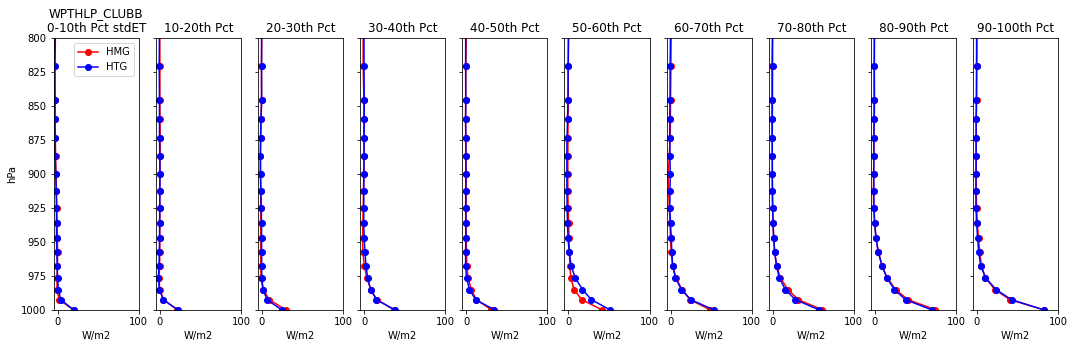

In [311]:
# plotPctBasedProfiles('WPTHLP_CLUBB', -5, 80, 800) ## Used for SM percnetiles 
plotPctBasedProfiles('WPTHLP_CLUBB', -5, 100, 800) ## Used for std(ET) percnetiles 

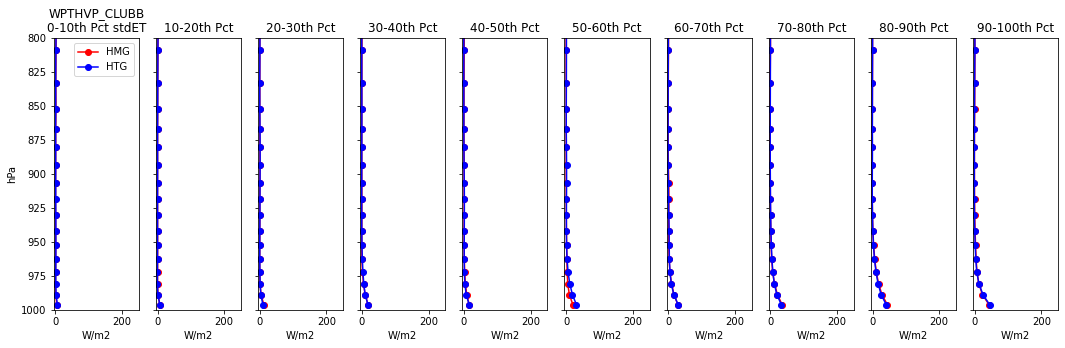

In [312]:
# plotPctBasedProfiles('WPTHLP_CLUBB', -5, 80, 800) ## Used for SM percnetiles 
plotPctBasedProfiles('WPTHVP_CLUBB', -5, 250, 800) ## Used for std(ET) percnetiles 

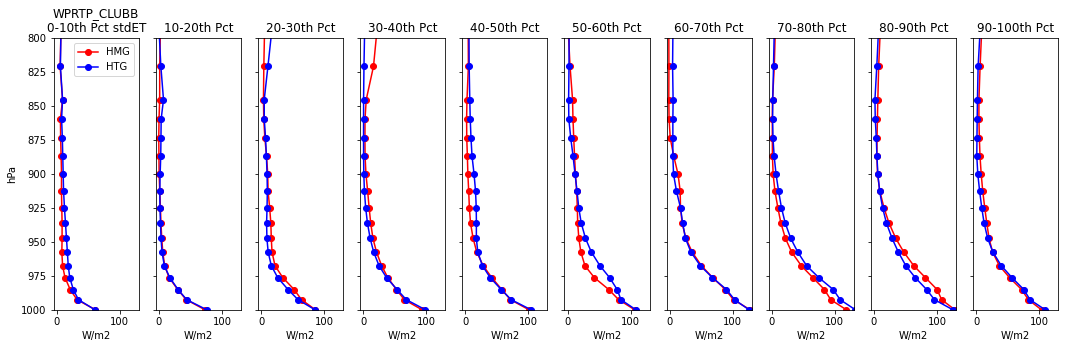

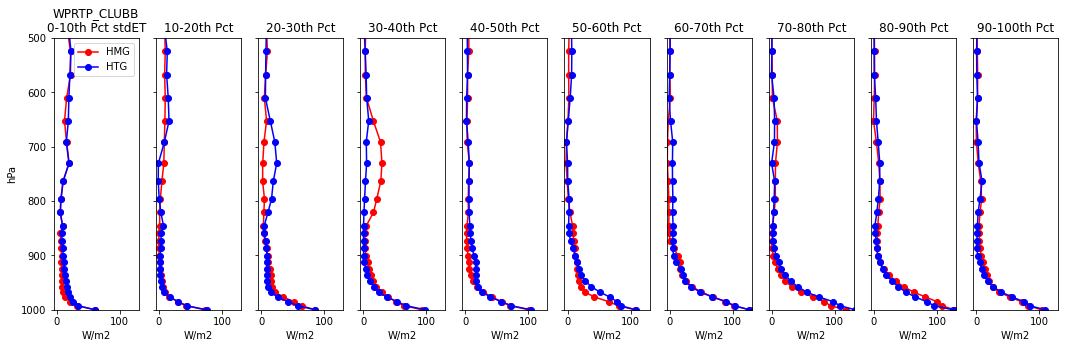

In [313]:
plotPctBasedProfiles('WPRTP_CLUBB', -5, 130, 800)  ## Used for SM percentiles  & std(ET)
plotPctBasedProfiles('WPRTP_CLUBB', -5, 130, 500)  ## Used for SM percentiles  & std(ET)


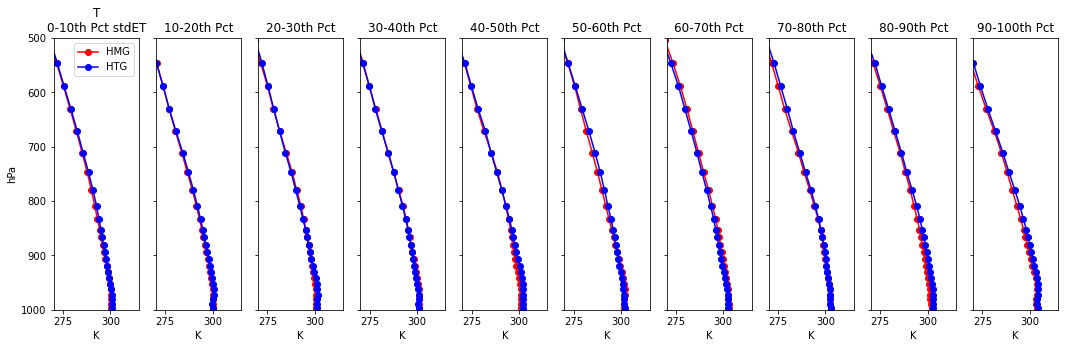

In [314]:
plotPctBasedProfiles('T', 270, 315, 500)

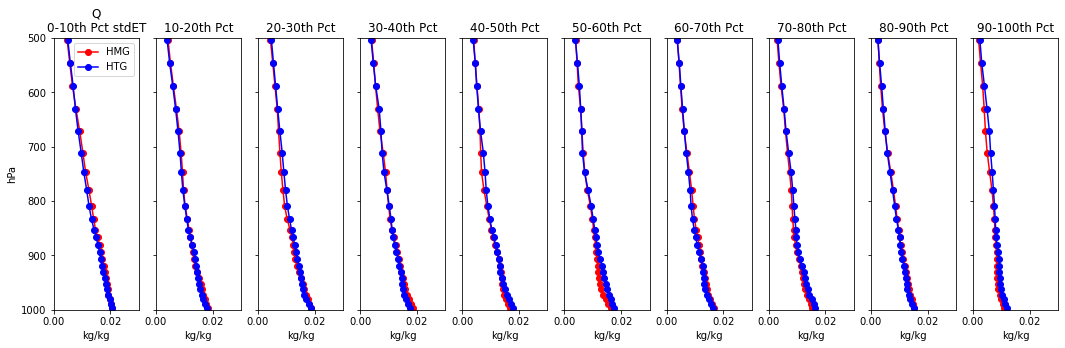

In [315]:
plotPctBasedProfiles('Q', 0, 3e-2, 500)

What characterizes those days with low HTG?

Text(0, 0.5, 'Mean SOILWATER_10CM (kg/m2)')

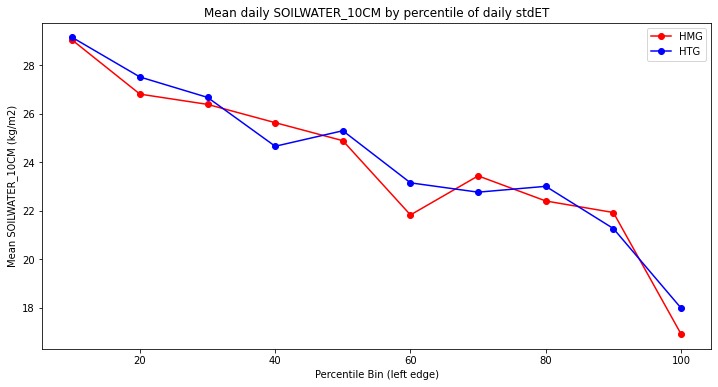

In [336]:
varSel = 'SOILWATER_10CM'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGclmDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGclmDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGclmDS_local[varSel].units+')')



Text(0, 0.5, 'Mean PRECT (m/s)')

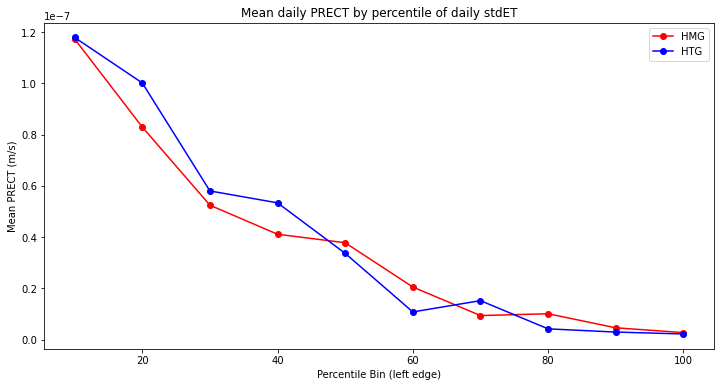

In [286]:
varSel = 'PRECT'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')


Text(0, 0.5, 'Mean PRECTdailySum (mm/day)')

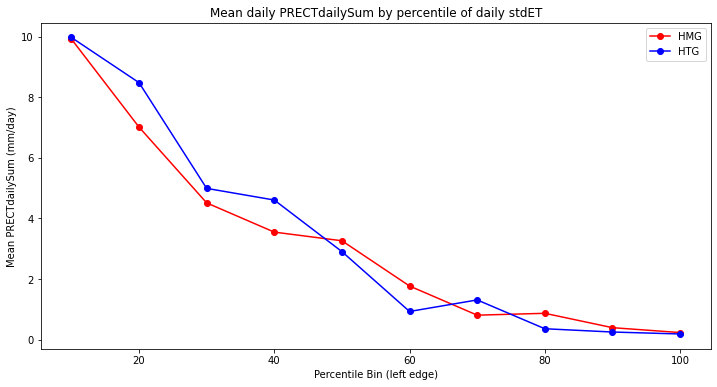

In [287]:
varSel = 'PRECTdailySum'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' (mm/day)')



Text(0, 0.5, 'Mean CLDTOT (fraction)')

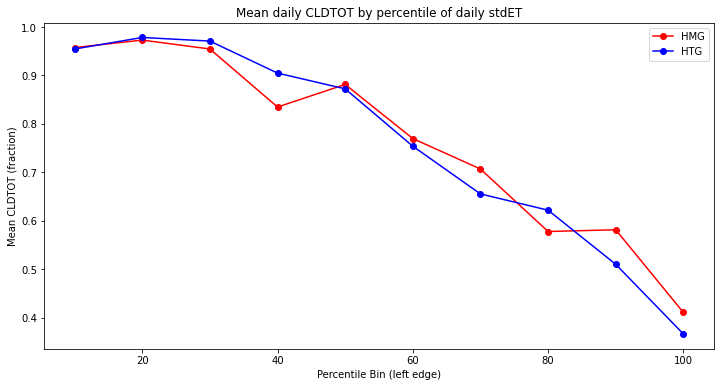

In [288]:
varSel = 'CLDTOT'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')



Text(0, 0.5, 'Mean CLDLOW (fraction)')

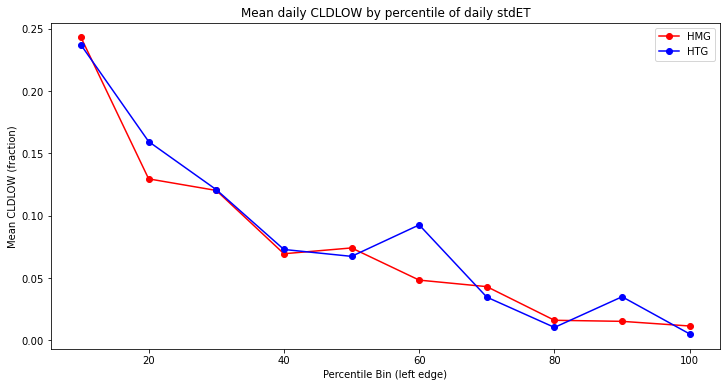

In [289]:
varSel = 'CLDLOW'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')




Text(0, 0.5, 'Mean LHFLX (W/m2)')

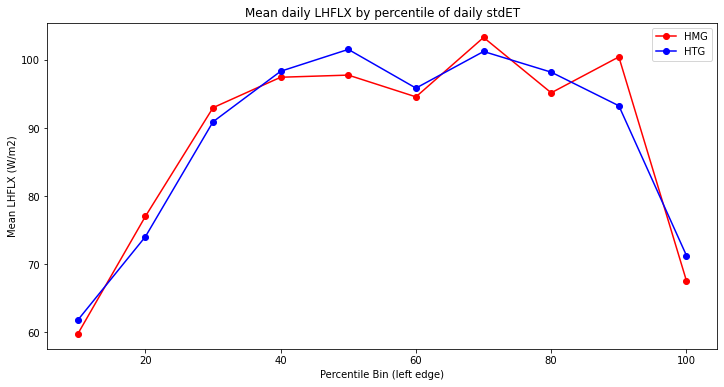

In [290]:
varSel = 'LHFLX'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')

Text(0, 0.5, 'Mean SHFLX (W/m2)')

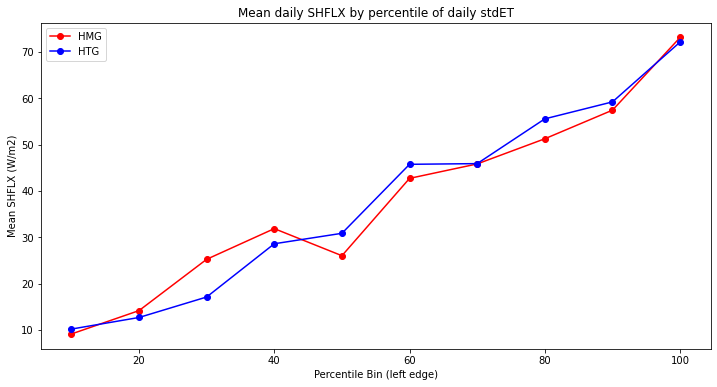

In [291]:
varSel = 'SHFLX'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')

Text(0, 0.5, 'Mean PBLH (m)')

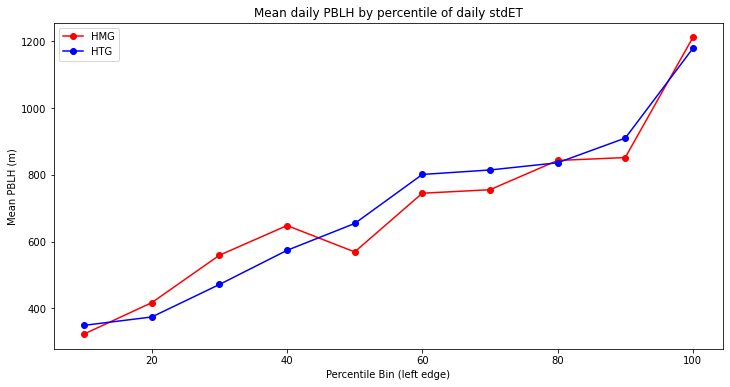

In [337]:
varSel = 'PBLH'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local['PBLH'].units+')')

#### Maybe above would be a lot better based on daily means, not each timestep

In [326]:
# # Get daily means
# HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
# HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

# HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
# HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()


In [328]:
# ## Add in daily total rain for fun... 

# # PRECT defined as mean [m/s] over 20m timestep, 
# #   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
# HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
# HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# # Now sum over the day to get total amount of rainfall
# HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
# HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# # Add to daily mean arrays above
# HMGcamDS_localDailyMean['PRECTdailySum'] = (('time','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
# HTGcamDS_localDailyMean['PRECTdailySum'] = (('time','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


In [329]:
# ## So what if we take, say, percentiles of a controlVar 
# # controlVar = 'SOILWATER_10CM'
# controlVar = 'stdET'
# pctSel     = np.arange(10,100,10) 

# HTG_pctCtrlValues = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSel)
# HMG_pctCtrlValues = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSel)


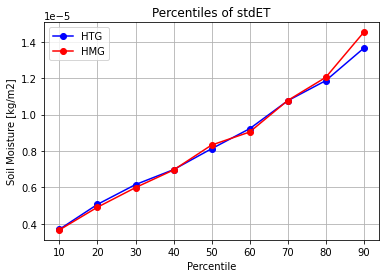

In [333]:
plt.plot(pctSel, HTG_pctCtrlValues, 'b-o', label='HTG')
plt.plot(pctSel, HMG_pctCtrlValues, 'r-o', label='HMG')
plt.xlabel('Percentile')
plt.ylabel('Soil Moisture [kg/m2]')
plt.title('Percentiles of '+controlVar)
plt.legend()
plt.grid()

In [346]:
# ## Now get all the times where daily mean controlVar falls into each bin

# HTGbin0 = np.where((HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[0]))[0]
# HTGbin1 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[0]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[1]))[0]
# HTGbin2 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[1]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[2]))[0]
# HTGbin3 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[2]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[3]))[0]
# HTGbin4 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[3]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[4]))[0]
# HTGbin5 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[4]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[5]))[0]
# HTGbin6 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[5]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[6]))[0]
# HTGbin7 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[6]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[7]))[0]
# HTGbin8 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[7]) &
#                    (HTGclmDS_localDailyMean[controlVar].values <= HTG_pctCtrlValues[8]))[0]
# HTGbin9 = np.where((HTGclmDS_localDailyMean[controlVar].values >  HTG_pctCtrlValues[8]))[0]


# HMGbin0 = np.where((HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[0]))[0]
# HMGbin1 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[0]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[1]))[0]
# HMGbin2 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[1]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[2]))[0]
# HMGbin3 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[2]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[3]))[0]
# HMGbin4 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[3]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[4]))[0]
# HMGbin5 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[4]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[5]))[0]
# HMGbin6 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[5]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[6]))[0]
# HMGbin7 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[6]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[7]))[0]
# HMGbin8 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[7]) &
#                    (HMGclmDS_localDailyMean[controlVar].values <= HMG_pctCtrlValues[8]))[0]
# HMGbin9 = np.where((HMGclmDS_localDailyMean[controlVar].values >  HMG_pctCtrlValues[8]))[0]


In [350]:
# '''
# Find all the times in the full array (20m dt) that line up with the day classifications above. 
# '''
# def getTimes_basedOnPercentile(fullDS, pctDS):
#     iTimes = []
    
#     for iTime in range(len(pctDS.year_month_day.values)):
#         iKeepTimes = np.where((fullDS['time.year'] ==pctDS.year_month_day_level_0.values[iTime]) &
#                               (fullDS['time.month']==pctDS.year_month_day_level_1.values[iTime]) & 
#                               (fullDS['time.day']  ==pctDS.year_month_day_level_2.values[iTime]))[0]    
#         iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
#     # Now select only those times in the local time array
#     DS_dayPct = fullDS.isel(time=iTimes)
    
#     return(DS_dayPct)

In [371]:
## Now get those days out of full arrays
HTGclm_10pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGclm_20pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGclm_30pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGclm_40pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGclm_50pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGclm_60pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGclm_70pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGclm_80pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGclm_90pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGclm_100pct = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGclm_10pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGclm_20pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGclm_30pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGclm_40pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGclm_50pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGclm_60pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGclm_70pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGclm_80pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGclm_90pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGclm_100pct = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin9))



HTGcam_10pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGcam_20pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGcam_30pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGcam_40pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGcam_50pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGcam_60pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGcam_70pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGcam_80pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGcam_90pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGcam_100pct = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGcam_10pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGcam_20pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGcam_30pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGcam_40pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGcam_50pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGcam_60pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGcam_70pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGcam_80pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGcam_90pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGcam_100pct = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9))




In [372]:
# HTGcam_10pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0))
# HTGcam_20pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1))
# HTGcam_30pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2))
# HTGcam_40pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3))
# HTGcam_50pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4))
# HTGcam_60pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5))
# HTGcam_70pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6))
# HTGcam_80pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7))
# HTGcam_90pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8))
# HTGcam_100pct = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9))


# HMGcam_10pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0))
# HMGcam_20pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1))
# HMGcam_30pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2))
# HMGcam_40pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3))
# HMGcam_50pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4))
# HMGcam_60pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5))
# HMGcam_70pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6))
# HMGcam_80pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7))
# HMGcam_90pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8))
# HMGcam_100pct = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9))



In [373]:
startHr    = 8
endHr      = 10 


hrMeansHTG_10pct  = getMeanOverHours(HTGcam_10pct, startHr, endHr)
hrMeansHTG_20pct  = getMeanOverHours(HTGcam_20pct, startHr, endHr)
hrMeansHTG_30pct  = getMeanOverHours(HTGcam_30pct, startHr, endHr)
hrMeansHTG_40pct  = getMeanOverHours(HTGcam_40pct, startHr, endHr)
hrMeansHTG_50pct  = getMeanOverHours(HTGcam_50pct, startHr, endHr)
hrMeansHTG_60pct  = getMeanOverHours(HTGcam_60pct, startHr, endHr)
hrMeansHTG_70pct  = getMeanOverHours(HTGcam_70pct, startHr, endHr)
hrMeansHTG_80pct  = getMeanOverHours(HTGcam_80pct, startHr, endHr)
hrMeansHTG_90pct  = getMeanOverHours(HTGcam_90pct, startHr, endHr)
hrMeansHTG_100pct = getMeanOverHours(HTGcam_100pct, startHr, endHr)


hrMeansHMG_10pct  = getMeanOverHours(HMGcam_10pct, startHr, endHr)
hrMeansHMG_20pct  = getMeanOverHours(HMGcam_20pct, startHr, endHr)
hrMeansHMG_30pct  = getMeanOverHours(HMGcam_30pct, startHr, endHr)
hrMeansHMG_40pct  = getMeanOverHours(HMGcam_40pct, startHr, endHr)
hrMeansHMG_50pct  = getMeanOverHours(HMGcam_50pct, startHr, endHr)
hrMeansHMG_60pct  = getMeanOverHours(HMGcam_60pct, startHr, endHr)
hrMeansHMG_70pct  = getMeanOverHours(HMGcam_70pct, startHr, endHr)
hrMeansHMG_80pct  = getMeanOverHours(HMGcam_80pct, startHr, endHr)
hrMeansHMG_90pct  = getMeanOverHours(HMGcam_90pct, startHr, endHr)
hrMeansHMG_100pct = getMeanOverHours(HMGcam_100pct, startHr, endHr)


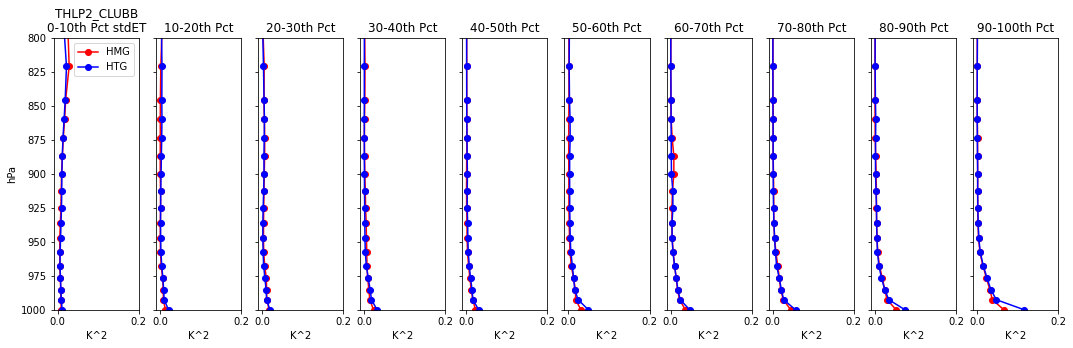

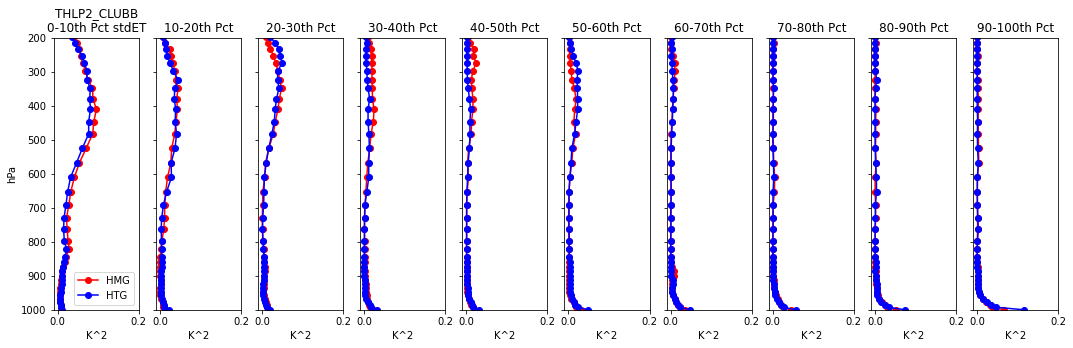

In [376]:
plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.2, 800)  ## Used for std(ET) percentiles
plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.2, 200)  ## Used for std(ET) percentiles


#### What about wD/wW/dD/dW day classifications? 

In [37]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)


In [38]:
## First, need to get daily rain amounts 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()



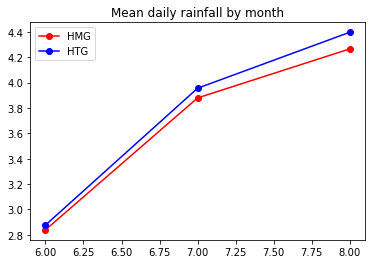

In [39]:
# June mean rain: 
iJune = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==6)[0]
iJuly = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==7)[0]
iAug  = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==8)[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.legend(['HMG','HTG'])



Number of total days in record:   344
Number of dry days (< 1.000):     169
Number of wet days (>= 1.000):    175


Text(0.5, 1.0, 'Wet days by month')

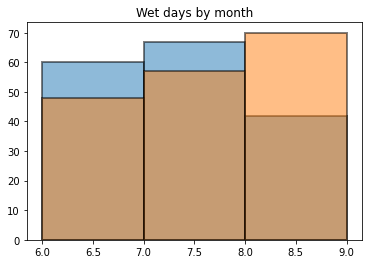

In [40]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))


iSelDryDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0]
dryDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelDryDays)
plt.hist(dryDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Dry days by month')

iSelWetDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0]
wetDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelWetDays)
plt.hist(wetDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Wet days by month')




In [62]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('HMG ----')
print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))

print('HTG ----')
print('Number of total days in record:   %i' % (len(HTGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HTGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):     %i' % (prectCutoff, len(np.where(HTGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))




HMG ----
Number of total days in record:   264
Number of dry days (< 1.000):     129
Number of wet days (>= 1.000):     135
HTG ----
Number of total days in record:   264
Number of dry days (< 1.000):     129
Number of wet days (>= 1.000):     135


In [41]:
# Define classification by day... 

classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
# HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
# HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
# HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
# HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
# HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
# HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)

## Keep only days that agree on classification between HMG and HTG
setHMG_dDry = set(idDry_HMG)
setHTG_dDry = set(idDry_HTG)
iKeep_dDry  = list(setHMG_dDry & setHTG_dDry)
HMG_dDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)
HTG_dDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)


setHMG_dWet = set(idWet_HMG)
setHTG_dWet = set(idWet_HTG)
iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
HMG_dWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)
HTG_dWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)


setHMG_wDry = set(iwDry_HMG)
setHTG_wDry = set(iwDry_HTG)
iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
HMG_wDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)
HTG_wDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)


setHMG_wWet = set(iwWet_HMG)
setHTG_wWet = set(iwWet_HTG)
iKeep_wWet  = list(setHMG_wWet & setHTG_wWet)
HMG_wWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)
HTG_wWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)




In [42]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDry.year_month_day.values), len(HTG_dDry.year_month_day.values)) )
print('dWet: %6i %16i' % (len(HMG_dWet.year_month_day.values), len(HTG_dWet.year_month_day.values)) )
print('wDry: %6i %16i' % (len(HMG_wDry.year_month_day.values), len(HTG_wDry.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWet.year_month_day.values), len(HTG_wWet.year_month_day.values)) )


   Number of days in each category   
         HMG              HTG   
dDry:     91               91
dWet:     48               48
wDry:     51               51
wWet:    110              110


In [43]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [44]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wDry)
dWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dWet)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wDry)
dWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dWet)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)


In [50]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dDry)
wDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wDry)
dWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dWet)
wWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wWet)

dDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dDry)
wDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wDry)
dWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dWet)
wWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wWet)

Text(0.5, 1.0, 'dDry days by month')

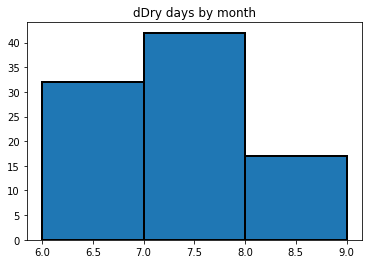

In [45]:
plt.hist(HMG_dDry.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('dDry days by month')

Text(0.5, 1.0, 'wWet days by month')

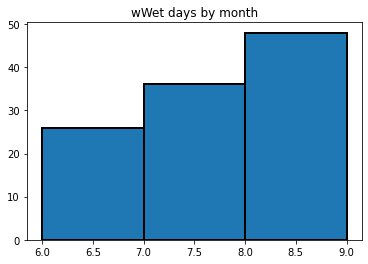

In [46]:
plt.hist(HMG_wWet.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('wWet days by month')

In [47]:
# Get means a function of hour of day
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wDry_HMG = wDryDays_HMG.groupby("time.hour").mean()
hourlyMean_wDry_HTG = wDryDays_HTG.groupby("time.hour").mean()

hourlyMean_dWet_HMG = dWetDays_HMG.groupby("time.hour").mean()
hourlyMean_dWet_HTG = dWetDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()

# Get std as function of hour of day
hourlyStd_dDry_HMG = dDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTG = dDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wDry_HMG = wDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wDry_HTG = wDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dWet_HMG = dWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dWet_HTG = dWetDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMG = wWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTG = wWetDays_HTG.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDry = np.full([24], np.nan)
nTimes_wDry = np.full([24], np.nan)
nTimes_dWet = np.full([24], np.nan)
nTimes_wWet = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr] = len(np.where(dDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wDry[iHr] = len(np.where(wDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_dWet[iHr] = len(np.where(dWetDays_HMG["time.hour"]==iHr)[0])
    nTimes_wWet[iHr] = len(np.where(wWetDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

hourlyMean_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
hourlyMean_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

hourlyMean_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
hourlyMean_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

hourlyMean_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)



In [48]:
## For some reason, the CLM DS's can't run .std, so just make a function that will do it for a selected var
'''
Get standard error for a CLM variable per hour 

All inputs are a string: varSel is the variable to get SE for (assumed 1D)
                         modelComponent is whether this is a variable in CAM or CLM
                         dayClass is the 4-letter abbreviation of day class (dDry, wDry, etc.)

'''

def get_hourlySE(varSel, modelComponent, dayClass):
    
    # Select data 
    if modelComponent=='CAM':
        
        if dayClass=='dDry':
            dsHMG = dDryDays_HMG
            dsHTG = dDryDays_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDays_HMG
            dsHTG = wDryDays_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDays_HMG
            dsHTG = dWetDays_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDays_HMG
            dsHTG = wWetDays_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    elif modelComponent=='CLM':
        
        if dayClass=='dDry':
            dsHMG = dDryDaysCLM_HMG
            dsHTG = dDryDaysCLM_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDaysCLM_HMG
            dsHTG = wDryDaysCLM_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDaysCLM_HMG
            dsHTG = dWetDaysCLM_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDaysCLM_HMG
            dsHTG = wWetDaysCLM_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    else: 
        print('Please select either "CAM" or "CLM" as valid model component options')
        
    ## Now get standard error for selected variable
    varSE_HMG = np.full([24], np.nan)
    varSE_HTG = np.full([24], np.nan)
    
    for iHr in range(24):
        iselHr = np.where(dsHMG["time.hour"].values==iHr)[0]
        
        varHr_HMG = np.squeeze(dsHMG[varSel].values[iselHr,:])
        varSE_HMG[iHr] = np.nanstd(varHr_HMG)/np.sqrt(len(varHr_HMG))
        
        varHr_HTG = np.squeeze(dsHTG[varSel].values[iselHr,:])
        varSE_HTG[iHr] = np.nanstd(varHr_HTG)/np.sqrt(len(varHr_HTG))
    
    return(varSE_HMG, varSE_HTG)



In [51]:
# Get means a function of hour of day
hourlyMeanCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").mean()

In [52]:
## Print some summary daily means for each case 

print('                   dDry      wDry      dWet      wWet')
print('                   -----     -----     -----     -----')
print('Daily rain (HMG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HMG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HMG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_wWet.PRECT_mmPerDT.values)))
print('           (HTG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HTG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HTG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_wWet.PRECT_mmPerDT.values)))
print()
varSel = 'TGCLDLWP'
print('Daily TGCLDLWP (HMG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('               (HTG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDTOT'
print('Daily CLDTOT (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDLOW'
print('Daily CLDLOW (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDMED'
print('Daily CLDMED (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'CLDHGH'
print('Daily CLDHGH (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'QFLX_EVAP_TOT'
print('Daily ET (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('         (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))

print()
varSel = 'SOILWATER_10CM'
print('Daily SM_10CM (HMG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('              (HTG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))






                   dDry      wDry      dWet      wWet
                   -----     -----     -----     -----
Daily rain (HMG):   0.20     0.33      4.94      8.16
           (HTG):   0.18     0.33      4.93      8.29

Daily TGCLDLWP (HMG): 1.88e-02 3.03e-02  7.77e-02  1.01e-01
               (HTG): 1.76e-02 3.17e-02  8.71e-02  9.85e-02

Daily CLDTOT (HMG): 0.53     0.73      0.85      0.93
             (HTG): 0.51     0.72      0.88      0.91

Daily CLDLOW (HMG): 0.03     0.07      0.09      0.16
             (HTG): 0.03     0.07      0.09      0.16

Daily CLDMED (HMG): 0.18     0.25      0.50      0.46
             (HTG): 0.17     0.27      0.50      0.46

Daily CLDHGH (HMG): 0.45     0.66      0.80      0.89
             (HTG): 0.42     0.65      0.83      0.89

Daily ET (HMG):  3.61e-05   3.93e-05   3.69e-05   3.54e-05
         (HTG):  3.58e-05   3.97e-05   3.62e-05   3.61e-05

Daily SM_10CM (HMG): 21.94    25.78    22.94    29.96
              (HTG): 22.09    26.08    23.16    30.2

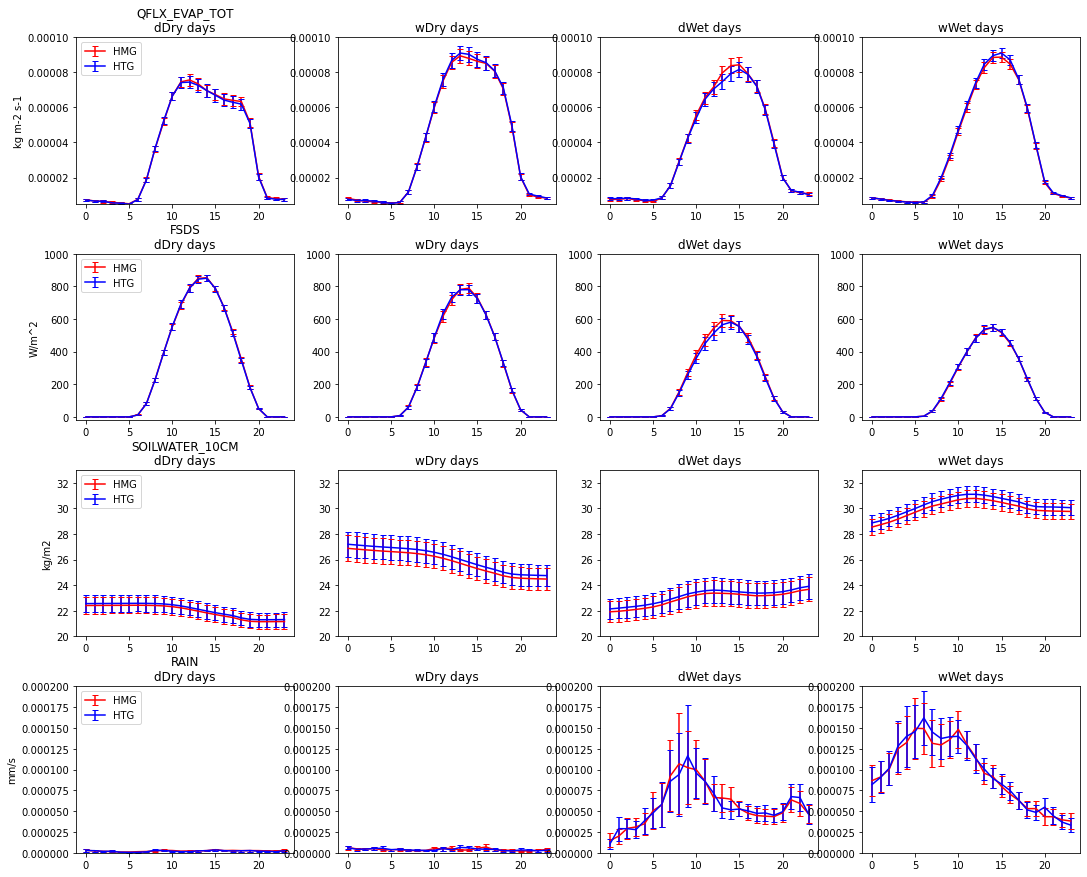

In [54]:
varSel = np.asarray(['QFLX_EVAP_TOT', 'FSDS','SOILWATER_10CM','RAIN'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([1e-4, 1000, 33, 2e-4])
yMin = np.asarray([0.5e-5, -20,  20, 0])

iPlot=0
for iVar in range(len(varSel)):
    
    # First get SE 
    HMGse_dDry, HTGse_dDry = get_hourlySE(varSel[iVar], 'CLM', 'dDry')
    HMGse_wDry, HTGse_wDry = get_hourlySE(varSel[iVar], 'CLM', 'wDry')
    HMGse_dWet, HTGse_dWet = get_hourlySE(varSel[iVar], 'CLM', 'dWet')
    HMGse_wWet, HTGse_wWet = get_hourlySE(varSel[iVar], 'CLM', 'wWet')
    
    
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HMG[varSel[iVar]].values),
                          yerr = 2*HMGse_dDry,
                          fmt='r-',capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[iPlot+0].set_ylabel(HTGclmDS_local['PBLH'].units)
    else: 
        axs[iPlot+0].set_ylabel(HTGclmDS_local[varSel[iVar]].units)
    

    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_wDry,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_wDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_dWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HMG[varSel[iVar]].values), 
                          yerr=2*HMGse_wWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HTG[varSel[iVar]].values), 
                          yerr=2*HTGse_wWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4

    




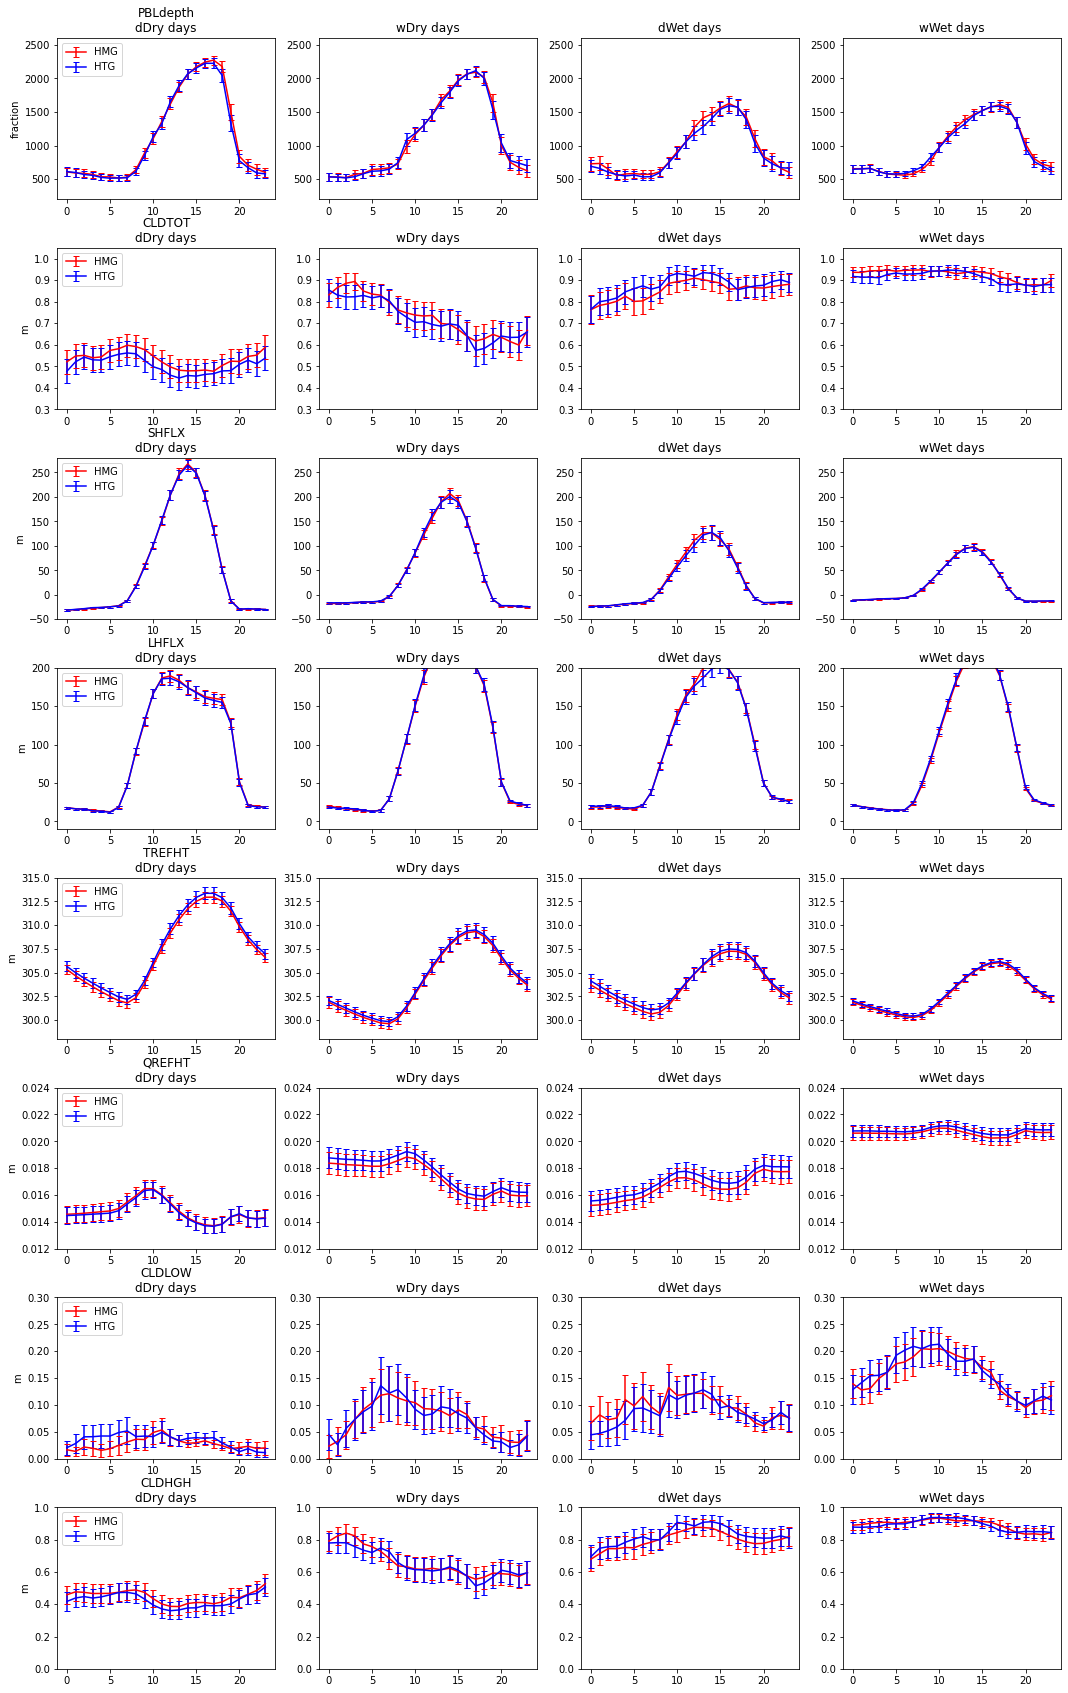

In [55]:
varSel = np.asarray(['PBLdepth','CLDTOT','SHFLX','LHFLX','TREFHT','QREFHT','CLDLOW','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,30))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2600, 1.05, 280, 200, 315, 0.0240, 0.3, 1.0])
yMin = np.asarray([ 200, 0.3,  -50, -10, 298, 0.0120, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b-', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')
#     axs[iPlot+0].grid()


    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






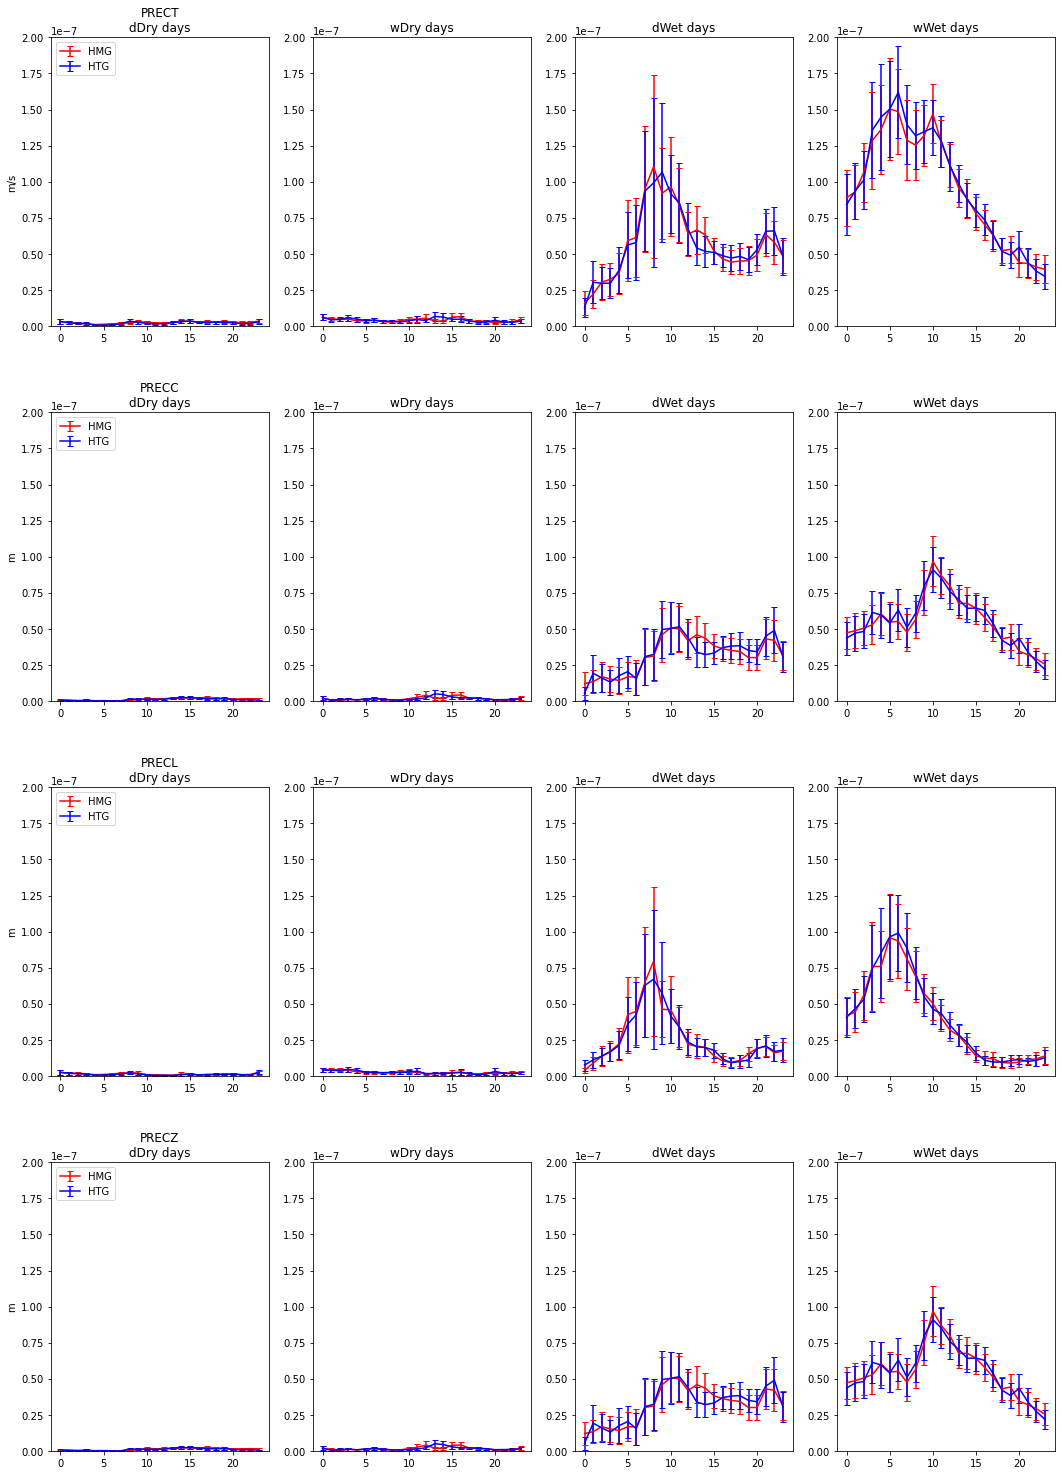

In [56]:
varSel = np.asarray(['PRECT','PRECC','PRECL','PRECZ'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2e-7, 2e-7, 2e-7, 2e-7])
yMin = np.asarray([ 0.0,  0.0,  0, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4




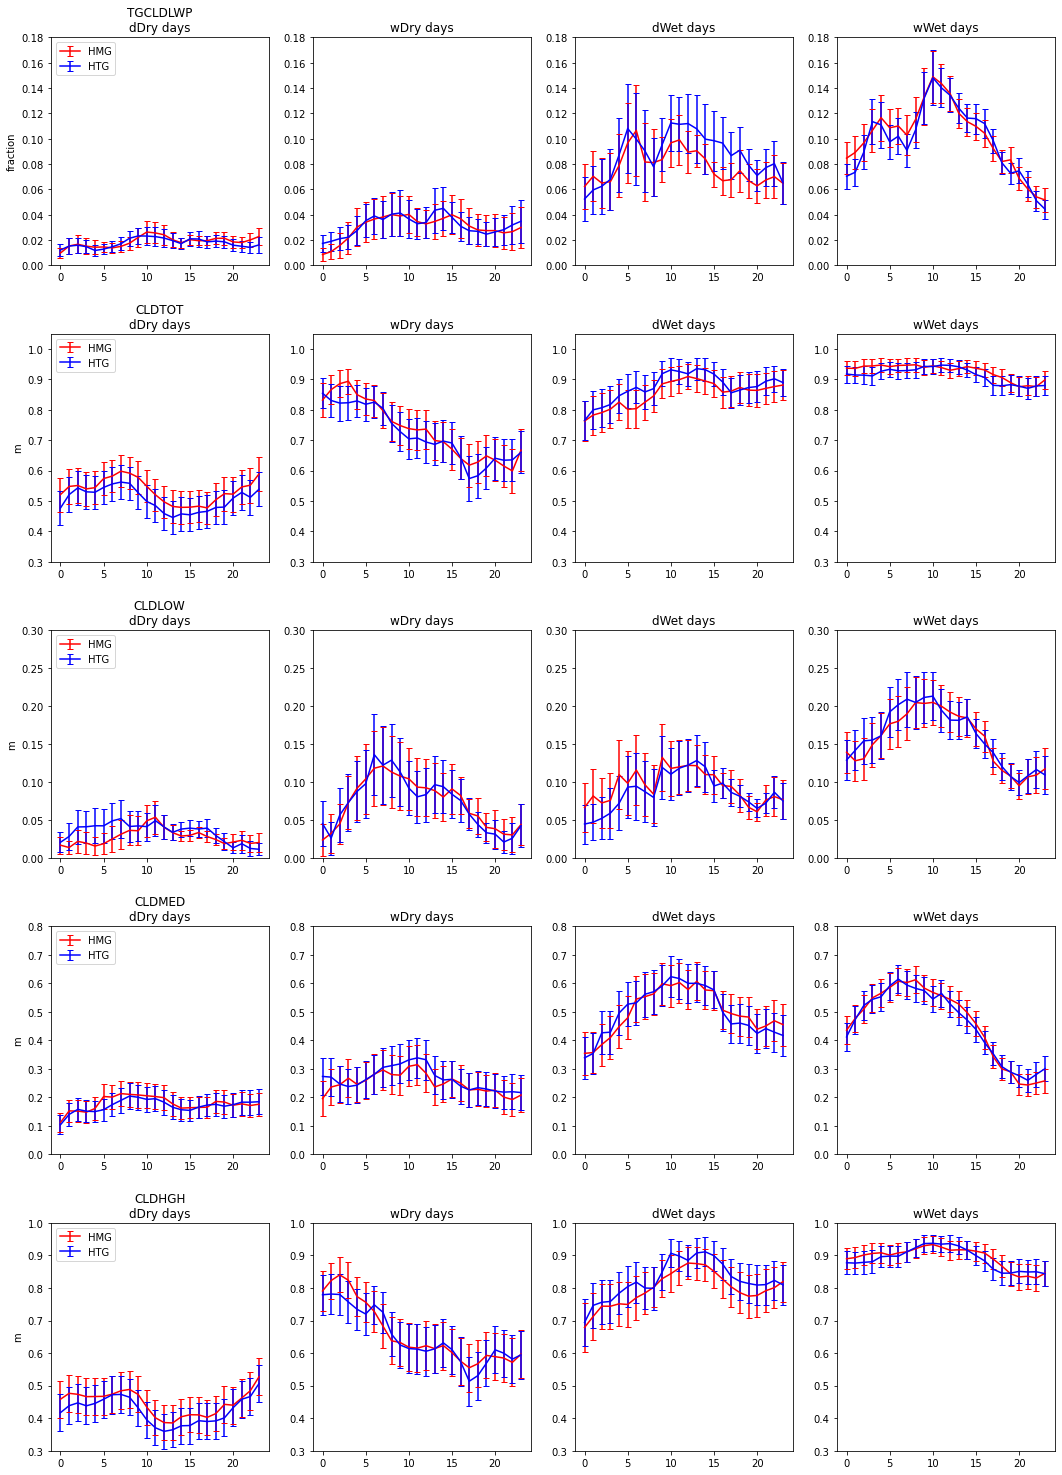

In [57]:
varSel = np.asarray(['TGCLDLWP','CLDTOT','CLDLOW','CLDMED','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.18, 1.05, 0.3, 0.8, 1])
yMin = np.asarray([ 0.0,  0.3,  0, 0, 0.3])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






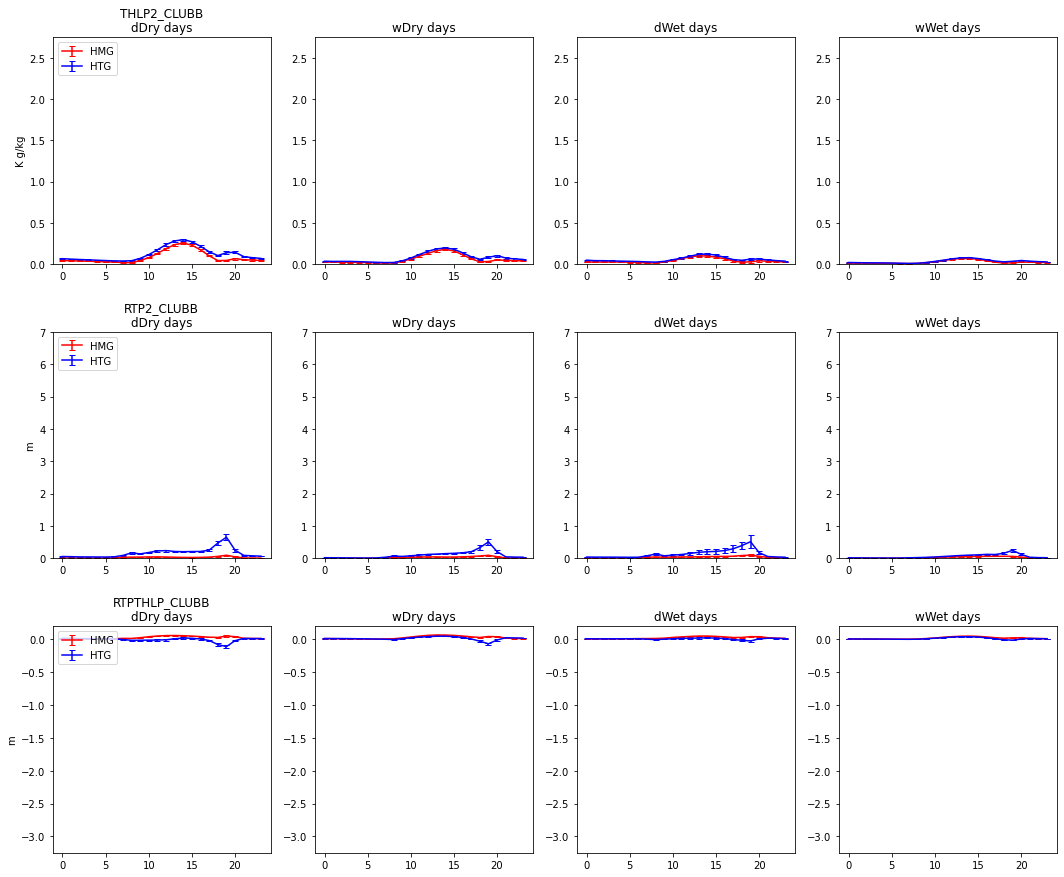

In [58]:
varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.75, 7.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.25])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






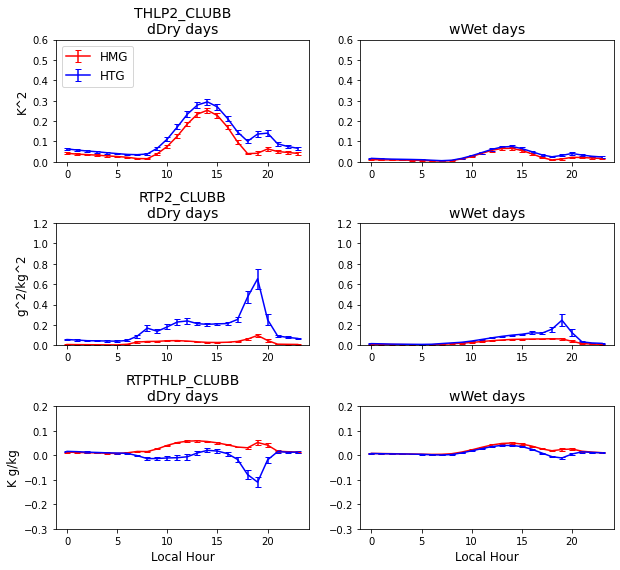

In [84]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.6, 1.2,  0.2])
yMin = np.asarray([0.0, 0.0, -0.3])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2







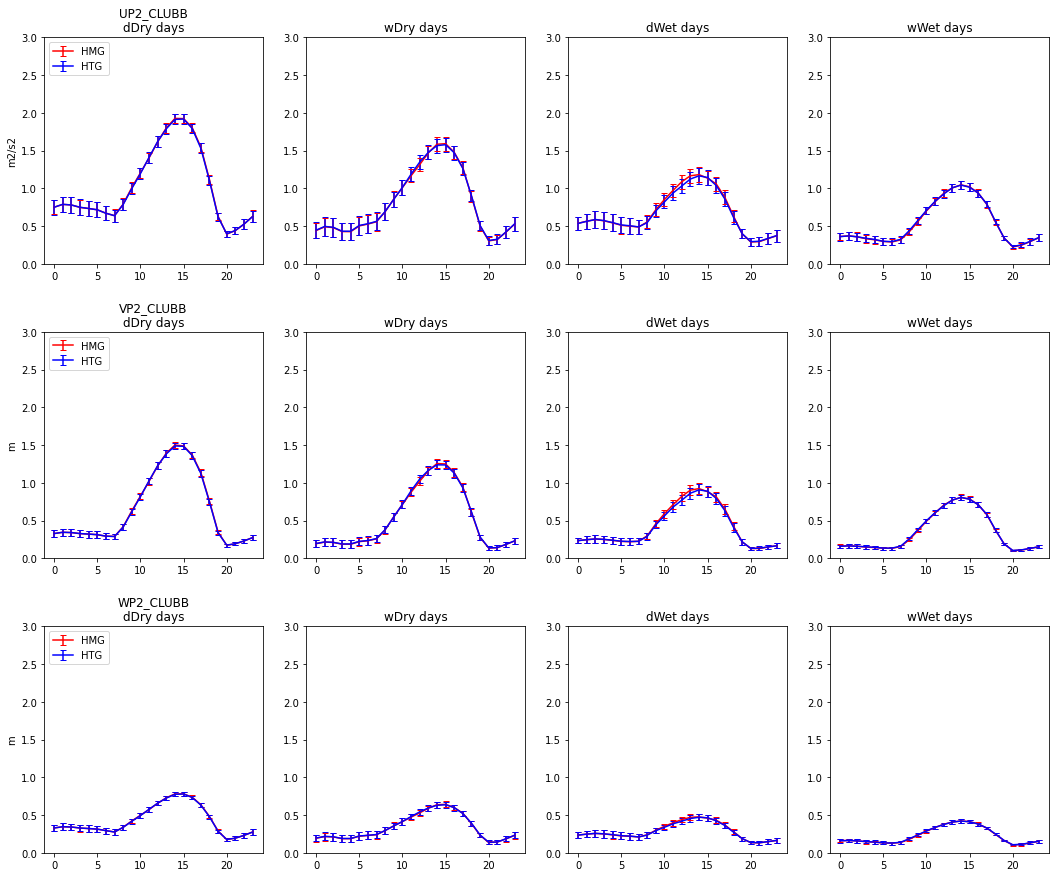

In [59]:
varSel = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([3, 3,  3])
yMin = np.asarray([0.0, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    

    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4







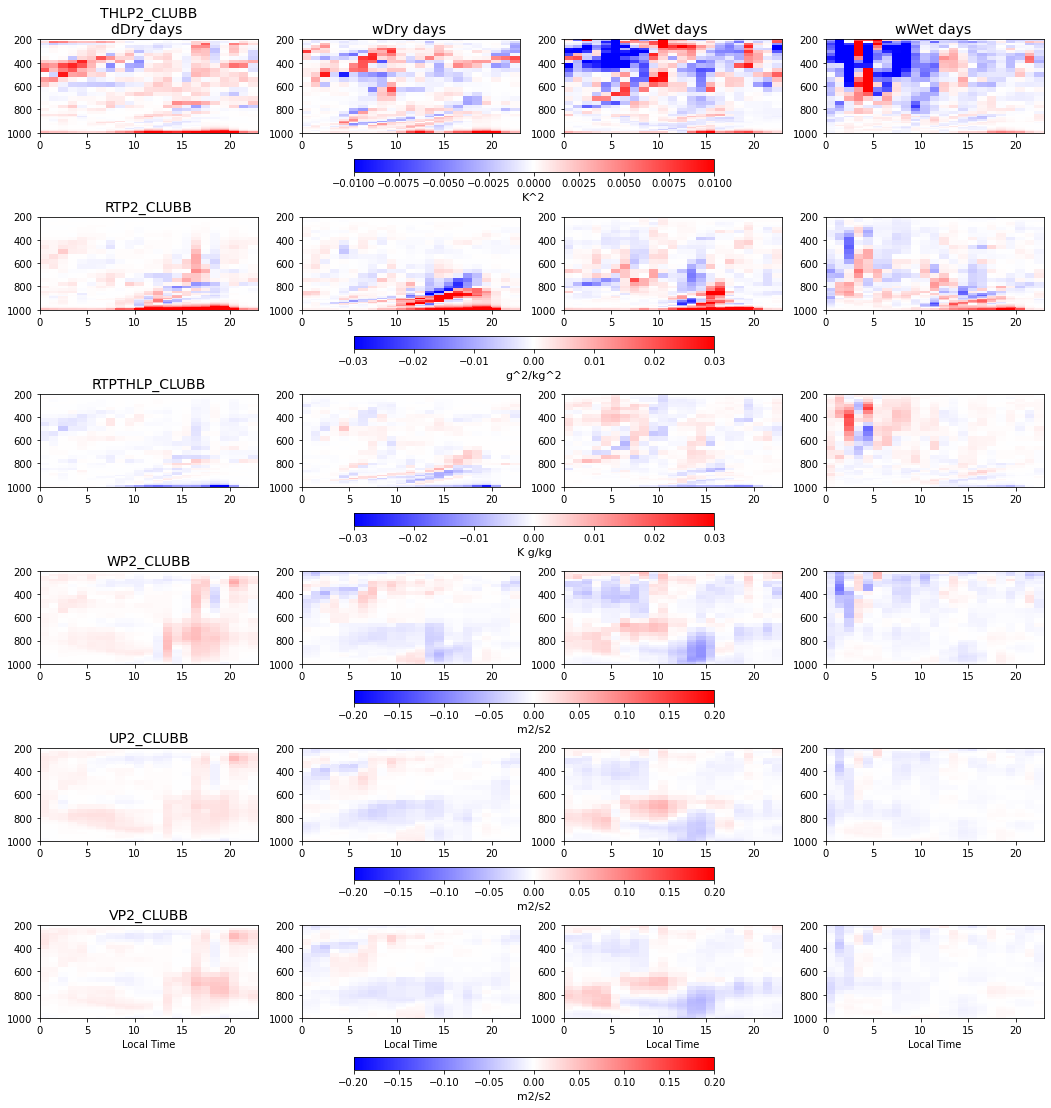

In [60]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.2, 0.2, 0.2])
yLim = 200

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

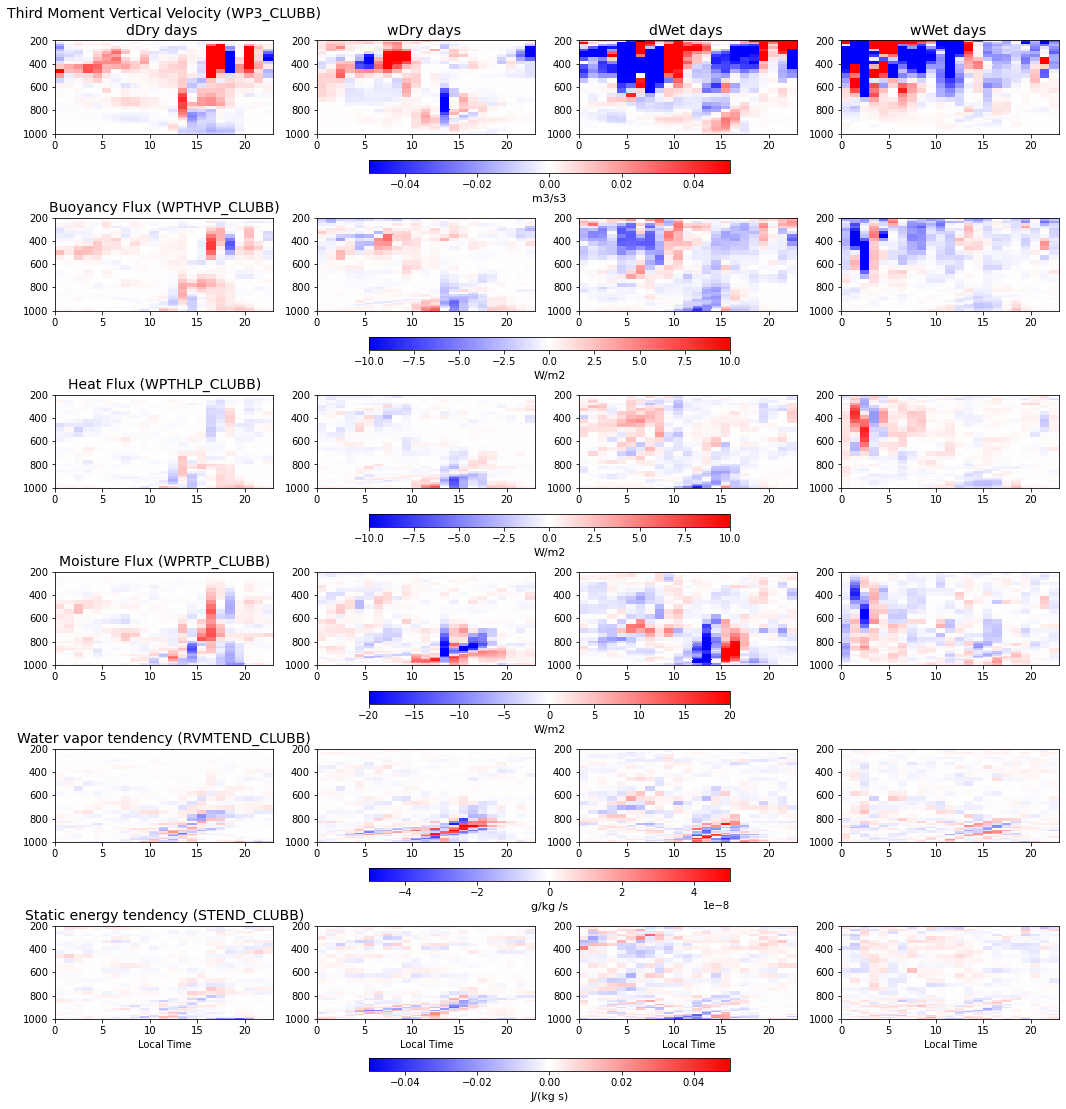

In [61]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 200

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')',fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')'+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

(200.0, 2700.0)

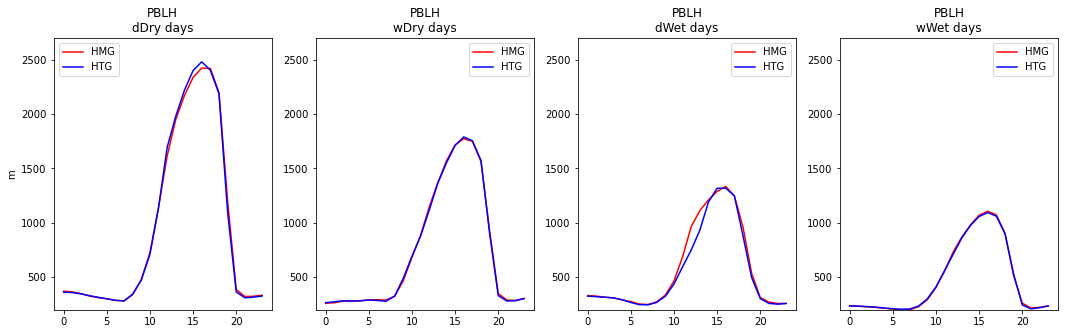

In [63]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'PBLH'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([200,2700])
axs[1].set_ylim([200,2700])
axs[2].set_ylim([200,2700])
axs[3].set_ylim([200,2700])


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nT')

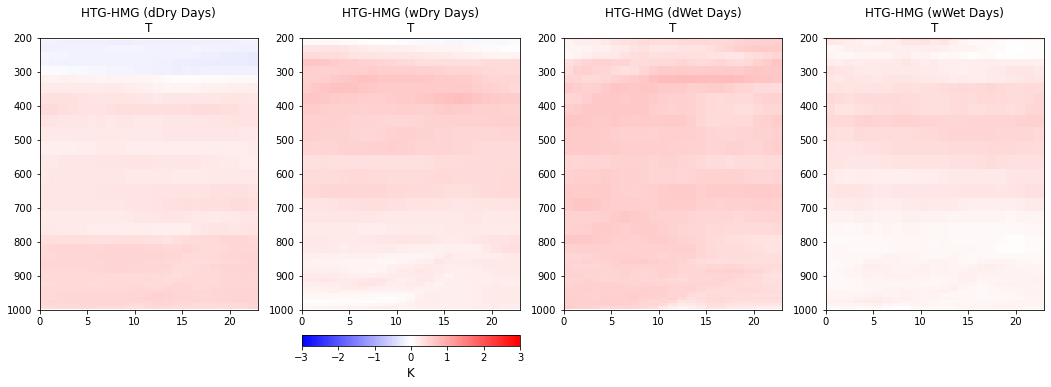

In [64]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = -3
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nQ')

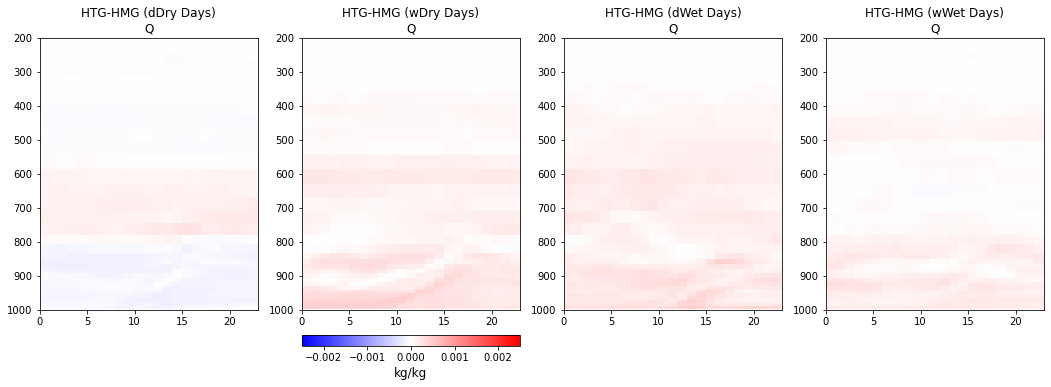

In [65]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'Q' 
cMin = -0.0025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLDLIQ')

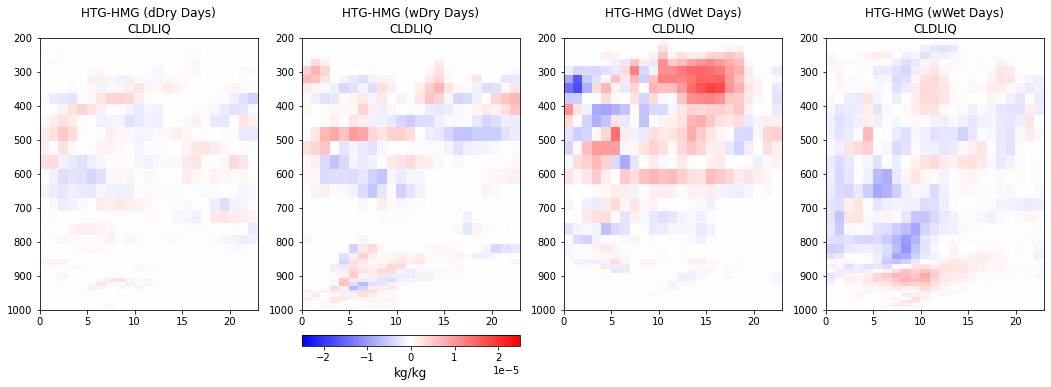

In [66]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLDLIQ' 
cMin = -0.000025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLOUD')

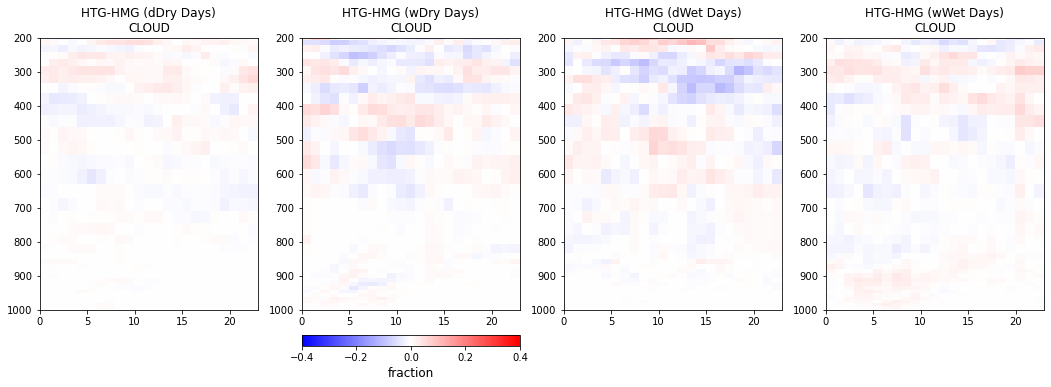

In [67]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLOUD' 
cMin = -0.4
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCONCLD')

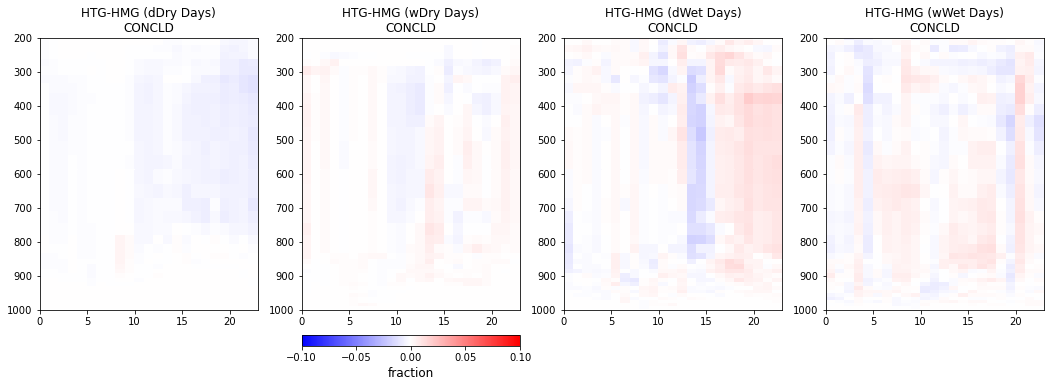

In [68]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CONCLD' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






Text(0.5, 1.0, 'HTG-HMG (wWet Days)\n')

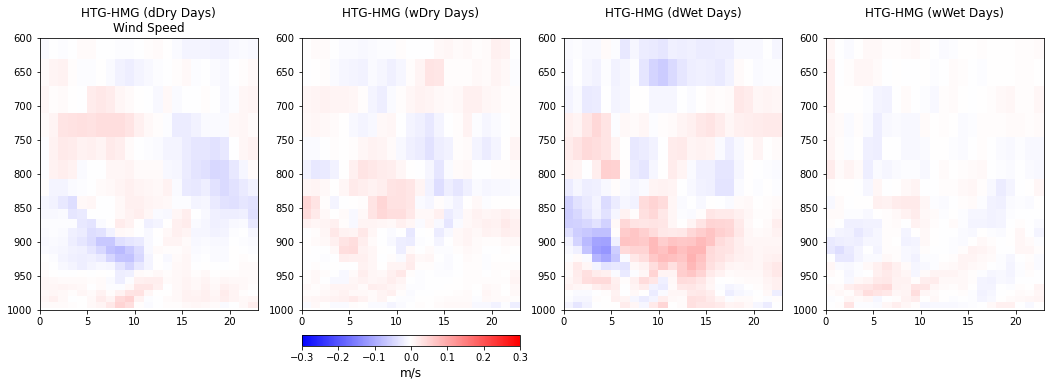

In [69]:
# Wind speed difference 
windSpeed_dDry_HTG = np.sqrt((hourlyMean_dDry_HTG['U'].values**2) + (hourlyMean_dDry_HTG['V'].values**2))
windSpeed_dDry_HMG = np.sqrt((hourlyMean_dDry_HMG['U'].values**2) + (hourlyMean_dDry_HMG['V'].values**2))

windSpeed_wDry_HTG = np.sqrt((hourlyMean_wDry_HTG['U'].values**2) + (hourlyMean_wDry_HTG['V'].values**2))
windSpeed_wDry_HMG = np.sqrt((hourlyMean_wDry_HMG['U'].values**2) + (hourlyMean_wDry_HMG['V'].values**2))

windSpeed_dWet_HTG = np.sqrt((hourlyMean_dWet_HTG['U'].values**2) + (hourlyMean_dWet_HTG['V'].values**2))
windSpeed_dWet_HMG = np.sqrt((hourlyMean_dWet_HMG['U'].values**2) + (hourlyMean_dWet_HMG['V'].values**2))

windSpeed_wWet_HTG = np.sqrt((hourlyMean_wWet_HTG['U'].values**2) + (hourlyMean_wWet_HTG['V'].values**2))
windSpeed_wWet_HMG = np.sqrt((hourlyMean_wWet_HMG['U'].values**2) + (hourlyMean_wWet_HMG['V'].values**2))

hourlyMean_dDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HTG))
hourlyMean_dDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HMG))
hourlyMean_wDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HTG))
hourlyMean_wDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HMG))
hourlyMean_dWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HTG))
hourlyMean_dWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HMG))
hourlyMean_wWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HTG))
hourlyMean_wWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HMG))


fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cMin = -0.3
cMax = -cMin 

# Define differences 
diffVar_dDry = windSpeed_dDry_HTG-windSpeed_dDry_HMG
diffVar_wDry = windSpeed_wDry_HTG-windSpeed_wDry_HMG
diffVar_dWet = windSpeed_dWet_HTG-windSpeed_dWet_HMG
diffVar_wWet = windSpeed_wWet_HTG-windSpeed_wWet_HMG

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local['U'].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([600,1000])
axs[1].set_ylim([600,1000])
axs[2].set_ylim([600,1000])
axs[3].set_ylim([600,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+'Wind Speed')
axs[1].set_title('HTG-HMG (wDry Days)\n')
axs[2].set_title('HTG-HMG (dWet Days)\n')
axs[3].set_title('HTG-HMG (wWet Days)\n')



In [70]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    


    # ------- wDry days ----------
    iTimeSel_wDryHMG = np.where((wDryDays_HMG["time.hour"].values>=startHr) & 
                                (wDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wDryHTG = np.where((wDryDays_HTG["time.hour"].values>=startHr) & 
                                (wDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).mean(dim='time')
    hourlyMean_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).mean(dim='time')
    
    hourlyStd_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).std(dim='time')
    hourlyStd_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).std(dim='time')
    
    stdErr_wDry_HMG = np.squeeze(hourlyStd_wDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wDryHMG))
    stdErr_wDry_HTG = np.squeeze(hourlyStd_wDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wDryHTG))


    # ------- dWet days ----------
    iTimeSel_dWetHMG = np.where((dWetDays_HMG["time.hour"].values>=startHr) & 
                                (dWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dWetHTG = np.where((dWetDays_HTG["time.hour"].values>=startHr) & 
                                (dWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).mean(dim='time')
    hourlyMean_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).mean(dim='time')
    
    hourlyStd_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).std(dim='time')
    hourlyStd_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).std(dim='time')
    
    stdErr_dWet_HMG = np.squeeze(hourlyStd_dWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dWetHMG))
    stdErr_dWet_HTG = np.squeeze(hourlyStd_dWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dWetHTG))


    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,4, figsize=(17,5))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
                axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                        'bo')
    
    
    
    

    # Plot wDry days 
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wDry_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
                    hourlyMean_wDryTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
                    hourlyMean_wDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[1].set_title(varSel+'\nwDry days')
    axs[1].set_xlabel(unitLabel)
        # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) + (2*stdErr_wDry_HMG)
    xmin1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) - (2*stdErr_wDry_HMG)
    xmax2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) + (2*stdErr_wDry_HTG)
    xmin2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) - (2*stdErr_wDry_HTG)

    levSig = np.ones([len(hourlyMean_wDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev]):
                axs[1].plot(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[1].plot(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            
            

    # Plot dWet days 
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
                    hourlyMean_dWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
                    hourlyMean_dWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[2].set_title(varSel+'\ndWet days')
    axs[2].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) + (2*stdErr_dWet_HMG)
    xmin1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) - (2*stdErr_dWet_HMG)
    xmax2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) + (2*stdErr_dWet_HTG)
    xmin2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) - (2*stdErr_dWet_HTG)

    levSig = np.ones([len(hourlyMean_dWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev]):
                axs[2].plot(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[2].plot(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[3].legend()
    axs[3].set_title(varSel+'\nwWet days')
    axs[3].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
                axs[3].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[3].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([maxLev,1000])
    axs[1].set_ylim([maxLev,1000])
    axs[2].set_ylim([maxLev,1000])
    axs[3].set_ylim([maxLev,1000])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    axs[2].set_xlim([xMin,xMax])
    axs[3].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    
    return

In [71]:
## Add wind speed to underlying DS

windSpeed_dDryDays_HMG = np.sqrt((dDryDays_HMG.U.values**2.0) + (dDryDays_HMG.V.values**2.0))
windSpeed_dDryDays_HTG = np.sqrt((dDryDays_HTG.U.values**2.0) + (dDryDays_HTG.V.values**2.0))

windSpeed_wDryDays_HMG = np.sqrt((wDryDays_HMG.U.values**2.0) + (wDryDays_HMG.V.values**2.0))
windSpeed_wDryDays_HTG = np.sqrt((wDryDays_HTG.U.values**2.0) + (wDryDays_HTG.V.values**2.0))

windSpeed_dWetDays_HMG = np.sqrt((dWetDays_HMG.U.values**2.0) + (dWetDays_HMG.V.values**2.0))
windSpeed_dWetDays_HTG = np.sqrt((dWetDays_HTG.U.values**2.0) + (dWetDays_HTG.V.values**2.0))

windSpeed_wWetDays_HMG = np.sqrt((wWetDays_HMG.U.values**2.0) + (wWetDays_HMG.V.values**2.0))
windSpeed_wWetDays_HTG = np.sqrt((wWetDays_HTG.U.values**2.0) + (wWetDays_HTG.V.values**2.0))


dDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMG))
dDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTG))

wDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HMG))
wDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HTG))

dWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HMG))
dWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HTG))

wWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMG))
wWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTG))




Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


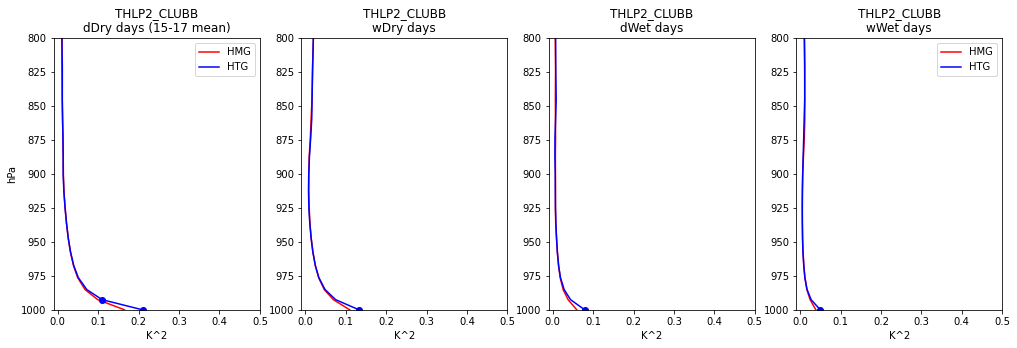

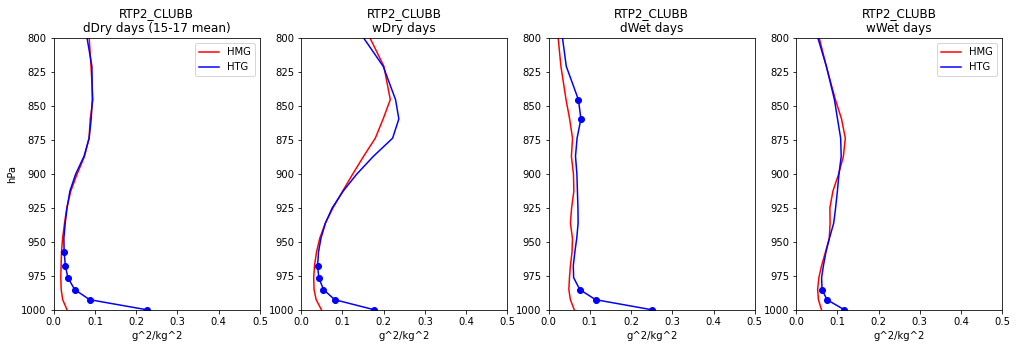

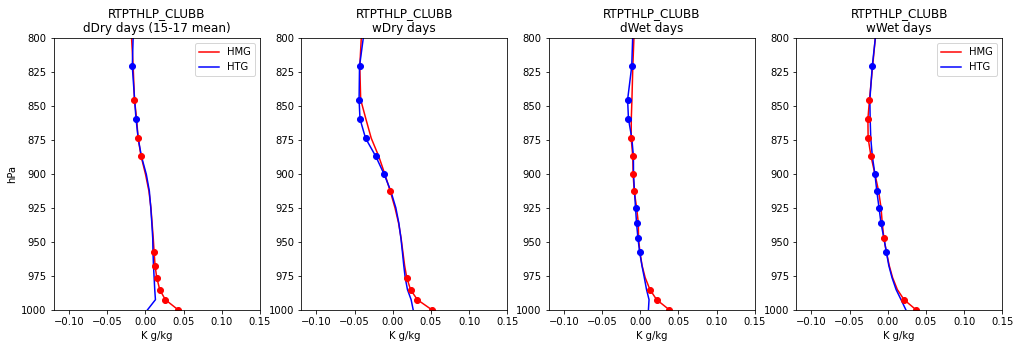

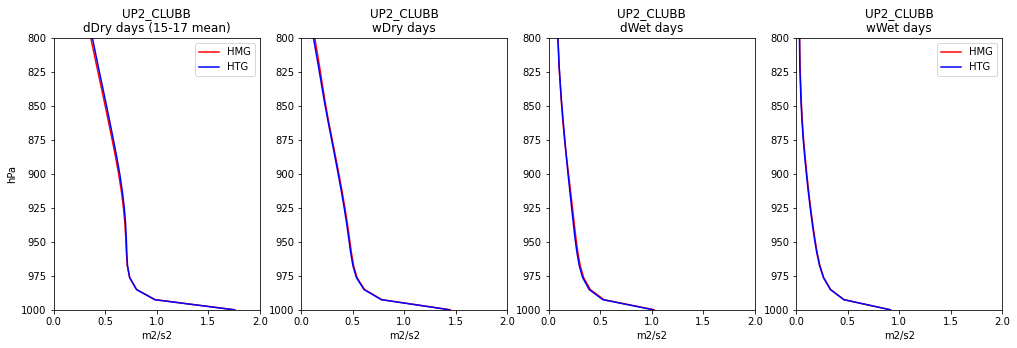

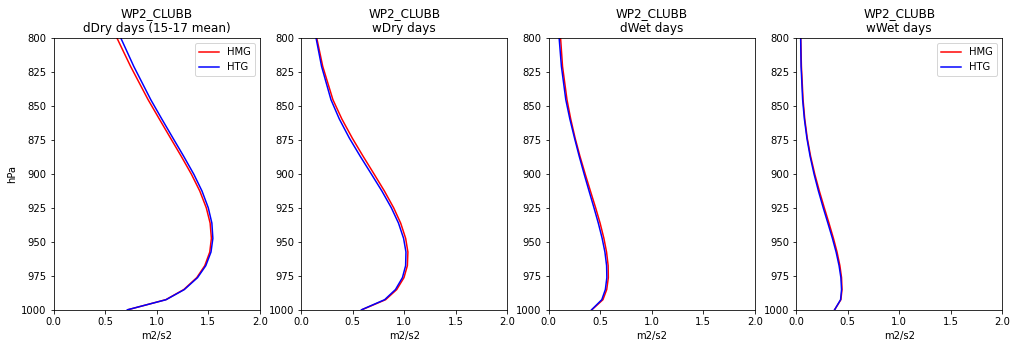

In [75]:
startHr = 15
endHr   = 17
maxLev  = 800

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'THLP2_CLUBB', maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 0.5)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTP2_CLUBB', maxLev,
#                            0.0, 1.75)
                             0.0, 0.5)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTPTHLP_CLUBB', maxLev,
#                            -0.75, 0.15)
                             -0.12, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UP2_CLUBB', maxLev,
#                            0.0, 2.0)
                             0.0, 2.0)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP2_CLUBB', maxLev,
#                            0.0, 0.8)
                             0.0, 2.0)



Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


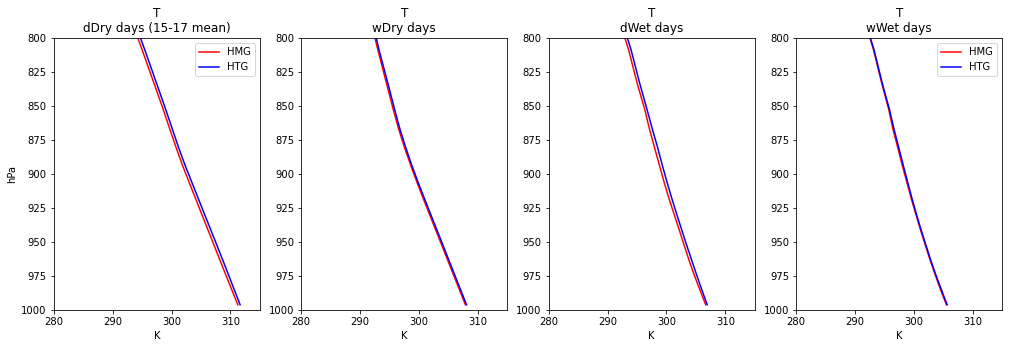

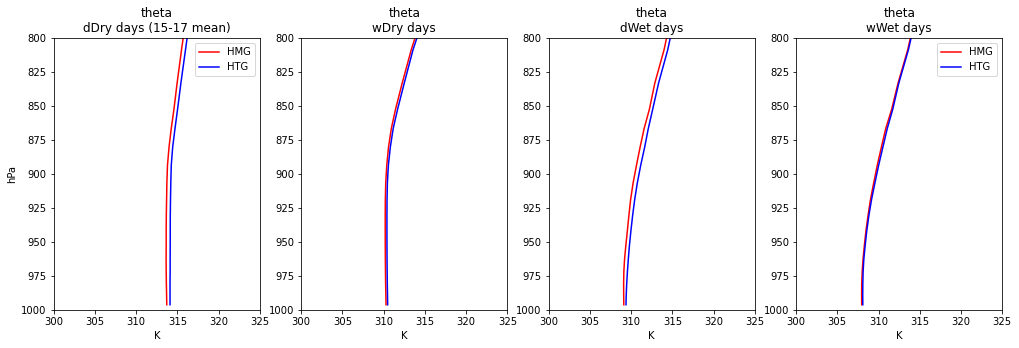

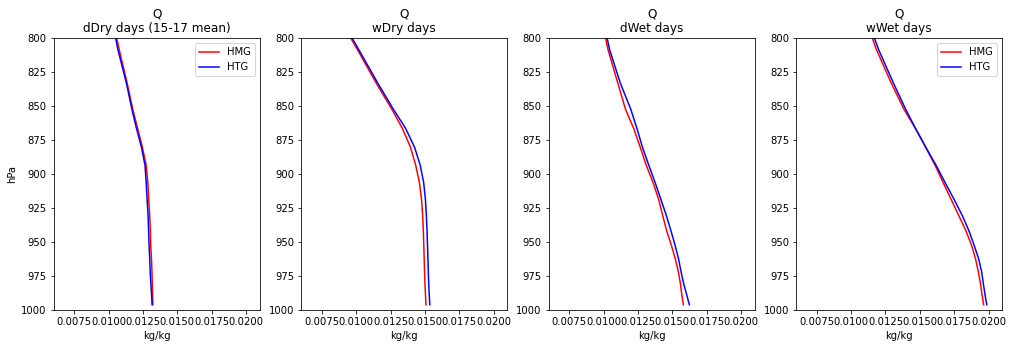

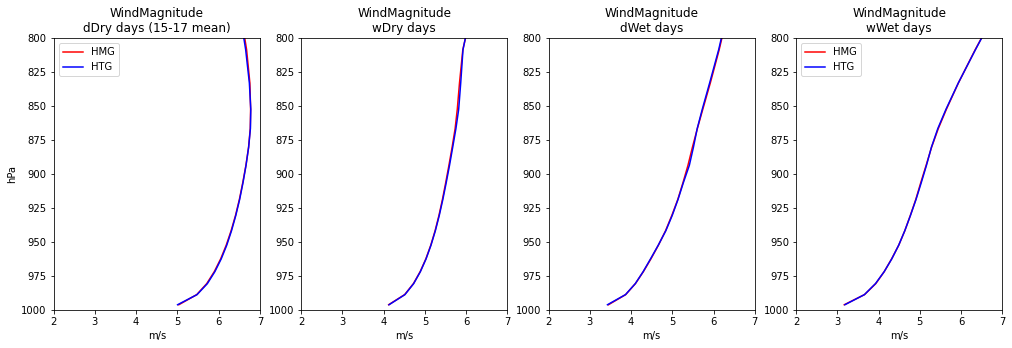

In [76]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'T', maxLev,
#                            280, 310)
                           280, 315)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'theta', maxLev,
#                            280, 310)
                           300, 325)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'Q', maxLev,
#                            0.006, 0.022)
                           0.006, 0.021)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WindMagnitude', 800,
#                            0.006, 0.022)
                           2, 7)



Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


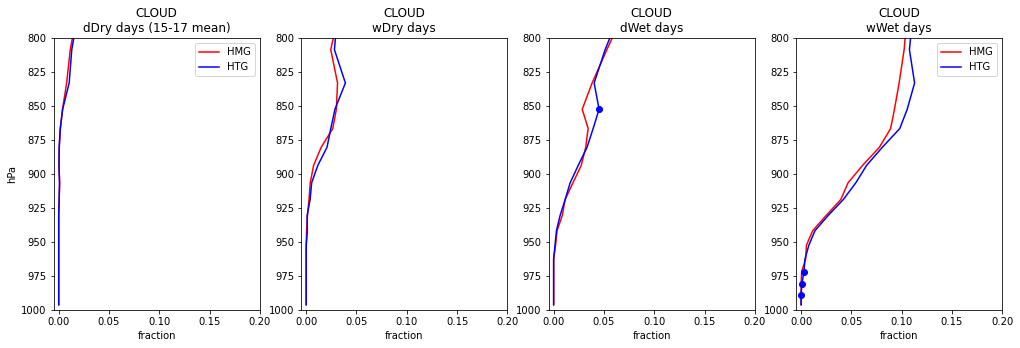

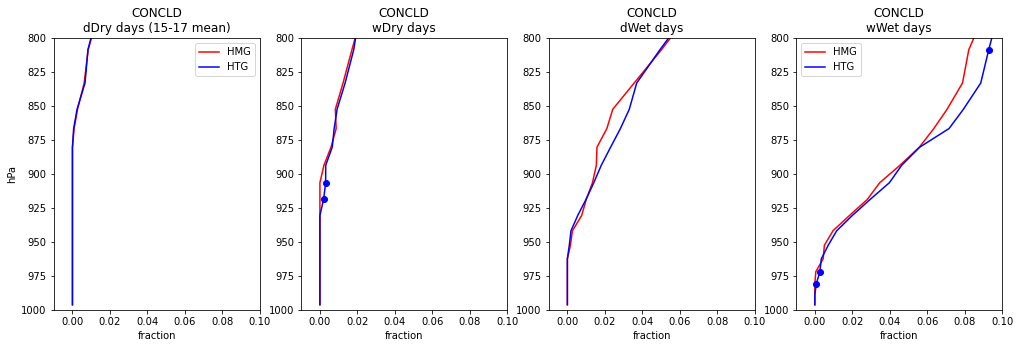

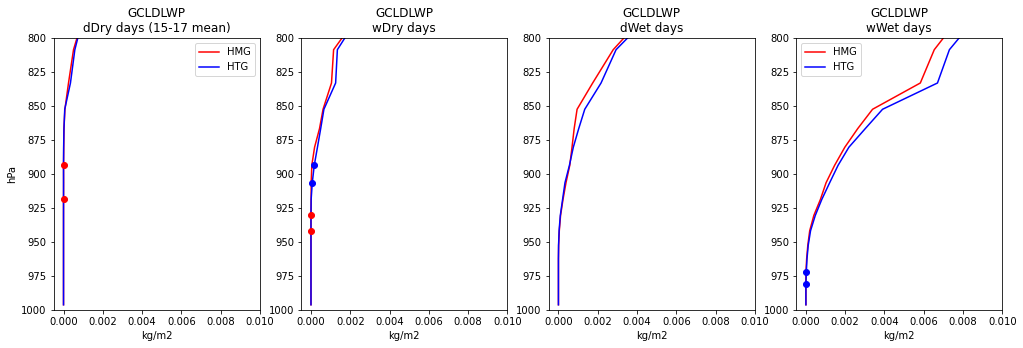

In [77]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CLOUD', 800,
#                            -0.01, 0.3)
                           -0.005, 0.2)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CONCLD', 800,
                           -0.01, 0.1)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'GCLDLWP', 800,
                           -0.0005, 0.010)



Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


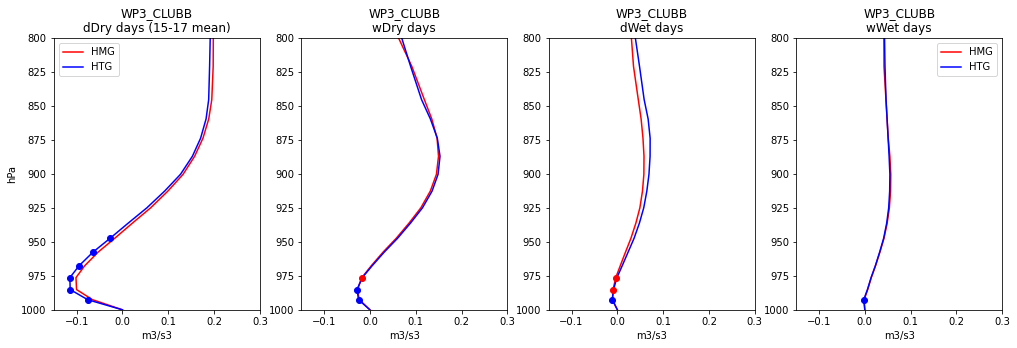

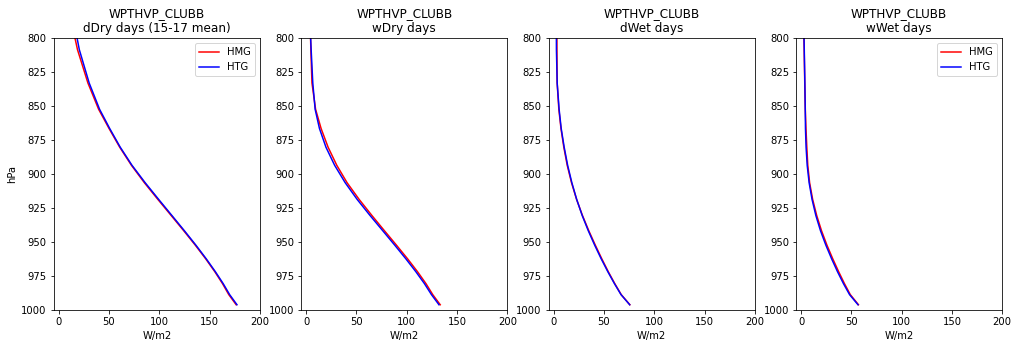

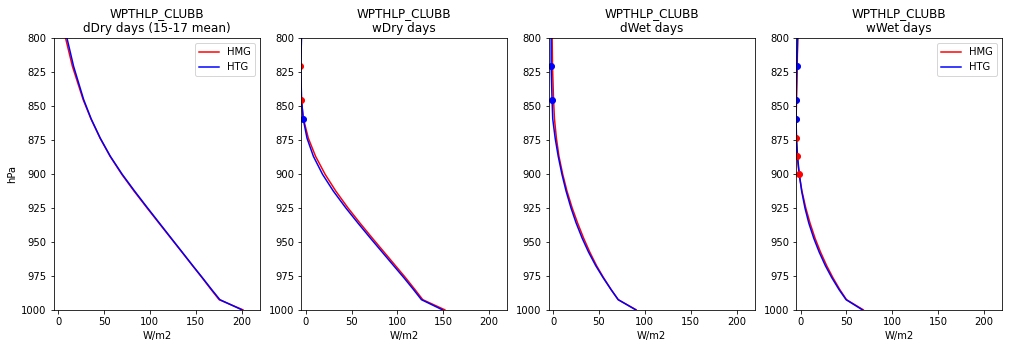

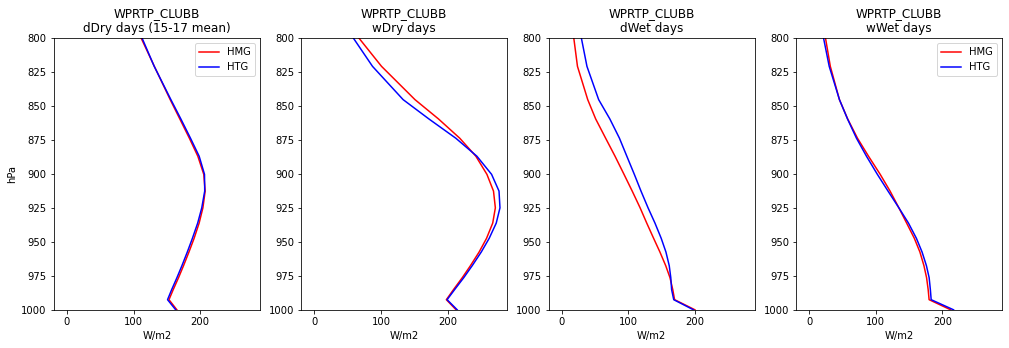

In [82]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP3_CLUBB', maxLev,
#                            -0.02, 0.1)
                           -0.15, 0.3)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHVP_CLUBB', maxLev,
#                            -5, 60)
                           -5, 200)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHLP_CLUBB', maxLev,
#                            -5, 80)
                           -5, 220)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPRTP_CLUBB', maxLev,
#                            -10, 120)
                            -20, 290)                                      


#### Could we also define these vertical profiles as kind of a PDF - along some range of soil moisture or precip or something?? 

In [264]:
SMbins    = np.linspace(15, 40, 10)
prectBins = np.linspace(0, 1e-6, 10)

for iBin in range(len(SMbins)+2):
    
    if iBin==0:
        selBin = np.where(HTGclmDS_local.SOILWATER_10CM.values<SMbins[0])[0]
    elif iBin==len(SMbins):
        selBin = np.where(HTGclmDS_local.SOILWATER_10CM.values>=SMbins[-1])[0]
    else: 
        selBin = np.where( (HTGclmDS_local.SOILWATER_10CM.values>=SMbins[iBin]) &
                           (HTGclmDS_local.SOILWATER_10CM.values<SMbins[iBin+1]) )[0]
    

    print('Bin Number: %i      with %i Observations' % (iBin, len(selBin)))

Bin Number: 0      with 57 Observations
Bin Number: 1      with 2618 Observations
Bin Number: 2      with 3174 Observations
Bin Number: 3      with 2505 Observations
Bin Number: 4      with 2707 Observations
Bin Number: 5      with 1923 Observations
Bin Number: 6      with 1286 Observations
Bin Number: 7      with 783 Observations
Bin Number: 8      with 278 Observations


IndexError: index 10 is out of bounds for axis 0 with size 10

In [263]:
len(SMbins)

10

(array([1.6841e+04, 8.4200e+02, 3.1900e+02, 1.6600e+02, 9.9000e+01,
        4.2000e+01, 2.7000e+01, 1.6000e+01, 3.0000e+00, 5.0000e+00]),
 array([0.0000000e+00, 1.3296598e-07, 2.6593196e-07, 3.9889792e-07,
        5.3186392e-07, 6.6482988e-07, 7.9779585e-07, 9.3076181e-07,
        1.0637278e-06, 1.1966938e-06, 1.3296598e-06], dtype=float32),
 <BarContainer object of 10 artists>)

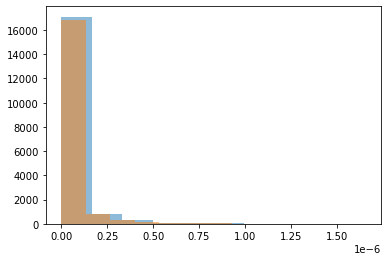

In [256]:
plt.hist(np.squeeze(HTGcamDS_local.PRECT.values),alpha=0.5)
plt.hist(np.squeeze(HMGcamDS_local.PRECT.values),alpha=0.5)

(array([3235., 2075., 3162., 2260., 2700., 1732., 1440., 1063.,  583.,
         110.]),
 array([14.878096, 17.41539 , 19.952684, 22.489979, 25.027273, 27.564568,
        30.10186 , 32.639156, 35.17645 , 37.713745, 40.251038],
       dtype=float32),
 <BarContainer object of 10 artists>)

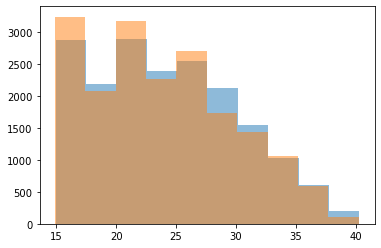

In [245]:
plt.hist(HTGclmDS_local.SOILWATER_10CM.values,alpha=0.5)
plt.hist(HMGclmDS_local.SOILWATER_10CM.values,alpha=0.5)

#### Define days based on actual heterogeneity (i.e., std of patch LHFLX)